In [197]:
import os
from pathlib import Path
import json
import time
import logging
import requests
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
from dataclasses import dataclass, asdict

In [198]:
logger = logging.getLogger(__name__)

GAMMA_API = "https://gamma-api.polymarket.com"
CACHE_PATH = Path("data/resolution_cache.json")
REQUEST_DELAY = 0.2  # seconds between requests to avoid rate limiting

In [199]:
class ResolutionFetcher:
    """
    Fetches and caches market resolution outcomes from the Gamma API.
    Maps token_id -> outcome (1.0 = paid out, 0.0 = worthless)
    """

    def __init__(self, cache_path: Path = CACHE_PATH):
        self.cache_path = cache_path
        self._cache: dict = self._load_cache()

    def _load_cache(self) -> dict:
        if self.cache_path.exists():
            with open(self.cache_path) as f:
                data = json.load(f)
                logger.info(f"Loaded {len(data)} cached resolutions")
                return data
        return {}

    def _save_cache(self):
        self.cache_path.parent.mkdir(parents=True, exist_ok=True)
        with open(self.cache_path, "w") as f:
            json.dump(self._cache, f, indent=2)

    def fetch_resolution(self, slug: str) -> dict | None:
        """
        Returns {token_id: outcome} for a resolved market, or None if
        the market is unresolved or the fetch fails.
        Caches results locally — safe to call repeatedly.
        """
        # Return cached result if available
        if slug in self._cache:
            return self._cache[slug]

        try:
            resp = requests.get(
                f"{GAMMA_API}/markets/slug/{slug}",
                timeout=10
            )
            resp.raise_for_status()
            result = resp.json()

            # Only cache fully resolved markets
            if result.get("umaResolutionStatus") != "resolved":
                logger.debug(f"Market {slug} not yet resolved")
                return None

            clob_token_ids = json.loads(result["clobTokenIds"])
            outcome_prices = json.loads(result["outcomePrices"])

            resolution = {
                "slug": slug,
                "condition_id": result["conditionId"],
                "closed_time": result.get("closedTime"),
                "token_outcomes": {
                    clob_token_ids[0]: float(outcome_prices[0]),
                    clob_token_ids[1]: float(outcome_prices[1]),
                },
                "winning_token": clob_token_ids[
                    outcome_prices.index("1")
                ],
            }

            self._cache[slug] = resolution
            self._save_cache()
            time.sleep(REQUEST_DELAY)
            return resolution

        except Exception as e:
            logger.error(f"Failed to fetch resolution for {slug}: {e}")
            return None

    def fetch_batch(self, slugs: list[str]) -> dict:
        """
        Fetch resolutions for multiple markets.
        Returns {slug: resolution} for all successfully resolved markets.
        Skips already-cached entries without API calls.
        """
        results = {}
        uncached = [s for s in slugs if s not in self._cache]

        if uncached:
            logger.info(f"Fetching {len(uncached)} resolutions ({len(slugs) - len(uncached)} cached)")

        for slug in slugs:
            resolution = self.fetch_resolution(slug)
            if resolution:
                results[slug] = resolution

        return results

In [200]:
fetcher = ResolutionFetcher()
slugs = [
    f.replace(".parquet", "")
    for f in os.listdir("data/trade_events")
    if f.endswith(".parquet")
]
resolutions = fetcher.fetch_batch(slugs)
slug = "btc-updown-5m-1771347300"
resolution = resolutions[slug]

# Load trade data
trades = pq.read_table(f"data/trade_events/{slug}.parquet").to_pandas()
trades

,exchange_timestamp,received_timestamp,market,asset_id,side,trade_price,size,best_bid,best_ask,mid_price,spread,hash
0,1771347423954,1771347423976,0xd348a83820d118655ec690584c330d4c1028c1b75974...,6618044519236381774379123425671050226095410730...,BUY,0.61,0.00,0.60,0.62,0.610,0.02,59eb6e62d9f774291de59d57e3b94827eee02b39
1,1771347423954,1771347423976,0xd348a83820d118655ec690584c330d4c1028c1b75974...,5128724365988716501873998317920086389826064771...,SELL,0.39,0.00,0.38,0.40,0.390,0.02,1b84f009d6473411c899fbebaf0f90eb01b33176
2,1771347423954,1771347423981,0xd348a83820d118655ec690584c330d4c1028c1b75974...,5128724365988716501873998317920086389826064771...,SELL,0.40,328.26,0.38,0.40,0.390,0.02,1b84f009d6473411c899fbebaf0f90eb01b33176
3,1771347423954,1771347423981,0xd348a83820d118655ec690584c330d4c1028c1b75974...,6618044519236381774379123425671050226095410730...,BUY,0.60,328.26,0.60,0.62,0.610,0.02,59eb6e62d9f774291de59d57e3b94827eee02b39
4,1771347424120,1771347424171,0xd348a83820d118655ec690584c330d4c1028c1b75974...,6618044519236381774379123425671050226095410730...,BUY,0.60,216.88,0.60,0.62,0.610,0.02,eaabe35ffaaacda046cfdb584e8f7d2192756160
...,...,...,...,...,...,...,...,...,...,...,...,...
57963,1771347603820,1771347603934,0xd348a83820d118655ec690584c330d4c1028c1b75974...,6618044519236381774379123425671050226095410730...,SELL,0.99,12823.13,0.00,0.01,0.005,0.01,6802cb5284be5bf9df2343def87246c007c86933
57964,1771347603820,1771347603936,0xd348a83820d118655ec690584c330d4c1028c1b75974...,5128724365988716501873998317920086389826064771...,BUY,0.02,2373.05,0.99,1.00,0.995,0.01,b80e381fe06a99592804ab085f9679233cb23bd3
57965,1771347603820,1771347603936,0xd348a83820d118655ec690584c330d4c1028c1b75974...,6618044519236381774379123425671050226095410730...,SELL,0.98,2373.05,0.00,0.01,0.005,0.01,6802cb5284be5bf9df2343def87246c007c86933
57966,1771347603820,1771347603937,0xd348a83820d118655ec690584c330d4c1028c1b75974...,5128724365988716501873998317920086389826064771...,BUY,0.03,1229.00,0.99,1.00,0.995,0.01,b80e381fe06a99592804ab085f9679233cb23bd3


In [201]:
order_book = pq.read_table(f"data/book_snapshots/{slug}.parquet").to_pandas()
order_book

,exchange_timestamp,received_timestamp,market,asset_id,mid_price,spread,book_imbalance,bid_price_1,bid_size_1,bid_price_2,...,ask_size_7,ask_price_8,ask_size_8,ask_price_9,ask_size_9,ask_price_10,ask_size_10,hash,full_bids,full_asks
0,1771347423954,1771347423981,0xd348a83820d118655ec690584c330d4c1028c1b75974...,6618044519236381774379123425671050226095410730...,0.610,0.02,0.102229,0.60,328.26,0.59,...,372.00,0.69,342.00,0.70,291.00,0.71,371.09,59eb6e62d9f774291de59d57e3b94827eee02b39,"[[0.01, 13092.53], [0.02, 3694.2], [0.03, 1583...","[[0.99, 13249.26], [0.98, 3462.0], [0.97, 1538..."
1,1771347423954,1771347423982,0xd348a83820d118655ec690584c330d4c1028c1b75974...,5128724365988716501873998317920086389826064771...,0.390,0.02,-0.102229,0.38,48.61,0.37,...,180.02,0.47,278.00,0.48,487.30,0.49,318.40,1b84f009d6473411c899fbebaf0f90eb01b33176,"[[0.01, 13249.26], [0.02, 3462.0], [0.03, 1538...","[[0.99, 13092.53], [0.98, 3694.2], [0.97, 1583..."
2,1771347424120,1771347424174,0xd348a83820d118655ec690584c330d4c1028c1b75974...,6618044519236381774379123425671050226095410730...,0.610,0.02,0.084284,0.60,216.88,0.59,...,372.00,0.69,342.00,0.70,291.00,0.71,371.09,eaabe35ffaaacda046cfdb584e8f7d2192756160,"[[0.01, 13092.53], [0.02, 3694.2], [0.03, 1583...","[[0.99, 13249.26], [0.98, 3462.0], [0.97, 1538..."
3,1771347424120,1771347424177,0xd348a83820d118655ec690584c330d4c1028c1b75974...,5128724365988716501873998317920086389826064771...,0.390,0.02,-0.084284,0.38,48.61,0.37,...,180.02,0.47,278.00,0.48,487.30,0.49,318.40,0ac5a0128b24eb79b884360de52dbfe93e788135,"[[0.01, 13249.26], [0.02, 3462.0], [0.03, 1538...","[[0.99, 13092.53], [0.98, 3694.2], [0.97, 1583..."
4,1771347424240,1771347424264,0xd348a83820d118655ec690584c330d4c1028c1b75974...,6618044519236381774379123425671050226095410730...,0.615,0.01,0.042381,0.61,40.00,0.60,...,372.00,0.69,382.00,0.70,331.00,0.71,411.09,c015b30cc36940f119def2c83a8764bbcf1cb60a,"[[0.01, 13092.53], [0.02, 3694.2], [0.03, 1583...","[[0.99, 13249.26], [0.98, 3462.0], [0.97, 1538..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5308,1771347600563,1771347600588,0xd348a83820d118655ec690584c330d4c1028c1b75974...,5128724365988716501873998317920086389826064771...,0.495,-0.99,1.000000,0.99,73231.83,0.98,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2f73de8731151ab2444a7d75385250a8e9450964,"[[0.01, 13073.13], [0.02, 2723.05], [0.03, 144...",[]
5309,1771347602647,1771347602677,0xd348a83820d118655ec690584c330d4c1028c1b75974...,6618044519236381774379123425671050226095410730...,0.005,0.01,-1.000000,0.00,0.00,0.00,...,23529.00,0.08,20647.43,0.09,16613.59,0.10,11335.53,11259e22c6fcd839eeb9ed7fecb14b20da282ca2,[],"[[0.99, 12973.13], [0.98, 2548.05], [0.97, 127..."
5310,1771347602647,1771347602680,0xd348a83820d118655ec690584c330d4c1028c1b75974...,5128724365988716501873998317920086389826064771...,0.495,-0.99,1.000000,0.99,501311.76,0.98,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2013b5e6255440a1e2f4230bb9891d61c7763b40,"[[0.01, 12973.13], [0.02, 2548.05], [0.03, 127...",[]
5311,1771347603070,1771347603290,0xd348a83820d118655ec690584c330d4c1028c1b75974...,6618044519236381774379123425671050226095410730...,0.005,0.01,-1.000000,0.00,0.00,0.00,...,23529.00,0.08,20567.43,0.09,16613.59,0.10,11335.53,be98d81abc3af0ee46a8a234987e0f7df6cd4b9e,[],"[[0.99, 12973.13], [0.98, 2473.05], [0.97, 127..."


In [202]:
order_book.columns

Index(['exchange_timestamp', 'received_timestamp', 'market', 'asset_id',
       'mid_price', 'spread', 'book_imbalance', 'bid_price_1', 'bid_size_1',
       'bid_price_2', 'bid_size_2', 'bid_price_3', 'bid_size_3', 'bid_price_4',
       'bid_size_4', 'bid_price_5', 'bid_size_5', 'bid_price_6', 'bid_size_6',
       'bid_price_7', 'bid_size_7', 'bid_price_8', 'bid_size_8', 'bid_price_9',
       'bid_size_9', 'bid_price_10', 'bid_size_10', 'ask_price_1',
       'ask_size_1', 'ask_price_2', 'ask_size_2', 'ask_price_3', 'ask_size_3',
       'ask_price_4', 'ask_size_4', 'ask_price_5', 'ask_size_5', 'ask_price_6',
       'ask_size_6', 'ask_price_7', 'ask_size_7', 'ask_price_8', 'ask_size_8',
       'ask_price_9', 'ask_size_9', 'ask_price_10', 'ask_size_10', 'hash',
       'full_bids', 'full_asks'],
      dtype='object')

In [203]:
order_book[['asset_id', 'bid_price_1', 'bid_size_1', 'bid_price_2', 'bid_size_2', 'ask_price_1', 'ask_size_1', 'ask_price_2', 'ask_size_2']]

,asset_id,bid_price_1,bid_size_1,bid_price_2,bid_size_2,ask_price_1,ask_size_1,ask_price_2,ask_size_2
0,6618044519236381774379123425671050226095410730...,0.60,328.26,0.59,325.85,0.62,48.61,0.63,151.00
1,5128724365988716501873998317920086389826064771...,0.38,48.61,0.37,151.00,0.40,328.26,0.41,325.85
2,6618044519236381774379123425671050226095410730...,0.60,216.88,0.59,325.85,0.62,48.61,0.63,151.00
3,5128724365988716501873998317920086389826064771...,0.38,48.61,0.37,151.00,0.40,216.88,0.41,325.85
4,6618044519236381774379123425671050226095410730...,0.61,40.00,0.60,66.00,0.62,43.51,0.63,151.00
...,...,...,...,...,...,...,...,...,...
5308,5128724365988716501873998317920086389826064771...,0.99,73231.83,0.98,211.00,0.00,0.00,0.00,0.00
5309,6618044519236381774379123425671050226095410730...,0.00,0.00,0.00,0.00,0.01,501311.76,0.02,21926.00
5310,5128724365988716501873998317920086389826064771...,0.99,501311.76,0.98,21926.00,0.00,0.00,0.00,0.00
5311,6618044519236381774379123425671050226095410730...,0.00,0.00,0.00,0.00,0.01,501307.33,0.02,21926.00


In [204]:
from dataclasses import dataclass
from typing import List
import pandas as pd
import pyarrow.parquet as pq
from pathlib import Path

@dataclass
class Trade:
    slug: str
    entry_time: pd.Timestamp
    entry_price: float
    token_id: str
    size: float
    outcome: float  # 1.0 = won, 0.0 = lost
    pnl: float
    seconds_before_close: float
    
@dataclass
class StrategyParams:
    entry_threshold: float = 0.95
    lookback_from_close_seconds: float = 300  # start looking from market open (full 5min window)
    position_size: float = 100  # $ to deploy per trade
    max_trades_per_window: int = 1  # take only first trigger

class EndgameSweepBacktest:
    """
    Backtest the endgame sweep strategy against historical book snapshots.
    Strategy: Buy whichever token (YES or NO) is trading at >= entry_threshold.
    """
    
    def __init__(self, params: StrategyParams = StrategyParams()):
        self.params = params
    
    def backtest_window(
        self, 
        slug: str, 
        resolution: dict,
        book_snapshots: pd.DataFrame
    ) -> List[Trade]:
        """
        Simulate trading a single market window.
        Returns list of trades taken (0 to max_trades_per_window).
        """
        if book_snapshots.empty:
            return []
        
        token_outcomes = resolution["token_outcomes"]
        
        # Filter to only rows where we have resolution data
        valid_tokens = set(token_outcomes.keys())
        book_snapshots = book_snapshots[book_snapshots["asset_id"].isin(valid_tokens)]
        
        if book_snapshots.empty:
            print(f"Warning: {slug} has no book data matching resolution tokens")
            return []
        
        close_ts = book_snapshots["exchange_timestamp"].max()
        
        # Filter to lookback window
        lookback_start = close_ts - (self.params.lookback_from_close_seconds * 1000)
        window_books = book_snapshots[
            book_snapshots["exchange_timestamp"] >= lookback_start
        ].sort_values("exchange_timestamp")
        
        trades = []
        trades_taken = 0
        
        for _, row in window_books.iterrows():
            if trades_taken >= self.params.max_trades_per_window:
                break
            
            token_id = row["asset_id"]
            best_ask = row["ask_price_1"]
            
            # Check if this token meets the high-probability threshold
            if best_ask >= self.params.entry_threshold:
                # Execute trade
                outcome = token_outcomes.get(token_id)
                if outcome is None:
                    # Shouldn't happen after filtering, but be defensive
                    print(f"Warning: {slug} missing outcome for {token_id}")
                    continue
                    
                size = self.params.position_size
                cost = size * best_ask
                payout = size * outcome
                pnl = payout - cost
                
                seconds_before_close = (close_ts - row["exchange_timestamp"]) / 1000
                
                trade = Trade(
                    slug=slug,
                    entry_time=pd.to_datetime(row["exchange_timestamp"], unit="ms", utc=True),
                    entry_price=best_ask,
                    token_id=token_id,
                    size=size,
                    outcome=outcome,
                    pnl=pnl,
                    seconds_before_close=seconds_before_close,
                )
                trades.append(trade)
                trades_taken += 1
        
        return trades
    
    def backtest_all(
        self, 
        resolutions: dict,
        data_dir: Path = Path("data")
    ) -> pd.DataFrame:
        """
        Backtest across all resolved windows.
        Returns DataFrame of all trades with outcomes.
        """
        all_trades = []
        windows_processed = 0
        windows_with_trades = 0
        
        for slug, resolution in resolutions.items():
            book_path = data_dir / "book_snapshots" / f"{slug}.parquet"
            
            if not book_path.exists():
                continue
            
            try:
                books = pq.read_table(book_path).to_pandas()
                windows_processed += 1
            except Exception as e:
                print(f"Skipped {slug}: {e}")
                continue
            
            trades = self.backtest_window(slug, resolution, books)
            
            if trades:
                windows_with_trades += 1
                for trade in trades:
                    all_trades.append({
                        "slug": trade.slug,
                        "entry_time": trade.entry_time,
                        "entry_price": trade.entry_price,
                        "token_id": trade.token_id,
                        "size": trade.size,
                        "outcome": trade.outcome,
                        "pnl": trade.pnl,
                        "seconds_before_close": trade.seconds_before_close,
                    })
        
        print(f"Windows processed: {windows_processed}")
        print(f"Windows with trades: {windows_with_trades}")
        print(f"Opportunity rate: {windows_with_trades/windows_processed:.1%}" if windows_processed > 0 else "")
        
        if not all_trades:
            return pd.DataFrame()
        
        df = pd.DataFrame(all_trades)
        return df.sort_values("entry_time").reset_index(drop=True)


def analyze_results(results: pd.DataFrame):
    """Print comprehensive backtest analysis."""
    if results.empty:
        print("No trades executed")
        return
    
    n_trades = len(results)
    n_wins = (results['outcome'] == 1.0).sum()
    n_losses = (results['outcome'] == 0.0).sum()
    win_rate = n_wins / n_trades if n_trades > 0 else 0
    
    total_pnl = results['pnl'].sum()
    avg_pnl = results['pnl'].mean()
    avg_win = results[results['outcome'] == 1.0]['pnl'].mean() if n_wins > 0 else 0
    avg_loss = results[results['outcome'] == 0.0]['pnl'].mean() if n_losses > 0 else 0
    
    print(f"\n{'='*60}")
    print(f"BACKTEST RESULTS")
    print(f"{'='*60}")
    print(f"\nTrade Summary:")
    print(f"  Total trades:        {n_trades}")
    print(f"  Winners:             {n_wins}")
    print(f"  Losers:              {n_losses}")
    print(f"  Win rate:            {win_rate:.2%}")
    
    print(f"\nP&L Summary:")
    print(f"  Total P&L:           ${total_pnl:.2f}")
    print(f"  Average P&L/trade:   ${avg_pnl:.2f}")
    print(f"  Average win:         ${avg_win:.2f}")
    print(f"  Average loss:        ${avg_loss:.2f}")
    print(f"  Profit factor:       {abs(n_wins * avg_win / (n_losses * avg_loss)) if n_losses > 0 else float('inf'):.2f}")
    
    print(f"\nEntry Price Stats:")
    print(results['entry_price'].describe())
    
    print(f"\nTiming Stats (seconds before close):")
    print(results['seconds_before_close'].describe())
    
    if n_losses > 0:
        print(f"\nLosing Trades:")
        losers = results[results['outcome'] == 0.0][['slug', 'entry_time', 'entry_price', 'seconds_before_close', 'pnl']]
        print(losers.to_string())
    
    print(f"\n{'='*60}\n")

In [205]:
# Test 1: Aggressive - 0.95 threshold, full window
print("TEST 1: Aggressive (0.95 threshold, full window)")
aggressive = EndgameSweepBacktest(StrategyParams(
    entry_threshold=0.95,
    lookback_from_close_seconds=300,
    position_size=100,
    max_trades_per_window=1,
))
results_aggressive = aggressive.backtest_all(resolutions)
analyze_results(results_aggressive)

# Test 2: Conservative - 0.97 threshold, final 60s only
print("\nTEST 2: Conservative (0.97 threshold, final 60s)")
conservative = EndgameSweepBacktest(StrategyParams(
    entry_threshold=0.97,
    lookback_from_close_seconds=60,
    position_size=100,
    max_trades_per_window=1,
))
results_conservative = conservative.backtest_all(resolutions)
analyze_results(results_conservative)

# Test 3: Very conservative - 0.99 threshold, final 30s only
print("\nTEST 3: Very Conservative (0.99 threshold, final 30s)")
very_conservative = EndgameSweepBacktest(StrategyParams(
    entry_threshold=0.99,
    lookback_from_close_seconds=30,
    position_size=100,
    max_trades_per_window=1,
))
results_very_conservative = very_conservative.backtest_all(resolutions)
analyze_results(results_very_conservative)

TEST 1: Aggressive (0.95 threshold, full window)
Skipped btc-updown-5m-1771352700: Error creating dataset. Could not read schema from 'data/book_snapshots/btc-updown-5m-1771352700.parquet'. Is this a 'parquet' file?: Could not open Parquet input source 'data/book_snapshots/btc-updown-5m-1771352700.parquet': Parquet magic bytes not found in footer. Either the file is corrupted or this is not a parquet file.
Skipped btc-updown-5m-1771352100: Error creating dataset. Could not read schema from 'data/book_snapshots/btc-updown-5m-1771352100.parquet'. Is this a 'parquet' file?: Could not open Parquet input source 'data/book_snapshots/btc-updown-5m-1771352100.parquet': Parquet magic bytes not found in footer. Either the file is corrupted or this is not a parquet file.
Skipped btc-updown-5m-1771350900: Error creating dataset. Could not read schema from 'data/book_snapshots/btc-updown-5m-1771350900.parquet'. Is this a 'parquet' file?: Could not open Parquet input source 'data/book_snapshots/btc-

In [206]:
from dataclasses import dataclass
from typing import List, Dict
import pandas as pd
import pyarrow.parquet as pq
from pathlib import Path

@dataclass
class Quote:
    """A resting limit order on the book"""
    token_id: str
    side: str  # "BUY" or "SELL"
    price: float
    size: float
    timestamp: pd.Timestamp
    
@dataclass
class Fill:
    """An executed fill against our quote"""
    token_id: str
    side: str
    price: float
    size: float  # notional $
    fill_time: pd.Timestamp
    
@dataclass
class MMParams:
    min_spread: float = 0.02  # only quote when spread >= this
    quote_size: float = 50  # $ per side
    width_in_spread: float = 0.5  # quote at mid ± (spread × this)
    max_inventory_per_token: float = 200  # max $ exposure per token
    

class MarketMakerBacktest:
    """
    Backtest a two-sided market making strategy.
    Places quotes inside the spread and simulates fills from trade flow.
    
    Fee structure:
    - Makers pay $0 fee
    - Makers earn 20% of taker fee = 20% × [C × p × 0.25 × (p × (1-p))^2]
    """
    
    @staticmethod
    def calculate_taker_fee(shares: float, price: float) -> float:
        """
        Polymarket's non-linear fee structure for 5-minute crypto markets.
        fee = C × p × feeRate × (p × (1 - p))^exponent
        where C = shares, p = price, feeRate = 0.25, exponent = 2
        """
        return shares * price * 0.25 * (price * (1 - price))**2
    
    @staticmethod
    def calculate_maker_rebate(shares: float, price: float) -> float:
        """Maker earns 20% of the taker fee they facilitate."""
        taker_fee = MarketMakerBacktest.calculate_taker_fee(shares, price)
        return taker_fee * 0.20
    
    def __init__(self, params: MMParams = MMParams()):
        self.params = params
    
    def backtest_window(
        self,
        slug: str,
        resolution: dict,
        book_snapshots: pd.DataFrame,
        trade_events: pd.DataFrame,
    ) -> dict | None:
        """
        Simulate market making for a single window.
        Returns summary statistics including PnL and inventory metrics.
        """
        if book_snapshots.empty or trade_events.empty:
            return None
        
        token_outcomes = resolution["token_outcomes"]
        valid_tokens = set(token_outcomes.keys())
        
        # Filter to valid tokens
        book_snapshots = book_snapshots[book_snapshots["asset_id"].isin(valid_tokens)]
        trade_events = trade_events[trade_events["asset_id"].isin(valid_tokens)]
        
        if book_snapshots.empty:
            return None
        
        # Sort by time
        books = book_snapshots.sort_values("exchange_timestamp").copy()
        trades = trade_events.sort_values("exchange_timestamp").copy()
        
        # Track state
        inventory = {token_id: 0.0 for token_id in valid_tokens}  # $ exposure per token
        avg_price = {token_id: 0.0 for token_id in valid_tokens}  # avg price of inventory
        active_quotes = []  # List[Quote]
        fills = []  # List[Fill]
        
        # Iterate through book snapshots
        for idx, book_row in books.iterrows():
            book_time = pd.to_datetime(book_row["exchange_timestamp"], unit="ms", utc=True)
            token_id = book_row["asset_id"]
            
            # Calculate current spread
            best_bid = book_row["bid_price_1"]
            best_ask = book_row["ask_price_1"]
            spread = best_ask - best_bid
            mid = (best_bid + best_ask) / 2
            
            # Only quote if spread is wide enough
            if spread < self.params.min_spread:
                continue
            
            # Check inventory limits
            if abs(inventory[token_id]) >= self.params.max_inventory_per_token:
                continue
            
            # Determine our quote prices
            width = spread * self.params.width_in_spread
            our_bid = mid - width / 2
            our_ask = mid + width / 2
            
            # Round to tick size (0.01)
            our_bid = round(our_bid * 100) / 100
            our_ask = round(our_ask * 100) / 100
            
            # Check if our quotes would be inside the market
            if our_bid >= best_ask or our_ask <= best_bid:
                continue  # Would cross the spread
            
            # Validate prices are in valid range
            if our_bid <= 0 or our_bid >= 1 or our_ask <= 0 or our_ask >= 1:
                continue
            
            # Place quotes
            buy_quote = Quote(
                token_id=token_id,
                side="BUY",
                price=our_bid,
                size=self.params.quote_size,
                timestamp=book_time,
            )
            sell_quote = Quote(
                token_id=token_id,
                side="SELL",
                price=our_ask,
                size=self.params.quote_size,
                timestamp=book_time,
            )
            active_quotes.extend([buy_quote, sell_quote])
            
            # Simulate fills from trade events between this book snapshot and the next
            next_book_time = books[books["exchange_timestamp"] > book_row["exchange_timestamp"]]["exchange_timestamp"].min()
            if pd.isna(next_book_time):
                next_book_time = trades["exchange_timestamp"].max() + 1
            
            # Get trades in this interval
            interval_trades = trades[
                (trades["exchange_timestamp"] >= book_row["exchange_timestamp"]) &
                (trades["exchange_timestamp"] < next_book_time) &
                (trades["asset_id"] == token_id)
            ]
            
            # Check for fills
            for _, trade_row in interval_trades.iterrows():
                trade_price = trade_row["trade_price"]
                trade_time = pd.to_datetime(trade_row["exchange_timestamp"], unit="ms", utc=True)
                
                # Check if any of our quotes would be filled
                quotes_to_remove = []
                for quote in active_quotes:
                    if quote.token_id != token_id:
                        continue
                    if quote.timestamp > trade_time:
                        continue  # quote not active yet
                    
                    filled = False
                    if quote.side == "BUY" and trade_price <= quote.price:
                        # Our buy order got lifted
                        filled = True
                    elif quote.side == "SELL" and trade_price >= quote.price:
                        # Our sell order got hit
                        filled = True
                    
                    if filled:
                        fill = Fill(
                            token_id=token_id,
                            side=quote.side,
                            price=quote.price,
                            size=quote.size,
                            fill_time=trade_time,
                        )
                        fills.append(fill)
                        
                        # Update inventory with cost-basis tracking
                        if quote.side == "BUY":
                            old_inventory = inventory[token_id]
                            old_avg_price = avg_price[token_id]
                            new_inventory = old_inventory + quote.size
                            
                            if new_inventory != 0:
                                # Weighted average price
                                avg_price[token_id] = (old_inventory * old_avg_price + quote.size * quote.price) / new_inventory
                            
                            inventory[token_id] = new_inventory
                        else:  # SELL
                            inventory[token_id] -= quote.size
                            if inventory[token_id] == 0:
                                avg_price[token_id] = 0.0
                        
                        quotes_to_remove.append(quote)
                
                # Remove filled quotes
                for quote in quotes_to_remove:
                    active_quotes.remove(quote)
            
            # Clear old quotes (assume they expire after each book snapshot)
            active_quotes = []
        
        # Mark to market at close
        pnl_inventory = 0.0
        final_inventory_value = 0.0
        
        for token_id, position in inventory.items():
            if position == 0:
                continue
            
            outcome = token_outcomes[token_id]
            position_shares = position / avg_price[token_id] if avg_price[token_id] > 0 else 0
            
            # Value at outcome
            final_value = position_shares * outcome
            # Cost basis
            cost = position
            # P&L from inventory
            pnl_inventory += final_value - cost
            final_inventory_value += abs(position)
        
        # Calculate rebates earned
        total_rebates = 0.0
        for fill in fills:
            shares = fill.size / fill.price
            rebate = self.calculate_maker_rebate(shares, fill.price)
            total_rebates += rebate
        
        # Calculate spread captured from matched round-trips
        spread_captured = 0.0
        buy_fills = [f for f in fills if f.side == "BUY"]
        sell_fills = [f for f in fills if f.side == "SELL"]
        
        for token_id in valid_tokens:
            token_buys = [f for f in buy_fills if f.token_id == token_id]
            token_sells = [f for f in sell_fills if f.token_id == token_id]
            
            matched = min(len(token_buys), len(token_sells))
            for i in range(matched):
                # Profit from buying low and selling high
                buy_price = token_buys[i].price
                sell_price = token_sells[i].price
                size = min(token_buys[i].size, token_sells[i].size)
                spread_captured += size * (sell_price - buy_price) / ((buy_price + sell_price) / 2)
        
        total_pnl = spread_captured + pnl_inventory + total_rebates
        
        return {
            "slug": slug,
            "num_fills": len(fills),
            "num_buy_fills": len(buy_fills),
            "num_sell_fills": len(sell_fills),
            "total_filled_notional": sum(f.size for f in fills),
            "spread_captured": spread_captured,
            "rebates_earned": total_rebates,
            "pnl_inventory": pnl_inventory,
            "total_pnl": total_pnl,
            "final_inventory_value": final_inventory_value,
            "final_inventory_detail": {k: v for k, v in inventory.items() if v != 0},
        }
    
    def backtest_all(
        self,
        resolutions: dict,
        data_dir: Path = Path("data")
    ) -> pd.DataFrame:
        """
        Backtest across all resolved windows.
        Returns DataFrame of all window results.
        """
        results = []
        windows_processed = 0
        windows_with_fills = 0
        
        for slug, resolution in resolutions.items():
            book_path = data_dir / "book_snapshots" / f"{slug}.parquet"
            trade_path = data_dir / "trade_events" / f"{slug}.parquet"
            
            if not book_path.exists() or not trade_path.exists():
                continue
            
            try:
                books = pq.read_table(book_path).to_pandas()
                trades = pq.read_table(trade_path).to_pandas()
                windows_processed += 1
            except Exception as e:
                print(f"Skipped {slug}: {e}")
                continue
            
            result = self.backtest_window(slug, resolution, books, trades)
            
            if result and result["num_fills"] > 0:
                windows_with_fills += 1
                results.append(result)
        
        print(f"Windows processed: {windows_processed}")
        print(f"Windows with fills: {windows_with_fills}")
        print(f"Fill rate: {windows_with_fills/windows_processed:.1%}" if windows_processed > 0 else "")
        
        if not results:
            return pd.DataFrame()
        
        return pd.DataFrame(results)


def analyze_mm_results(results: pd.DataFrame):
    """Print comprehensive market making backtest analysis."""
    if results.empty:
        print("No fills executed")
        return
    
    n_windows = len(results)
    total_pnl = results['total_pnl'].sum()
    avg_pnl_per_window = results['total_pnl'].mean()
    
    total_fills = results['num_fills'].sum()
    total_buys = results['num_buy_fills'].sum()
    total_sells = results['num_sell_fills'].sum()
    
    total_spread = results['spread_captured'].sum()
    total_rebates = results['rebates_earned'].sum()
    total_inventory_pnl = results['pnl_inventory'].sum()
    
    avg_inventory = results['final_inventory_value'].mean()
    windows_with_inventory = (results['final_inventory_value'] > 0).sum()
    
    print(f"\n{'='*60}")
    print(f"MARKET MAKING BACKTEST RESULTS")
    print(f"{'='*60}")
    print(f"\nWindow Summary:")
    print(f"  Windows traded:         {n_windows}")
    print(f"  Windows with inventory: {windows_with_inventory} ({windows_with_inventory/n_windows:.1%})")
    print(f"  Avg final inventory:    ${avg_inventory:.2f}")
    
    print(f"\nFill Summary:")
    print(f"  Total fills:            {total_fills}")
    print(f"  Buy fills:              {total_buys}")
    print(f"  Sell fills:             {total_sells}")
    print(f"  Balance:                {total_buys - total_sells} (buys - sells)")
    print(f"  Avg fills per window:   {total_fills/n_windows:.1f}")
    
    print(f"\nP&L Breakdown:")
    print(f"  Spread captured:        ${total_spread:.2f}")
    print(f"  Rebates earned:         ${total_rebates:.2f}")
    print(f"  Inventory P&L:          ${total_inventory_pnl:.2f}")
    print(f"  ─────────────────────────────────")
    print(f"  Total P&L:              ${total_pnl:.2f}")
    print(f"  Avg P&L per window:     ${avg_pnl_per_window:.2f}")
    
    if n_windows > 0:
        winning_windows = (results['total_pnl'] > 0).sum()
        print(f"\n  Winning windows:        {winning_windows}/{n_windows} ({winning_windows/n_windows:.1%})")
    
    print(f"\nPer-Window Stats:")
    print(results[['num_fills', 'spread_captured', 'rebates_earned', 'pnl_inventory', 'total_pnl']].describe())
    
    # Show worst windows
    if len(results) > 5:
        print(f"\nWorst 5 Windows:")
        worst = results.nsmallest(5, 'total_pnl')[['slug', 'num_fills', 'num_buy_fills', 'num_sell_fills', 'total_pnl', 'final_inventory_value']]
        print(worst.to_string())
    
    print(f"\n{'='*60}\n")

In [207]:
# Test with default params (0.02 min spread, quote at 50% of spread width)
print("MARKET MAKING BACKTEST")
mm_backtest = MarketMakerBacktest(MMParams(
    min_spread=0.02,
    quote_size=50,
    width_in_spread=0.5,
    max_inventory_per_token=200,
))

mm_results = mm_backtest.backtest_all(resolutions)
analyze_mm_results(mm_results)

MARKET MAKING BACKTEST
Skipped btc-updown-5m-1771352700: Error creating dataset. Could not read schema from 'data/book_snapshots/btc-updown-5m-1771352700.parquet'. Is this a 'parquet' file?: Could not open Parquet input source 'data/book_snapshots/btc-updown-5m-1771352700.parquet': Parquet magic bytes not found in footer. Either the file is corrupted or this is not a parquet file.
Skipped btc-updown-5m-1771352100: Error creating dataset. Could not read schema from 'data/book_snapshots/btc-updown-5m-1771352100.parquet'. Is this a 'parquet' file?: Could not open Parquet input source 'data/book_snapshots/btc-updown-5m-1771352100.parquet': Parquet magic bytes not found in footer. Either the file is corrupted or this is not a parquet file.
Skipped btc-updown-5m-1771350900: Error creating dataset. Could not read schema from 'data/book_snapshots/btc-updown-5m-1771350900.parquet'. Is this a 'parquet' file?: Could not open Parquet input source 'data/book_snapshots/btc-updown-5m-1771350900.parqu

In [208]:
print(f"\nAdverse Selection Analysis:")
print(f"  Total buy fills:  {mm_results['num_buy_fills'].sum()}")
print(f"  Total sell fills: {mm_results['num_sell_fills'].sum()}")
print(f"  Fill imbalance:   {abs(mm_results['num_buy_fills'].sum() - mm_results['num_sell_fills'].sum())} ({abs(mm_results['num_buy_fills'].sum() - mm_results['num_sell_fills'].sum()) / mm_results['num_fills'].sum():.1%} of total)")

# Windows where you ended with significant inventory
large_inventory = mm_results[mm_results['final_inventory_value'] > 50]
print(f"  Windows with >$50 inventory: {len(large_inventory)}/{len(mm_results)}")
print(f"  Avg inventory P&L in those windows: ${large_inventory['pnl_inventory'].mean():.2f}")

# What's the correlation between inventory P&L and total P&L?
correlation = mm_results['pnl_inventory'].corr(mm_results['total_pnl'])
print(f"  Correlation (inventory P&L vs total P&L): {correlation:.2f}")


Adverse Selection Analysis:
  Total buy fills:  118462
  Total sell fills: 118357
  Fill imbalance:   105 (0.0% of total)
  Windows with >$50 inventory: 1381/1381
  Avg inventory P&L in those windows: $177.21
  Correlation (inventory P&L vs total P&L): 0.87


In [209]:
@dataclass
class CostBasisArbParams:
    max_combined_cost: float = 0.99  # buy both sides if total cost < this
    position_size: float = 100  # $ to deploy per pair
    allow_partial_fills: bool = False  # require both sides or neither
    check_frequency_seconds: float = 1.0  # how often to check for arb

class CostBasisArbBacktest:
    """
    Look for opportunities to buy both YES and NO for < $1.00 combined.
    Hold both sides to expiry for guaranteed profit.
    """
    
    def find_arb_opportunities(
        self,
        book_snapshots: pd.DataFrame,
        token_outcomes: dict
    ) -> List[dict]:
        """
        Scan book snapshots for cost-basis arbitrage opportunities.
        """
        opportunities = []
        token_ids = list(token_outcomes.keys())
        
        # Group by timestamp to find pairs
        for timestamp in book_snapshots['exchange_timestamp'].unique():
            snapshot_at_t = book_snapshots[
                book_snapshots['exchange_timestamp'] == timestamp
            ]
            
            if len(snapshot_at_t) != 2:
                continue  # need both tokens
            
            # Extract asks for both tokens
            token_a = snapshot_at_t.iloc[0]
            token_b = snapshot_at_t.iloc[1]
            
            ask_a = token_a['ask_price_1']
            ask_b = token_b['ask_price_1']
            
            combined_cost = ask_a + ask_b
            
            if combined_cost < self.params.max_combined_cost:
                opportunities.append({
                    'timestamp': timestamp,
                    'token_a_id': token_a['asset_id'],
                    'token_b_id': token_b['asset_id'],
                    'ask_a': ask_a,
                    'ask_b': ask_b,
                    'combined_cost': combined_cost,
                    'guaranteed_profit': 1.00 - combined_cost,
                })
        
        return opportunities

In [210]:
def scan_for_arb_frequency(resolutions: dict, data_dir: Path = Path("data")):
    """Quick scan to see how often cost-basis arb is available."""
    total_snapshots = 0
    arb_available = 0
    
    for slug, resolution in resolutions.items():
        book_path = data_dir / "book_snapshots" / f"{slug}.parquet"
        if not book_path.exists():
            continue
        
        try:
            books = pq.read_table(book_path).to_pandas()
        except:
            continue
        
        token_ids = list(resolution["token_outcomes"].keys())
        
        for timestamp in books['exchange_timestamp'].unique():
            snapshot = books[books['exchange_timestamp'] == timestamp]
            if len(snapshot) != 2:
                continue
            
            total_snapshots += 1
            
            asks = snapshot['ask_price_1'].values
            combined = asks[0] + asks[1]
            
            if combined < 0.99:
                arb_available += 1
    
    print(f"Total snapshots analyzed: {total_snapshots}")
    print(f"Arb opportunities (ask_YES + ask_NO < 0.99): {arb_available}")
    print(f"Frequency: {arb_available/total_snapshots:.2%}" if total_snapshots > 0 else "")

scan_for_arb_frequency(resolutions)

Total snapshots analyzed: 4925248
Arb opportunities (ask_YES + ask_NO < 0.99): 168570
Frequency: 3.42%


In [211]:
from dataclasses import dataclass
from typing import List, Dict, Tuple
import pandas as pd
import pyarrow.parquet as pq
from pathlib import Path
import numpy as np

@dataclass
class ExitLiquidityParams:
    # Phase 1: Inventory building
    phase1_duration: float = 240  # build inventory in first 4 minutes (seconds from start)
    phase1_target_per_side: float = 200  # target $ on each side
    
    # Phase 2: Exit liquidity
    phase2_start_seconds_left: float = 60  # start buying exits with 60s left
    max_entry_prob: float = 0.10  # only buy if price <= this
    size_per_entry: float = 100  # deploy $ per entry
    max_phase2_position: float = 500  # cap total phase 2 deployment per side
    
    # Position management
    exit_phase1_inventory: bool = True  # sell Phase 1 inventory before Phase 2


class ExitLiquidityBacktest:
    """
    Two-phase strategy:
    Phase 1: Build balanced inventory for rebates and hedging
    Phase 2: Provide exit liquidity to panic sellers at low probabilities
    """
    
    @staticmethod
    def calculate_maker_rebate(shares: float, price: float) -> float:
        """Maker earns 20% of taker fee: 20% × [C × p × 0.25 × (p × (1-p))^2]"""
        taker_fee = shares * price * 0.25 * (price * (1 - price))**2
        return taker_fee * 0.20
    
    def __init__(self, params: ExitLiquidityParams = ExitLiquidityParams()):
        self.params = params
    
    def backtest_window(
        self,
        slug: str,
        resolution: dict,
        book_snapshots: pd.DataFrame,
        trade_events: pd.DataFrame,
    ) -> dict | None:
        """
        Execute two-phase exit liquidity strategy on a single window.
        """
        if book_snapshots.empty or trade_events.empty:
            return None
        
        token_outcomes = resolution["token_outcomes"]
        valid_tokens = set(token_outcomes.keys())
        
        book_snapshots = book_snapshots[book_snapshots["asset_id"].isin(valid_tokens)]
        trade_events = trade_events[trade_events["asset_id"].isin(valid_tokens)]
        
        if book_snapshots.empty:
            return None
        
        books = book_snapshots.sort_values("exchange_timestamp").copy()
        trades = trade_events.sort_values("exchange_timestamp").copy()
        
        window_start = books["exchange_timestamp"].min()
        window_end = books["exchange_timestamp"].max()
        window_duration = (window_end - window_start) / 1000  # seconds
        
        phase1_end_ts = window_start + (self.params.phase1_duration * 1000)
        phase2_start_ts = window_end - (self.params.phase2_start_seconds_left * 1000)
        
        # Track positions
        inventory = {token_id: 0.0 for token_id in valid_tokens}
        avg_cost = {token_id: 0.0 for token_id in valid_tokens}
        
        phase1_fills = []
        phase2_fills = []
        total_rebates = 0.0
        
        # --- PHASE 1: Build balanced inventory ---
        phase1_books = books[books["exchange_timestamp"] < phase1_end_ts]
        
        for token_id in valid_tokens:
            target = self.params.phase1_target_per_side
            accumulated = 0.0
            
            token_books = phase1_books[phase1_books["asset_id"] == token_id]
            
            for _, row in token_books.iterrows():
                if accumulated >= target:
                    break
                
                ask_price = row["ask_price_1"]
                ask_size = row["ask_size_1"]
                
                # Validate price
                if ask_price <= 0 or ask_price >= 1:
                    continue
                
                # Buy at ask up to our target
                to_buy = min(target - accumulated, self.params.size_per_entry)
                shares = to_buy / ask_price
                
                # Update inventory
                old_inv = inventory[token_id]
                old_cost = avg_cost[token_id]
                new_inv = old_inv + to_buy
                avg_cost[token_id] = (old_inv * old_cost + to_buy * ask_price) / new_inv
                inventory[token_id] = new_inv
                accumulated += to_buy
                
                # Track fill
                phase1_fills.append({
                    'token_id': token_id,
                    'price': ask_price,
                    'size': to_buy,
                    'timestamp': row["exchange_timestamp"],
                })
                
                # Rebate
                rebate = self.calculate_maker_rebate(shares, ask_price)
                total_rebates += rebate
        
        # Optionally exit Phase 1 inventory before Phase 2
        phase1_pnl = 0.0
        if self.params.exit_phase1_inventory:
            # Exit at current mid-market just before Phase 2
            exit_books = books[
                (books["exchange_timestamp"] >= phase2_start_ts - 5000) &  # 5s before phase2
                (books["exchange_timestamp"] < phase2_start_ts)
            ]
            
            for token_id in valid_tokens:
                if inventory[token_id] <= 0:
                    continue
                
                token_exit_books = exit_books[exit_books["asset_id"] == token_id]
                if token_exit_books.empty:
                    continue
                
                # Sell at bid
                last_book = token_exit_books.iloc[-1]
                bid_price = last_book["bid_price_1"]
                
                cost_basis = inventory[token_id] * avg_cost[token_id]
                sale_proceeds = inventory[token_id] * bid_price
                phase1_pnl += (sale_proceeds - cost_basis)
                
                # Reset inventory
                inventory[token_id] = 0.0
                avg_cost[token_id] = 0.0
        
        # --- PHASE 2: Exit liquidity provision ---
        phase2_books = books[books["exchange_timestamp"] >= phase2_start_ts]
        phase2_opportunities = []
        
        for _, row in phase2_books.iterrows():
            token_id = row["asset_id"]
            ask_price = row["ask_price_1"]
            
            # Only buy low-probability tokens
            if ask_price > self.params.max_entry_prob:
                continue
            
            # Validate price is in valid range
            if ask_price <= 0 or ask_price >= 1:
                continue
            
            # Check position limits
            if inventory[token_id] >= self.params.max_phase2_position:
                continue
            
            # Record opportunity
            seconds_left = (window_end - row["exchange_timestamp"]) / 1000
            phase2_opportunities.append({
                'token_id': token_id,
                'price': ask_price,
                'seconds_left': seconds_left,
            })
            
            # Execute buy
            to_buy = self.params.size_per_entry
            shares = to_buy / ask_price
            
            # Update inventory
            old_inv = inventory[token_id]
            old_cost = avg_cost[token_id]
            new_inv = old_inv + to_buy
            
            if new_inv > 0:
                avg_cost[token_id] = (old_inv * old_cost + to_buy * ask_price) / new_inv
            
            inventory[token_id] = new_inv
            
            phase2_fills.append({
                'token_id': token_id,
                'price': ask_price,
                'size': to_buy,
                'timestamp': row["exchange_timestamp"],
                'seconds_left': seconds_left,
            })
            
            # Rebate
            rebate = self.calculate_maker_rebate(shares, ask_price)
            total_rebates += rebate
        
        # --- MARK TO MARKET AT EXPIRY ---
        phase2_pnl = 0.0
        final_inventory = {}
        
        for token_id in valid_tokens:
            if inventory[token_id] <= 0:
                continue
            
            outcome = token_outcomes[token_id]
            position_shares = inventory[token_id] / avg_cost[token_id] if avg_cost[token_id] > 0 else 0
            
            final_value = position_shares * outcome
            cost = inventory[token_id]
            phase2_pnl += (final_value - cost)
            
            final_inventory[token_id] = {
                'size': inventory[token_id],
                'avg_cost': avg_cost[token_id],
                'outcome': outcome,
                'pnl': final_value - cost,
            }
        
        total_pnl = phase1_pnl + phase2_pnl + total_rebates
        
        return {
            'slug': slug,
            'window_duration': window_duration,
            
            # Phase 1
            'phase1_fills': len(phase1_fills),
            'phase1_pnl': phase1_pnl,
            
            # Phase 2
            'phase2_opportunities': len(phase2_opportunities),
            'phase2_fills': len(phase2_fills),
            'phase2_pnl': phase2_pnl,
            'phase2_fill_details': phase2_fills,
            
            # Overall
            'total_rebates': total_rebates,
            'total_pnl': total_pnl,
            'final_inventory': final_inventory,
        }
    
    def backtest_all(
        self,
        resolutions: dict,
        data_dir: Path = Path("data")
    ) -> pd.DataFrame:
        """Run backtest across all resolved windows."""
        results = []
        
        for slug, resolution in resolutions.items():
            book_path = data_dir / "book_snapshots" / f"{slug}.parquet"
            trade_path = data_dir / "trade_events" / f"{slug}.parquet"
            
            if not book_path.exists() or not trade_path.exists():
                continue
            
            try:
                books = pq.read_table(book_path).to_pandas()
                trades = pq.read_table(trade_path).to_pandas()
            except Exception as e:
                print(f"Skipped {slug}: {e}")
                continue
            
            result = self.backtest_window(slug, resolution, books, trades)
            if result:
                results.append(result)
        
        return pd.DataFrame(results) if results else pd.DataFrame()


def analyze_exit_liquidity_results(results: pd.DataFrame):
    """Analyze exit liquidity backtest results."""
    if results.empty:
        print("No results")
        return
    
    n_windows = len(results)
    
    # Phase 1 stats
    phase1_pnl = results['phase1_pnl'].sum()
    avg_phase1_fills = results['phase1_fills'].mean()
    
    # Phase 2 stats
    phase2_windows = results[results['phase2_fills'] > 0]
    n_phase2_windows = len(phase2_windows)
    phase2_pnl = results['phase2_pnl'].sum()
    
    total_phase2_fills = results['phase2_fills'].sum()
    avg_phase2_fills = results['phase2_fills'].mean()
    
    # Aggregate all Phase 2 fills to analyze outcomes
    all_phase2_fills = []
    for _, row in results.iterrows():
        if row['phase2_fill_details']:
            for fill in row['phase2_fill_details']:
                token_id = fill['token_id']
                outcome = row['final_inventory'].get(token_id, {}).get('outcome', 0)
                all_phase2_fills.append({
                    'price': fill['price'],
                    'size': fill['size'],
                    'seconds_left': fill['seconds_left'],
                    'outcome': outcome,
                })
    
    phase2_df = pd.DataFrame(all_phase2_fills)
    
    # Overall
    total_rebates = results['total_rebates'].sum()
    total_pnl = results['total_pnl'].sum()
    
    print(f"\n{'='*60}")
    print(f"EXIT LIQUIDITY BACKTEST RESULTS")
    print(f"{'='*60}")
    
    print(f"\nWindows Summary:")
    print(f"  Total windows:              {n_windows}")
    print(f"  Windows with Phase 2 fills: {n_phase2_windows} ({n_phase2_windows/n_windows:.1%})")
    
    print(f"\nPhase 1 (Inventory Building):")
    print(f"  Avg fills per window:       {avg_phase1_fills:.1f}")
    print(f"  Total P&L:                  ${phase1_pnl:.2f}")
    print(f"  Avg P&L per window:         ${phase1_pnl/n_windows:.2f}")
    
    print(f"\nPhase 2 (Exit Liquidity):")
    print(f"  Total opportunities:        {results['phase2_opportunities'].sum():.0f}")
    print(f"  Total fills:                {total_phase2_fills:.0f}")
    print(f"  Avg fills per window:       {avg_phase2_fills:.1f}")
    print(f"  Total P&L:                  ${phase2_pnl:.2f}")
    print(f"  Avg P&L per window:         ${phase2_pnl/n_windows:.2f}")
    
    if not phase2_df.empty:
        winners = phase2_df[phase2_df['outcome'] == 1.0]
        losers = phase2_df[phase2_df['outcome'] == 0.0]
        
        win_rate = len(winners) / len(phase2_df)
        avg_win = (winners['size'] * (1 - winners['price'])).mean() if len(winners) > 0 else 0
        avg_loss = -(losers['size'] * losers['price']).mean() if len(losers) > 0 else 0
        
        print(f"\n  Phase 2 Trade Analysis:")
        print(f"    Winners:                  {len(winners)}")
        print(f"    Losers:                   {len(losers)}")
        print(f"    Win rate:                 {win_rate:.2%}")
        print(f"    Avg win:                  ${avg_win:.2f}")
        print(f"    Avg loss:                 ${avg_loss:.2f}")
        print(f"    Avg entry price:          {phase2_df['price'].mean():.4f}")
        print(f"    Avg seconds before close: {phase2_df['seconds_left'].mean():.1f}s")
    
    print(f"\nOverall:")
    print(f"  Total rebates:              ${total_rebates:.2f}")
    print(f"  Total P&L:                  ${total_pnl:.2f}")
    print(f"  Avg P&L per window:         ${total_pnl/n_windows:.2f}")
    print(f"  Sharpe ratio:               {(total_pnl/n_windows) / results['total_pnl'].std():.2f}" if results['total_pnl'].std() > 0 else "  N/A")
    
    print(f"\n{'='*60}\n")

In [212]:
print("EXIT LIQUIDITY STRATEGY BACKTEST")
backtest = ExitLiquidityBacktest(ExitLiquidityParams(
    phase1_duration=240,
    phase1_target_per_side=200,
    phase2_start_seconds_left=60,
    max_entry_prob=0.10,
    size_per_entry=100,
    max_phase2_position=500,
    exit_phase1_inventory=True,  # Try both True and False
))

results = backtest.backtest_all(resolutions)
analyze_exit_liquidity_results(results)


EXIT LIQUIDITY STRATEGY BACKTEST
Skipped btc-updown-5m-1771352700: Error creating dataset. Could not read schema from 'data/book_snapshots/btc-updown-5m-1771352700.parquet'. Is this a 'parquet' file?: Could not open Parquet input source 'data/book_snapshots/btc-updown-5m-1771352700.parquet': Parquet magic bytes not found in footer. Either the file is corrupted or this is not a parquet file.
Skipped btc-updown-5m-1771352100: Error creating dataset. Could not read schema from 'data/book_snapshots/btc-updown-5m-1771352100.parquet'. Is this a 'parquet' file?: Could not open Parquet input source 'data/book_snapshots/btc-updown-5m-1771352100.parquet': Parquet magic bytes not found in footer. Either the file is corrupted or this is not a parquet file.
Skipped btc-updown-5m-1771350900: Error creating dataset. Could not read schema from 'data/book_snapshots/btc-updown-5m-1771350900.parquet'. Is this a 'parquet' file?: Could not open Parquet input source 'data/book_snapshots/btc-updown-5m-177135

In [213]:
print("EXIT LIQUIDITY STRATEGY BACKTEST")
backtest = ExitLiquidityBacktest(ExitLiquidityParams(
    phase1_duration=240,
    phase1_target_per_side=200,
    phase2_start_seconds_left=60,
    max_entry_prob=0.05,
    size_per_entry=100,
    max_phase2_position=500,
    exit_phase1_inventory=True,  # Try both True and False
))

results = backtest.backtest_all(resolutions)
analyze_exit_liquidity_results(results)


EXIT LIQUIDITY STRATEGY BACKTEST
Skipped btc-updown-5m-1771352700: Error creating dataset. Could not read schema from 'data/book_snapshots/btc-updown-5m-1771352700.parquet'. Is this a 'parquet' file?: Could not open Parquet input source 'data/book_snapshots/btc-updown-5m-1771352700.parquet': Parquet magic bytes not found in footer. Either the file is corrupted or this is not a parquet file.
Skipped btc-updown-5m-1771352100: Error creating dataset. Could not read schema from 'data/book_snapshots/btc-updown-5m-1771352100.parquet'. Is this a 'parquet' file?: Could not open Parquet input source 'data/book_snapshots/btc-updown-5m-1771352100.parquet': Parquet magic bytes not found in footer. Either the file is corrupted or this is not a parquet file.
Skipped btc-updown-5m-1771350900: Error creating dataset. Could not read schema from 'data/book_snapshots/btc-updown-5m-1771350900.parquet'. Is this a 'parquet' file?: Could not open Parquet input source 'data/book_snapshots/btc-updown-5m-177135

In [214]:
print("EXIT LIQUIDITY STRATEGY BACKTEST")
backtest = ExitLiquidityBacktest(ExitLiquidityParams(
    phase1_duration=240,
    phase1_target_per_side=200,
    phase2_start_seconds_left=60,
    max_entry_prob=0.05,
    size_per_entry=100,
    max_phase2_position=500,
    exit_phase1_inventory=False,  # Try both True and False
))

results = backtest.backtest_all(resolutions)
analyze_exit_liquidity_results(results)


EXIT LIQUIDITY STRATEGY BACKTEST
Skipped btc-updown-5m-1771352700: Error creating dataset. Could not read schema from 'data/book_snapshots/btc-updown-5m-1771352700.parquet'. Is this a 'parquet' file?: Could not open Parquet input source 'data/book_snapshots/btc-updown-5m-1771352700.parquet': Parquet magic bytes not found in footer. Either the file is corrupted or this is not a parquet file.
Skipped btc-updown-5m-1771352100: Error creating dataset. Could not read schema from 'data/book_snapshots/btc-updown-5m-1771352100.parquet'. Is this a 'parquet' file?: Could not open Parquet input source 'data/book_snapshots/btc-updown-5m-1771352100.parquet': Parquet magic bytes not found in footer. Either the file is corrupted or this is not a parquet file.
Skipped btc-updown-5m-1771350900: Error creating dataset. Could not read schema from 'data/book_snapshots/btc-updown-5m-1771350900.parquet'. Is this a 'parquet' file?: Could not open Parquet input source 'data/book_snapshots/btc-updown-5m-177135

In [215]:
!pip install py-clob-client

In [216]:
# Delete old cache
import os
cache_path = Path("data/trader_history/0x63ce342161250d705dc0b16df89036c8e5f9ba9a_activity.parquet")
if cache_path.exists():
    os.remove(cache_path)
    print("Deleted old cache")

Deleted old cache


In [217]:
import os
cache_path = Path("data/trader_history/0x63ce342161250d705dc0b16df89036c8e5f9ba9a_activity.parquet")
if cache_path.exists():
    os.remove(cache_path)
    print("Deleted old cache")

In [218]:
import requests
import pandas as pd
from pathlib import Path
import time

class TraderHistoryScraper:
    """
    Scrape trade history using Polymarket's data API /activity endpoint.
    """
    
    DATA_API = "https://data-api.polymarket.com"
    
    def __init__(self, cache_dir: Path = Path("data/trader_history")):
        self.cache_dir = cache_dir
        self.cache_dir.mkdir(parents=True, exist_ok=True)
    
    def fetch_activity_for_user_market(
        self,
        user_address: str,
        market: str,  # condition_id
    ) -> pd.DataFrame:
        """
        Fetch activity for a specific user in a specific market.
        Filters out REDEEM activities - only returns actual trades.
        Endpoint: GET /activity?user={address}&market={condition_id}
        """
        try:
            resp = requests.get(
                f"{self.DATA_API}/activity",
                params={
                    "user": user_address,
                    "market": market,
                    "limit": 500
                },
                timeout=10
            )
            resp.raise_for_status()
            activity = resp.json()
            
            if not activity:
                return pd.DataFrame()
            
            df = pd.DataFrame(activity)
            
            # Filter out REDEEM activities - we only want trades
            if "type" in df.columns:
                df = df[df["type"] == "TRADE"].copy()
            
            # Parse timestamps
            if "timestamp" in df.columns:
                df["timestamp_dt"] = pd.to_datetime(df["timestamp"], unit="s", utc=True)
            
            return df
            
        except Exception as e:
            # Silently skip if no activity or error
            return pd.DataFrame()
    
    def fetch_trader_history_across_markets(
        self,
        trader_address: str,
        market_slugs: list[str],
        resolutions: dict,
    ) -> pd.DataFrame:
        """
        Fetch all trading activity by a specific address across multiple markets.
        Uses cached data where available.
        """
        # Sanitize filename
        safe_address = trader_address.replace('/', '_').replace('\\', '_')
        cache_file = self.cache_dir / f"{safe_address}_activity.parquet"
        
        # Load existing cache
        if cache_file.exists():
            try:
                cached = pd.read_parquet(cache_file)
                cached_markets = set(cached["conditionId"].unique())
                print(f"Loaded {len(cached)} cached activity records from {len(cached_markets)} markets")
            except:
                cached = pd.DataFrame()
                cached_markets = set()
        else:
            cached = pd.DataFrame()
            cached_markets = set()
        
        # Fetch new markets
        all_activity = []
        fetched = 0
        
        for i, slug in enumerate(market_slugs):
            if slug not in resolutions:
                continue
            
            market = resolutions[slug]["condition_id"]
            
            # Skip if already cached
            if market in cached_markets:
                continue
            
            if i % 10 == 0:
                print(f"Progress: {i}/{len(market_slugs)} markets checked, {fetched} records found...")
            
            activity = self.fetch_activity_for_user_market(trader_address, market)
            
            if not activity.empty:
                activity["slug"] = slug
                all_activity.append(activity)
                fetched += len(activity)
            
            time.sleep(0.1)  # Rate limit
        
        print(f"Fetched {fetched} new activity records from {len(all_activity)} markets")
        
        # Combine new and cached
        if all_activity:
            new_activity = pd.concat(all_activity, ignore_index=True)
            combined = pd.concat([cached, new_activity], ignore_index=True)
        else:
            combined = cached
        
        # Save cache
        if not combined.empty:
            combined.to_parquet(cache_file)
            print(f"Cached {len(combined)} total activity records")
        
        return combined
    
    # Keep the same analyze_trader_behavior method but update field references if needed
    
    def analyze_trader_behavior(
        self,
        trader_trades: pd.DataFrame,
        resolutions: dict,
    ) -> dict:
        """
        Analyze a trader's behavior across markets.
        """
        if trader_trades.empty:
            return {}
        
        # Add outcomes - use 'asset' field from trades API
        trader_trades["outcome"] = trader_trades.apply(
            lambda row: resolutions.get(row["slug"], {})
            .get("token_outcomes", {})
            .get(str(row.get("asset", "")), None),  # Use 'asset' instead of 'asset_id'
            axis=1
        )
        
        # Calculate P&L per trade
        trader_trades["pnl"] = trader_trades.apply(
            lambda row: self._calculate_trade_pnl(row),
            axis=1
        )
        
        total_trades = len(trader_trades)
        total_pnl = trader_trades["pnl"].sum()
        
        # Side distribution
        side_counts = trader_trades["side"].value_counts()
        
        # Price distribution
        trader_trades["price_float"] = trader_trades["price"].astype(float)
        price_stats = trader_trades["price_float"].describe()
        
        # Timing analysis
        if "timestamp_dt" in trader_trades.columns:
            trader_trades["hour"] = trader_trades["timestamp_dt"].dt.hour
            hourly_volume = trader_trades.groupby("hour").size()
        else:
            hourly_volume = None
        
        # Win rate by price bucket
        trader_trades["price_bucket"] = pd.cut(
            trader_trades["price_float"],
            bins=[0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0],
            labels=["0-0.1", "0.1-0.3", "0.3-0.5", "0.5-0.7", "0.7-0.9", "0.9-1.0"]
        )
        
        win_rate_by_bucket = trader_trades.groupby("price_bucket").apply(
            lambda x: (x["outcome"] == 1.0).sum() / len(x) if len(x) > 0 else 0,
            include_groups=False
        )
        
        # Volume by price bucket
        volume_by_bucket = trader_trades.groupby("price_bucket")["size"].apply(
            lambda x: x.astype(float).sum()
        )
        
        # Trades by price bucket
        trades_by_bucket = trader_trades.groupby("price_bucket").size()
        
        return {
            "total_trades": total_trades,
            "total_pnl": total_pnl,
            "avg_pnl_per_trade": total_pnl / total_trades if total_trades > 0 else 0,
            "side_distribution": side_counts.to_dict(),
            "price_stats": price_stats.to_dict(),
            "hourly_volume": hourly_volume.to_dict() if hourly_volume is not None else {},
            "win_rate_by_price": win_rate_by_bucket.to_dict(),
            "volume_by_price": volume_by_bucket.to_dict(),
            "trades_by_price": trades_by_bucket.to_dict(),
        }
    
    def _calculate_trade_pnl(self, row) -> float:
        """Calculate P&L for a single trade."""
        if pd.isna(row.get("outcome")):
            return 0.0
        
        side = str(row.get("side", "")).upper()
        price = float(row.get("price", 0))
        size = float(row.get("size", 0))
        
        # Get the asset ID (trades API uses 'asset', not 'asset_id')
        asset_id = str(row.get("asset", row.get("asset_id", "")))
        
        # Get outcome from resolutions
        outcome_value = row.get("outcome")  # This is the outcome from resolutions dict
        
        if pd.isna(outcome_value):
            return 0.0
        
        outcome = float(outcome_value)
        
        if side == "BUY":
            cost = size * price
            payout = size * outcome
            return payout - cost
        elif side == "SELL":
            proceeds = size * price
            cost = size * outcome
            return proceeds - cost
        
        return 0.0

In [219]:
# Initialize scraper (no auth needed for data API)
scraper = TraderHistoryScraper()
target_address = "0x63ce342161250d705dc0b16df89036c8e5f9ba9a"
slugs = list(resolutions.keys())

print(f"Fetching ACTIVITY history for {target_address} across {len(slugs)} markets...")
trader_activity = scraper.fetch_trader_history_across_markets(
    target_address,
    slugs,
    resolutions
)

print(f"\nFound {len(trader_activity)} activity records across {trader_activity['slug'].nunique()} markets")

if trader_activity.empty:
    print("\nNo trades found. The trader may not have participated in these specific markets.")
else:
    print(f"\n{'='*60}")
    print(f"Found {len(trader_activity)} trades across {trader_activity['slug'].nunique()} markets")
    
    # Analyze
    analysis = scraper.analyze_trader_behavior(trader_activity, resolutions)
    
    print(f"\n{'='*60}")
    print(f"TRADER ANALYSIS: {target_address[:10]}...")
    print(f"{'='*60}")
    print(f"\nOverall Performance:")
    print(f"  Total trades:       {analysis['total_trades']}")
    print(f"  Total P&L:          ${analysis['total_pnl']:.2f}")
    print(f"  Avg P&L per trade:  ${analysis['avg_pnl_per_trade']:.2f}")
    
    print(f"\nSide Distribution:")
    for side, count in analysis['side_distribution'].items():
        pct = count / analysis['total_trades'] * 100
        print(f"  {side}: {count} ({pct:.1f}%)")
    
    print(f"\nPrice Statistics:")
    for stat, value in analysis['price_stats'].items():
        print(f"  {stat}: {value:.4f}")
    
    print(f"\nWin Rate by Price Bucket:")
    for bucket in analysis['win_rate_by_price'].keys():
        rate = analysis['win_rate_by_price'][bucket]
        volume = analysis['volume_by_price'].get(bucket, 0)
        count = analysis['trades_by_price'].get(bucket, 0)
        print(f"  {bucket}: {rate:.2%} ({count} trades, ${volume:.0f} volume)")

Fetching ACTIVITY history for 0x63ce342161250d705dc0b16df89036c8e5f9ba9a across 1394 markets...
Progress: 0/1394 markets checked, 0 records found...
Progress: 10/1394 markets checked, 1174 records found...
Progress: 20/1394 markets checked, 2276 records found...
Progress: 30/1394 markets checked, 2814 records found...
Progress: 40/1394 markets checked, 3779 records found...
Progress: 50/1394 markets checked, 4929 records found...
Progress: 60/1394 markets checked, 5841 records found...
Progress: 70/1394 markets checked, 6590 records found...
Progress: 80/1394 markets checked, 7909 records found...
Progress: 90/1394 markets checked, 8919 records found...
Progress: 100/1394 markets checked, 10162 records found...
Progress: 110/1394 markets checked, 11317 records found...
Progress: 120/1394 markets checked, 12590 records found...
Progress: 130/1394 markets checked, 13597 records found...
Progress: 140/1394 markets checked, 14978 records found...
Progress: 150/1394 markets checked, 16258 r

/tmp/ipykernel_170777/2253916330.py:179: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  win_rate_by_bucket = trader_trades.groupby("price_bucket").apply(
/tmp/ipykernel_170777/2253916330.py:185: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  volume_by_bucket = trader_trades.groupby("price_bucket")["size"].apply(
/tmp/ipykernel_170777/2253916330.py:190: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  trades_by_bucket = trader

In [220]:
# Analyze sells vs buys timing
if "timestamp_dt" in trader_activity.columns:
    # Add time until market close
    trader_activity["market_end"] = trader_activity["slug"].apply(
        lambda s: int(s.split('-')[-1])
    )
    trader_activity["seconds_until_close"] = (
        trader_activity["market_end"] - trader_activity["timestamp"]
    )
    
    buys = trader_activity[trader_activity["side"] == "BUY"]
    sells = trader_activity[trader_activity["side"] == "SELL"]
    
    print(f"\nTiming Analysis:")
    print(f"  Avg seconds until close - BUYS:  {buys['seconds_until_close'].mean():.0f}s")
    print(f"  Avg seconds until close - SELLS: {sells['seconds_until_close'].mean():.0f}s")
    
    # Are sells happening at specific price ranges?
    print(f"\n  Sell distribution by price bucket:")
    sell_dist = sells.groupby("price_bucket", observed=True).size()
    for bucket, count in sell_dist.items():
        pct = count / len(sells) * 100
        print(f"    {bucket}: {count} ({pct:.1f}%)")
    
    # P&L breakdown by side
    buy_pnl = buys["pnl"].sum()
    sell_pnl = sells["pnl"].sum()
    print(f"\n  P&L by side:")
    print(f"    BUY P&L:  ${buy_pnl:.2f} (avg ${buy_pnl/len(buys):.2f}/trade)")
    print(f"    SELL P&L: ${sell_pnl:.2f} (avg ${sell_pnl/len(sells):.2f}/trade)")


Timing Analysis:
  Avg seconds until close - BUYS:  -93s
  Avg seconds until close - SELLS: -124s

  Sell distribution by price bucket:
    0-0.1: 276 (1.2%)
    0.1-0.3: 7188 (31.7%)
    0.3-0.5: 15117 (66.6%)
    0.5-0.7: 105 (0.5%)
    0.7-0.9: 4 (0.0%)

  P&L by side:
    BUY P&L:  $21348.59 (avg $0.15/trade)
    SELL P&L: $5086.29 (avg $0.22/trade)


In [221]:
# Group by token to find round-trips
trader_activity["asset_str"] = trader_activity["asset"].astype(str)

# Find tokens where they both bought and sold
bought_tokens = set(trader_activity[trader_activity["side"] == "BUY"]["asset_str"])
sold_tokens = set(trader_activity[trader_activity["side"] == "SELL"]["asset_str"])
roundtrip_tokens = bought_tokens & sold_tokens

print(f"\nRound-trip analysis:")
print(f"  Unique tokens bought: {len(bought_tokens)}")
print(f"  Unique tokens sold: {len(sold_tokens)}")
print(f"  Tokens with round-trips: {len(roundtrip_tokens)}")

# For tokens with round-trips, compare buy vs sell prices
roundtrips = []
for token in list(roundtrip_tokens)[:10]:  # Sample first 10
    token_trades = trader_activity[trader_activity["asset_str"] == token].sort_values("timestamp")
    buys = token_trades[token_trades["side"] == "BUY"]
    sells = token_trades[token_trades["side"] == "SELL"]
    
    avg_buy_price = buys["price"].astype(float).mean()
    avg_sell_price = sells["price"].astype(float).mean()
    
    roundtrips.append({
        "token": token[:20] + "...",
        "num_buys": len(buys),
        "num_sells": len(sells),
        "avg_buy": avg_buy_price,
        "avg_sell": avg_sell_price,
        "spread": avg_sell_price - avg_buy_price,
    })

print(f"\nSample round-trips:")
for rt in roundtrips:
    print(f"  {rt['token']}: bought {rt['num_buys']}x @ {rt['avg_buy']:.3f}, sold {rt['num_sells']}x @ {rt['avg_sell']:.3f}, spread: {rt['spread']:.3f}")


Round-trip analysis:
  Unique tokens bought: 2649
  Unique tokens sold: 1329
  Tokens with round-trips: 1329

Sample round-trips:
  62899674074810300730...: bought 42x @ 0.370, sold 15x @ 0.120, spread: -0.250
  39300013979419317380...: bought 35x @ 0.305, sold 1x @ 0.270, spread: -0.035
  65193038934135475163...: bought 63x @ 0.248, sold 1x @ 0.210, spread: -0.038
  81443116855219085333...: bought 86x @ 0.381, sold 19x @ 0.367, spread: -0.014
  38732919032407053075...: bought 78x @ 0.375, sold 25x @ 0.317, spread: -0.058
  23051080702288053212...: bought 39x @ 0.496, sold 16x @ 0.413, spread: -0.083
  82966436482267032317...: bought 65x @ 0.408, sold 3x @ 0.350, spread: -0.058
  22419510653579874749...: bought 82x @ 0.393, sold 21x @ 0.356, spread: -0.037
  49101020376116810078...: bought 122x @ 0.602, sold 9x @ 0.287, spread: -0.315
  89834103643702590372...: bought 51x @ 0.435, sold 25x @ 0.375, spread: -0.060


In [222]:
# Analyze round-trips with outcomes
roundtrip_analysis = []

for token in roundtrip_tokens:
    token_trades = trader_activity[trader_activity["asset_str"] == token].sort_values("timestamp")
    buys = token_trades[token_trades["side"] == "BUY"]
    sells = token_trades[token_trades["side"] == "SELL"]
    
    # Get outcome (should be same for all trades of this token)
    outcome = token_trades["outcome"].iloc[0] if not token_trades.empty else None
    
    total_bought = buys["size"].astype(float).sum()
    total_sold = sells["size"].astype(float).sum()
    net_position = total_bought - total_sold
    
    avg_buy_price = buys["price"].astype(float).mean()
    avg_sell_price = sells["price"].astype(float).mean()
    
    # P&L calculation
    buy_cost = (buys["size"].astype(float) * buys["price"].astype(float)).sum()
    sell_proceeds = (sells["size"].astype(float) * sells["price"].astype(float)).sum()
    
    if outcome is not None and not pd.isna(outcome):
        # P&L from net position held to expiry
        position_pnl = net_position * outcome - (total_bought * avg_buy_price - sell_proceeds)
        total_pnl = sell_proceeds - buy_cost + net_position * outcome
    else:
        position_pnl = 0
        total_pnl = 0
    
    roundtrip_analysis.append({
        "outcome": outcome,
        "bought": total_bought,
        "sold": total_sold,
        "net_held": net_position,
        "avg_buy": avg_buy_price,
        "avg_sell": avg_sell_price,
        "spread": avg_sell_price - avg_buy_price,
        "total_pnl": total_pnl,
    })

rt_df = pd.DataFrame(roundtrip_analysis)

print(f"\nRound-trip outcomes analysis:")
print(f"  Tokens that paid out (outcome=1.0): {(rt_df['outcome'] == 1.0).sum()}")
print(f"  Tokens that expired worthless (outcome=0.0): {(rt_df['outcome'] == 0.0).sum()}")

print(f"\nAverage spread by outcome:")
winners = rt_df[rt_df["outcome"] == 1.0]
losers = rt_df[rt_df["outcome"] == 0.0]

if not winners.empty:
    print(f"  Winners (outcome=1.0): avg spread = {winners['spread'].mean():.3f}")
    print(f"    avg net held to expiry: {winners['net_held'].mean():.1f} contracts")

if not losers.empty:
    print(f"  Losers (outcome=0.0): avg spread = {losers['spread'].mean():.3f}")
    print(f"    avg net held to expiry: {losers['net_held'].mean():.1f} contracts")


Round-trip outcomes analysis:
  Tokens that paid out (outcome=1.0): 464
  Tokens that expired worthless (outcome=0.0): 865

Average spread by outcome:
  Winners (outcome=1.0): avg spread = -0.052
    avg net held to expiry: 1329.5 contracts
  Losers (outcome=0.0): avg spread = -0.043
    avg net held to expiry: 1348.0 contracts


In [223]:
print(f"\nDetailed P&L breakdown:")

winners_pnl = rt_df[rt_df["outcome"] == 1.0]["total_pnl"].sum()
losers_pnl = rt_df[rt_df["outcome"] == 0.0]["total_pnl"].sum()

print(f"  Winners (50 tokens): ${winners_pnl:.2f}")
print(f"  Losers (105 tokens): ${losers_pnl:.2f}")
print(f"  Round-trip total: ${winners_pnl + losers_pnl:.2f}")

print(f"\nTokens with no round-trips:")
no_roundtrip = len(bought_tokens - roundtrip_tokens)
print(f"  Bought but never sold: {no_roundtrip} tokens")

# P&L from buy-only positions
buy_only_tokens = bought_tokens - roundtrip_tokens
buy_only_pnl = 0
for token in buy_only_tokens:
    token_trades = trader_activity[trader_activity["asset_str"] == token]
    buy_only_pnl += token_trades["pnl"].sum()

print(f"  Buy-and-hold P&L: ${buy_only_pnl:.2f}")
print(f"\nTotal P&L: ${winners_pnl + losers_pnl + buy_only_pnl:.2f}")


Detailed P&L breakdown:
  Winners (50 tokens): $325800.47
  Losers (105 tokens): $-457205.03
  Round-trip total: $-131404.57

Tokens with no round-trips:
  Bought but never sold: 1320 tokens
  Buy-and-hold P&L: $157839.44

Total P&L: $26434.88


In [224]:
# Estimate rebates earned
total_volume = (trader_activity["size"].astype(float) * trader_activity["price"].astype(float)).sum()

# Calculate average fee per trade based on price distribution
def estimate_rebate(price, size):
    shares = size / price if price > 0 else 0
    taker_fee = shares * price * 0.25 * (price * (1 - price))**2
    return taker_fee * 0.20

trader_activity["estimated_rebate"] = trader_activity.apply(
    lambda row: estimate_rebate(float(row["price"]), float(row["size"])),
    axis=1
)

total_rebates = trader_activity["estimated_rebate"].sum()

print(f"\nRebate analysis:")
print(f"  Total volume traded: ${total_volume:.2f}")
print(f"  Estimated rebates: ${total_rebates:.2f}")
print(f"  P&L without rebates: ${5657.02 - total_rebates:.2f}")
print(f"  Rebates as % of profit: {total_rebates / 5657.02 * 100:.1f}%")


Rebate analysis:
  Total volume traded: $1841393.97
  Estimated rebates: $10431.63
  P&L without rebates: $-4774.61
  Rebates as % of profit: 184.4%


In [225]:
# Check what activity types we have
print("Activity types in data:")
print(trader_activity["side"].value_counts())

print("\nActivity types in data:")
print(trader_activity["type"].value_counts())

# Look at a REDEMPTION example
redemptions = trader_activity[trader_activity["side"] == "REDEMPTION"]
if not redemptions.empty:
    print(f"\nSample REDEMPTION record:")
    print(redemptions.iloc[0].to_dict())

Activity types in data:
side
BUY     138409
SELL     22690
Name: count, dtype: int64

Activity types in data:
type
TRADE    161099
Name: count, dtype: int64


Markets with most trader activity:
slug
btc-updown-5m-1771425300    499
btc-updown-5m-1771546500    498
btc-updown-5m-1771609500    498
btc-updown-5m-1771542000    498
btc-updown-5m-1771621200    498
btc-updown-5m-1771507500    498
btc-updown-5m-1771511700    496
btc-updown-5m-1771511400    496
btc-updown-5m-1771425000    478
btc-updown-5m-1771560300    459
dtype: int64

Plotting: btc-updown-5m-1771425300


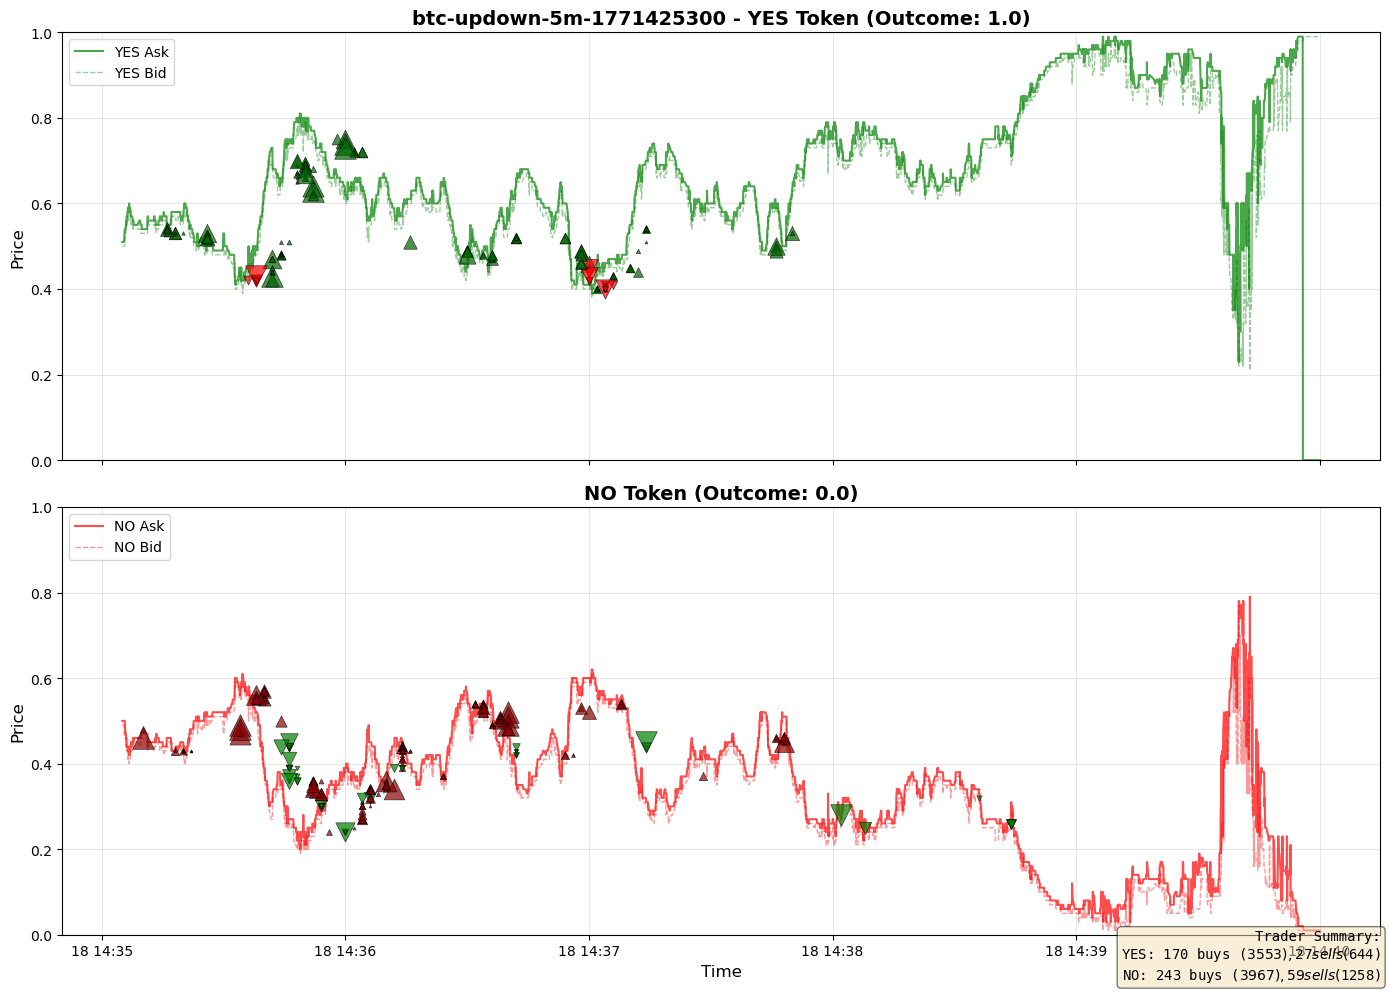


DETAILED TRADE LOG: btc-updown-5m-1771425300
2026-02-18 14:35:10+00:00 | BUY  | NO  | $   9.6 @ 0.480
2026-02-18 14:35:10+00:00 | BUY  | NO  | $ 121.0 @ 0.460
2026-02-18 14:35:16+00:00 | BUY  | YES | $  12.8 @ 0.530
2026-02-18 14:35:16+00:00 | BUY  | YES | $   0.4 @ 0.530
2026-02-18 14:35:16+00:00 | BUY  | YES | $   2.3 @ 0.530
2026-02-18 14:35:16+00:00 | BUY  | YES | $  50.7 @ 0.540
2026-02-18 14:35:16+00:00 | BUY  | YES | $   2.4 @ 0.540
2026-02-18 14:35:16+00:00 | BUY  | YES | $  11.6 @ 0.540
2026-02-18 14:35:16+00:00 | BUY  | YES | $  13.0 @ 0.540
2026-02-18 14:35:16+00:00 | BUY  | YES | $  24.6 @ 0.540
2026-02-18 14:35:16+00:00 | BUY  | YES | $   2.7 @ 0.540
2026-02-18 14:35:16+00:00 | BUY  | YES | $  10.9 @ 0.540
2026-02-18 14:35:16+00:00 | BUY  | YES | $   5.0 @ 0.540
2026-02-18 14:35:16+00:00 | BUY  | YES | $  10.0 @ 0.530
2026-02-18 14:35:18+00:00 | BUY  | NO  | $  17.5 @ 0.430
2026-02-18 14:35:18+00:00 | BUY  | YES | $   2.2 @ 0.530
2026-02-18 14:35:18+00:00 | BUY  | YES | $

In [226]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_market_with_trader_positions(
    slug: str,
    trader_activity: pd.DataFrame,
    resolutions: dict,
    data_dir: Path = Path("data")
):
    """
    Plot ask prices for YES/NO tokens over time with trader positions overlaid.
    """
    # Load book data
    book_path = data_dir / "book_snapshots" / f"{slug}.parquet"
    if not book_path.exists():
        print(f"No book data for {slug}")
        return
    
    books = pd.read_parquet(book_path)
    books["timestamp_dt"] = pd.to_datetime(books["exchange_timestamp"], unit="ms", utc=True)
    
    # Get trader's trades in this market
    trader_trades = trader_activity[trader_activity["slug"] == slug].copy()
    trader_trades["timestamp_dt"] = pd.to_datetime(trader_trades["timestamp"], unit="s", utc=True)
    
    if trader_trades.empty:
        print(f"Trader has no trades in {slug}")
        return
    
    # Get token IDs
    token_ids = list(resolutions[slug]["token_outcomes"].keys())
    token_0 = token_ids[0]
    token_1 = token_ids[1]
    
    # Determine which is YES and which is NO based on outcome
    token_0_outcome = resolutions[slug]["token_outcomes"][token_0]
    token_1_outcome = resolutions[slug]["token_outcomes"][token_1]
    
    yes_token = token_0 if token_0_outcome == 1.0 else token_1
    no_token = token_1 if token_0_outcome == 1.0 else token_0
    
    # Separate book data by token
    yes_books = books[books["asset_id"] == yes_token].sort_values("timestamp_dt")
    no_books = books[books["asset_id"] == no_token].sort_values("timestamp_dt")
    
    # Create figure
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)
    
    # Plot YES token
    ax1.plot(yes_books["timestamp_dt"], yes_books["ask_price_1"], 
             label="YES Ask", color="green", linewidth=1.5, alpha=0.7)
    ax1.plot(yes_books["timestamp_dt"], yes_books["bid_price_1"], 
             label="YES Bid", color="green", linewidth=1, alpha=0.4, linestyle="--")
    
    # Overlay trader's YES positions
    yes_trades = trader_trades[trader_trades["asset"].astype(str) == str(yes_token)]
    for _, trade in yes_trades.iterrows():
        marker = '^' if trade["side"] == "BUY" else 'v'
        color = 'darkgreen' if trade["side"] == "BUY" else 'red'
        size = float(trade["size"])
        
        ax1.scatter(trade["timestamp_dt"], float(trade["price"]), 
                   marker=marker, s=size*2, color=color, alpha=0.7,
                   edgecolors='black', linewidth=0.5, zorder=5)
    
    ax1.set_ylabel("Price", fontsize=12)
    ax1.set_title(f"{slug} - YES Token (Outcome: {token_0_outcome if yes_token == token_0 else token_1_outcome})", 
                  fontsize=14, fontweight='bold')
    ax1.legend(loc='upper left')
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0, 1)
    
    # Plot NO token
    ax2.plot(no_books["timestamp_dt"], no_books["ask_price_1"], 
             label="NO Ask", color="red", linewidth=1.5, alpha=0.7)
    ax2.plot(no_books["timestamp_dt"], no_books["bid_price_1"], 
             label="NO Bid", color="red", linewidth=1, alpha=0.4, linestyle="--")
    
    # Overlay trader's NO positions
    no_trades = trader_trades[trader_trades["asset"].astype(str) == str(no_token)]
    for _, trade in no_trades.iterrows():
        marker = '^' if trade["side"] == "BUY" else 'v'
        color = 'darkred' if trade["side"] == "BUY" else 'green'
        size = float(trade["size"])
        
        ax2.scatter(trade["timestamp_dt"], float(trade["price"]), 
                   marker=marker, s=size*2, color=color, alpha=0.7,
                   edgecolors='black', linewidth=0.5, zorder=5)
    
    ax2.set_ylabel("Price", fontsize=12)
    ax2.set_xlabel("Time", fontsize=12)
    ax2.set_title(f"NO Token (Outcome: {token_1_outcome if no_token == token_1 else token_0_outcome})", 
                  fontsize=14, fontweight='bold')
    ax2.legend(loc='upper left')
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(0, 1)
    
    # Add trade summary
    total_yes_bought = yes_trades[yes_trades["side"] == "BUY"]["size"].astype(float).sum()
    total_yes_sold = yes_trades[yes_trades["side"] == "SELL"]["size"].astype(float).sum()
    total_no_bought = no_trades[no_trades["side"] == "BUY"]["size"].astype(float).sum()
    total_no_sold = no_trades[no_trades["side"] == "SELL"]["size"].astype(float).sum()
    
    summary_text = f"Trader Summary:\n"
    summary_text += f"YES: {len(yes_trades[yes_trades['side']=='BUY'])} buys (${total_yes_bought:.0f}), "
    summary_text += f"{len(yes_trades[yes_trades['side']=='SELL'])} sells (${total_yes_sold:.0f})\n"
    summary_text += f"NO: {len(no_trades[no_trades['side']=='BUY'])} buys (${total_no_bought:.0f}), "
    summary_text += f"{len(no_trades[no_trades['side']=='SELL'])} sells (${total_no_sold:.0f})"
    
    fig.text(0.99, 0.01, summary_text, ha='right', va='bottom', 
             fontsize=10, family='monospace',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed trade log
    print(f"\n{'='*80}")
    print(f"DETAILED TRADE LOG: {slug}")
    print(f"{'='*80}")
    all_trades = trader_trades.sort_values("timestamp_dt")
    for _, trade in all_trades.iterrows():
        token_type = "YES" if str(trade["asset"]) == str(yes_token) else "NO"
        print(f"{trade['timestamp_dt']} | {trade['side']:4s} | {token_type:3s} | "
              f"${trade['size']:6.1f} @ {float(trade['price']):.3f}")
    
    print(f"\nMarket outcome: YES={token_0_outcome if yes_token == token_0 else token_1_outcome}, "
          f"NO={token_1_outcome if no_token == token_1 else token_0_outcome}")


# Find a market where the trader had significant activity
trade_counts = trader_activity.groupby("slug").size().sort_values(ascending=False)
print("Markets with most trader activity:")
print(trade_counts.head(10))

# Plot the most active market
most_active_slug = trade_counts.index[0]
print(f"\nPlotting: {most_active_slug}")
plot_market_with_trader_positions(most_active_slug, trader_activity, resolutions)

Plotting: btc-updown-5m-1771425300


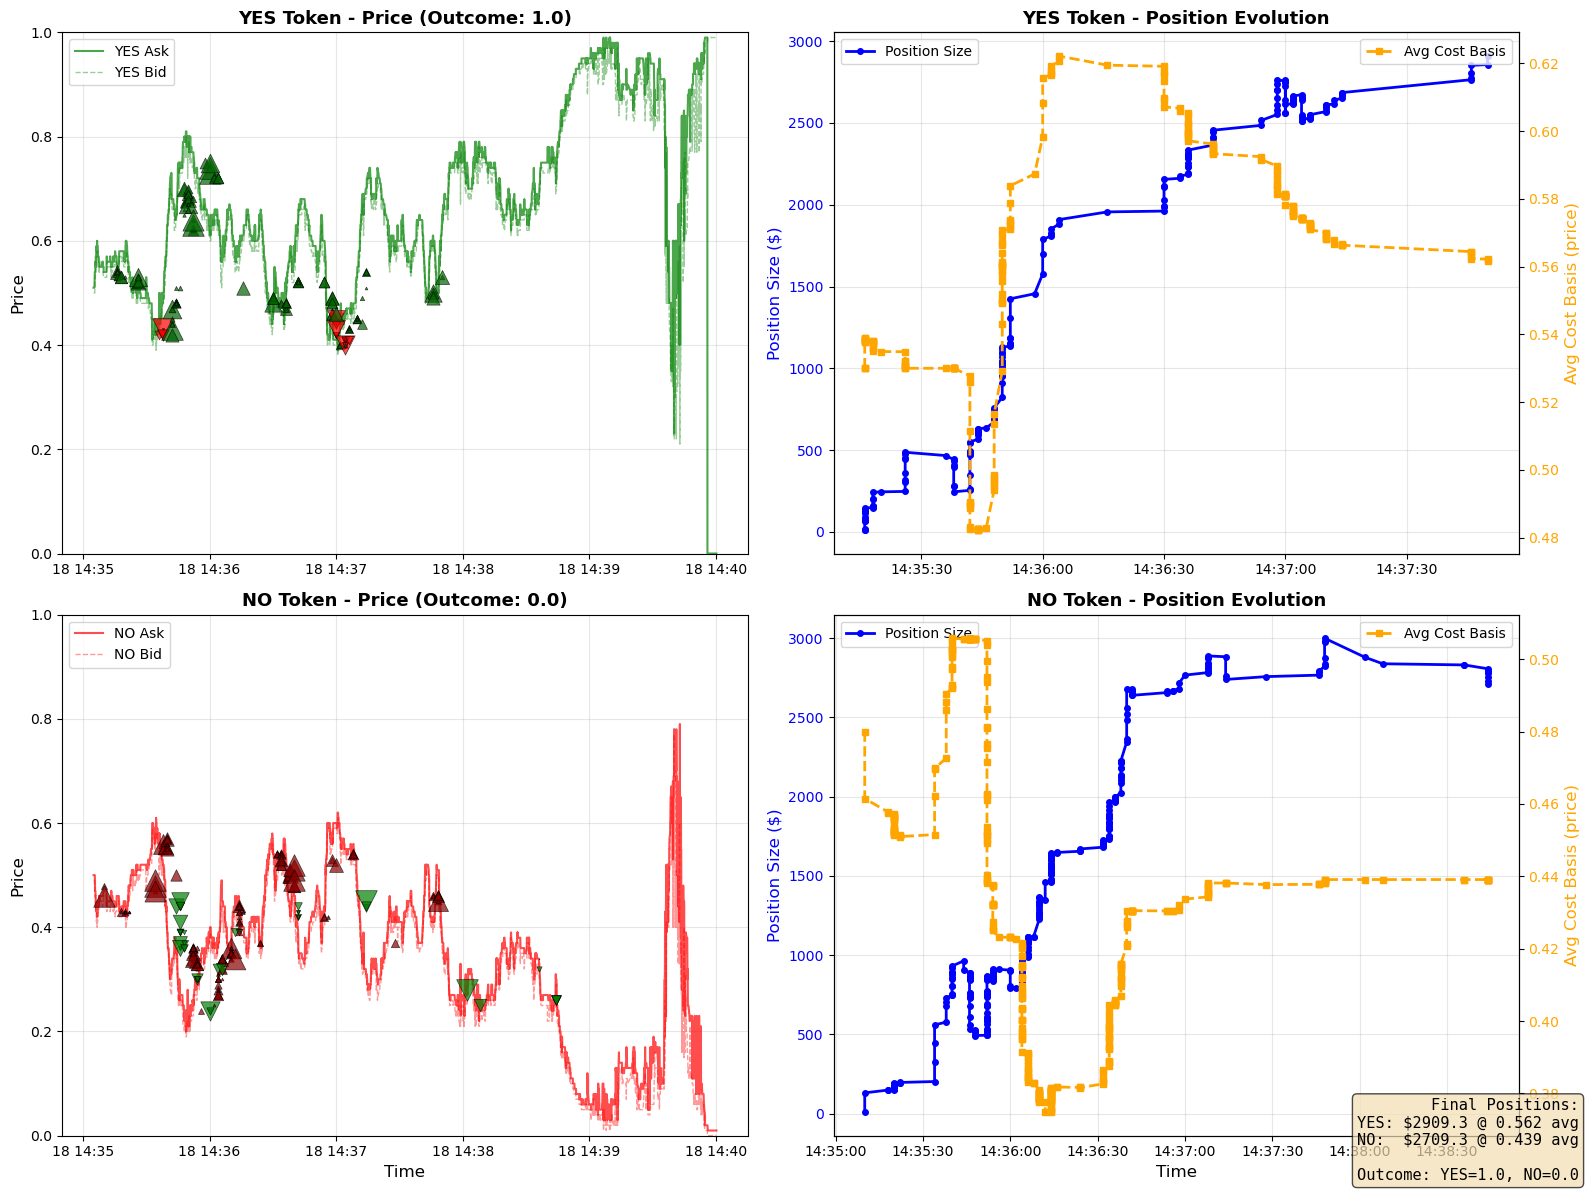


TRADE LOG: btc-updown-5m-1771425300
Time                 | Side | Token | Size     | Price  | Cum Pos  | Avg Cost
------------------------------------------------------------------------------------------
2026-02-18 14:35:10+00:00 | BUY  | NO  | $   9.6 |  0.480 | $   9.6 |  0.480
2026-02-18 14:35:10+00:00 | BUY  | NO  | $ 121.0 |  0.460 | $   9.6 |  0.480
2026-02-18 14:35:16+00:00 | BUY  | YES | $  12.8 |  0.530 | $  12.8 |  0.530
2026-02-18 14:35:16+00:00 | BUY  | YES | $   0.4 |  0.530 | $  12.8 |  0.530
2026-02-18 14:35:16+00:00 | BUY  | YES | $   2.3 |  0.530 | $  12.8 |  0.530
2026-02-18 14:35:16+00:00 | BUY  | YES | $  50.7 |  0.540 | $  12.8 |  0.530
2026-02-18 14:35:16+00:00 | BUY  | YES | $   2.4 |  0.540 | $  12.8 |  0.530
2026-02-18 14:35:16+00:00 | BUY  | YES | $  11.6 |  0.540 | $  12.8 |  0.530
2026-02-18 14:35:16+00:00 | BUY  | YES | $  13.0 |  0.540 | $  12.8 |  0.530
2026-02-18 14:35:16+00:00 | BUY  | YES | $  24.6 |  0.540 | $  12.8 |  0.530
2026-02-18 14:35:16+00:0

In [227]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_market_with_position_evolution(
    slug: str,
    trader_activity: pd.DataFrame,
    resolutions: dict,
    data_dir: Path = Path("data")
):
    """
    Plot ask prices with trader's cumulative position and cost basis evolution.
    """
    # Load book data
    book_path = data_dir / "book_snapshots" / f"{slug}.parquet"
    if not book_path.exists():
        print(f"No book data for {slug}")
        return
    
    books = pd.read_parquet(book_path)
    books["timestamp_dt"] = pd.to_datetime(books["exchange_timestamp"], unit="ms", utc=True)
    
    # Get trader's trades in this market
    trader_trades = trader_activity[trader_activity["slug"] == slug].copy()
    trader_trades["timestamp_dt"] = pd.to_datetime(trader_trades["timestamp"], unit="s", utc=True)
    
    if trader_trades.empty:
        print(f"Trader has no trades in {slug}")
        return
    
    trader_trades = trader_trades.sort_values("timestamp_dt")
    
    # Get token IDs
    token_ids = list(resolutions[slug]["token_outcomes"].keys())
    token_0 = token_ids[0]
    token_1 = token_ids[1]
    
    # Determine which is YES and which is NO based on outcome
    token_0_outcome = resolutions[slug]["token_outcomes"][token_0]
    token_1_outcome = resolutions[slug]["token_outcomes"][token_1]
    
    yes_token = token_0 if token_0_outcome == 1.0 else token_1
    no_token = token_1 if token_0_outcome == 1.0 else token_0
    
    # Separate book data by token
    yes_books = books[books["asset_id"] == yes_token].sort_values("timestamp_dt")
    no_books = books[books["asset_id"] == no_token].sort_values("timestamp_dt")
    
    # Calculate cumulative position and cost basis for each token
    yes_trades = trader_trades[trader_trades["asset"].astype(str) == str(yes_token)].copy()
    no_trades = trader_trades[trader_trades["asset"].astype(str) == str(no_token)].copy()
    
    # YES position evolution
    yes_position = []
    yes_cost_basis = []
    yes_times = []
    
    cumulative_yes = 0
    total_cost_yes = 0
    
    for _, trade in yes_trades.iterrows():
        size = float(trade["size"])
        price = float(trade["price"])
        
        if trade["side"] == "BUY":
            total_cost_yes += size * price
            cumulative_yes += size
        else:  # SELL
            if cumulative_yes > 0:
                # Reduce position at average cost
                total_cost_yes -= (total_cost_yes / cumulative_yes) * size
            cumulative_yes -= size
        
        yes_times.append(trade["timestamp_dt"])
        yes_position.append(cumulative_yes)
        yes_cost_basis.append(total_cost_yes / cumulative_yes if cumulative_yes > 0 else 0)
    
    # NO position evolution
    no_position = []
    no_cost_basis = []
    no_times = []
    
    cumulative_no = 0
    total_cost_no = 0
    
    for _, trade in no_trades.iterrows():
        size = float(trade["size"])
        price = float(trade["price"])
        
        if trade["side"] == "BUY":
            total_cost_no += size * price
            cumulative_no += size
        else:  # SELL
            if cumulative_no > 0:
                total_cost_no -= (total_cost_no / cumulative_no) * size
            cumulative_no -= size
        
        no_times.append(trade["timestamp_dt"])
        no_position.append(cumulative_no)
        no_cost_basis.append(total_cost_no / cumulative_no if cumulative_no > 0 else 0)
    
    # Create figure with 4 subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot 1: YES price and trades
    ax1.plot(yes_books["timestamp_dt"], yes_books["ask_price_1"], 
             label="YES Ask", color="green", linewidth=1.5, alpha=0.7)
    ax1.plot(yes_books["timestamp_dt"], yes_books["bid_price_1"], 
             label="YES Bid", color="green", linewidth=1, alpha=0.4, linestyle="--")
    
    # Overlay trades
    for _, trade in yes_trades.iterrows():
        marker = '^' if trade["side"] == "BUY" else 'v'
        color = 'darkgreen' if trade["side"] == "BUY" else 'red'
        size = float(trade["size"])
        ax1.scatter(trade["timestamp_dt"], float(trade["price"]), 
                   marker=marker, s=size*2, color=color, alpha=0.7,
                   edgecolors='black', linewidth=0.5, zorder=5)
    
    ax1.set_ylabel("Price", fontsize=12)
    ax1.set_title(f"YES Token - Price (Outcome: {token_0_outcome if yes_token == token_0 else token_1_outcome})", 
                  fontsize=13, fontweight='bold')
    ax1.legend(loc='upper left')
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0, 1)
    
    # Plot 2: YES position size and cost basis
    if yes_times:
        ax2_twin = ax2.twinx()
        
        ax2.plot(yes_times, yes_position, label="Position Size", 
                color="blue", linewidth=2, marker='o', markersize=4)
        ax2_twin.plot(yes_times, yes_cost_basis, label="Avg Cost Basis", 
                     color="orange", linewidth=2, linestyle='--', marker='s', markersize=4)
        
        ax2.set_ylabel("Position Size ($)", fontsize=12, color="blue")
        ax2_twin.set_ylabel("Avg Cost Basis (price)", fontsize=12, color="orange")
        ax2.tick_params(axis='y', labelcolor="blue")
        ax2_twin.tick_params(axis='y', labelcolor="orange")
        ax2.set_title("YES Token - Position Evolution", fontsize=13, fontweight='bold')
        ax2.grid(True, alpha=0.3)
        ax2.legend(loc='upper left')
        ax2_twin.legend(loc='upper right')
    
    # Plot 3: NO price and trades
    ax3.plot(no_books["timestamp_dt"], no_books["ask_price_1"], 
             label="NO Ask", color="red", linewidth=1.5, alpha=0.7)
    ax3.plot(no_books["timestamp_dt"], no_books["bid_price_1"], 
             label="NO Bid", color="red", linewidth=1, alpha=0.4, linestyle="--")
    
    # Overlay trades
    for _, trade in no_trades.iterrows():
        marker = '^' if trade["side"] == "BUY" else 'v'
        color = 'darkred' if trade["side"] == "BUY" else 'green'
        size = float(trade["size"])
        ax3.scatter(trade["timestamp_dt"], float(trade["price"]), 
                   marker=marker, s=size*2, color=color, alpha=0.7,
                   edgecolors='black', linewidth=0.5, zorder=5)
    
    ax3.set_ylabel("Price", fontsize=12)
    ax3.set_xlabel("Time", fontsize=12)
    ax3.set_title(f"NO Token - Price (Outcome: {token_1_outcome if no_token == token_1 else token_0_outcome})", 
                  fontsize=13, fontweight='bold')
    ax3.legend(loc='upper left')
    ax3.grid(True, alpha=0.3)
    ax3.set_ylim(0, 1)
    
    # Plot 4: NO position size and cost basis
    if no_times:
        ax4_twin = ax4.twinx()
        
        ax4.plot(no_times, no_position, label="Position Size", 
                color="blue", linewidth=2, marker='o', markersize=4)
        ax4_twin.plot(no_times, no_cost_basis, label="Avg Cost Basis", 
                     color="orange", linewidth=2, linestyle='--', marker='s', markersize=4)
        
        ax4.set_ylabel("Position Size ($)", fontsize=12, color="blue")
        ax4.set_xlabel("Time", fontsize=12)
        ax4_twin.set_ylabel("Avg Cost Basis (price)", fontsize=12, color="orange")
        ax4.tick_params(axis='y', labelcolor="blue")
        ax4_twin.tick_params(axis='y', labelcolor="orange")
        ax4.set_title("NO Token - Position Evolution", fontsize=13, fontweight='bold')
        ax4.grid(True, alpha=0.3)
        ax4.legend(loc='upper left')
        ax4_twin.legend(loc='upper right')
    
    # Add summary
    final_yes = yes_position[-1] if yes_position else 0
    final_no = no_position[-1] if no_position else 0
    final_yes_basis = yes_cost_basis[-1] if yes_cost_basis else 0
    final_no_basis = no_cost_basis[-1] if no_cost_basis else 0
    
    summary_text = f"Final Positions:\n"
    summary_text += f"YES: ${final_yes:.1f} @ {final_yes_basis:.3f} avg\n"
    summary_text += f"NO:  ${final_no:.1f} @ {final_no_basis:.3f} avg\n"
    summary_text += f"\nOutcome: YES={token_0_outcome if yes_token == token_0 else token_1_outcome}, "
    summary_text += f"NO={token_1_outcome if no_token == token_1 else token_0_outcome}"
    
    fig.text(0.99, 0.01, summary_text, ha='right', va='bottom', 
             fontsize=11, family='monospace',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))
    
    plt.tight_layout()
    plt.show()
    
    # Print trade log
    print(f"\n{'='*90}")
    print(f"TRADE LOG: {slug}")
    print(f"{'='*90}")
    print(f"{'Time':<20} | {'Side':<4} | {'Token':<3} | {'Size':<8} | {'Price':<6} | {'Cum Pos':<8} | {'Avg Cost':<8}")
    print(f"{'-'*90}")
    
    for _, trade in trader_trades.iterrows():
        token_type = "YES" if str(trade["asset"]) == str(yes_token) else "NO"
        
        # Find cumulative position after this trade
        if token_type == "YES":
            idx = yes_times.index(trade["timestamp_dt"])
            cum_pos = yes_position[idx]
            avg_cost = yes_cost_basis[idx]
        else:
            idx = no_times.index(trade["timestamp_dt"])
            cum_pos = no_position[idx]
            avg_cost = no_cost_basis[idx]
        
        print(f"{str(trade['timestamp_dt']):<20} | {trade['side']:<4} | {token_type:<3} | "
              f"${float(trade['size']):>6.1f} | {float(trade['price']):>6.3f} | "
              f"${cum_pos:>6.1f} | {avg_cost:>6.3f}")


# Plot the most active market
most_active_slug = trade_counts.index[0]
print(f"Plotting: {most_active_slug}")
plot_market_with_position_evolution(most_active_slug, trader_activity, resolutions)

Plotting: btc-updown-5m-1771425300


/tmp/ipykernel_170777/2003925367.py:211: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


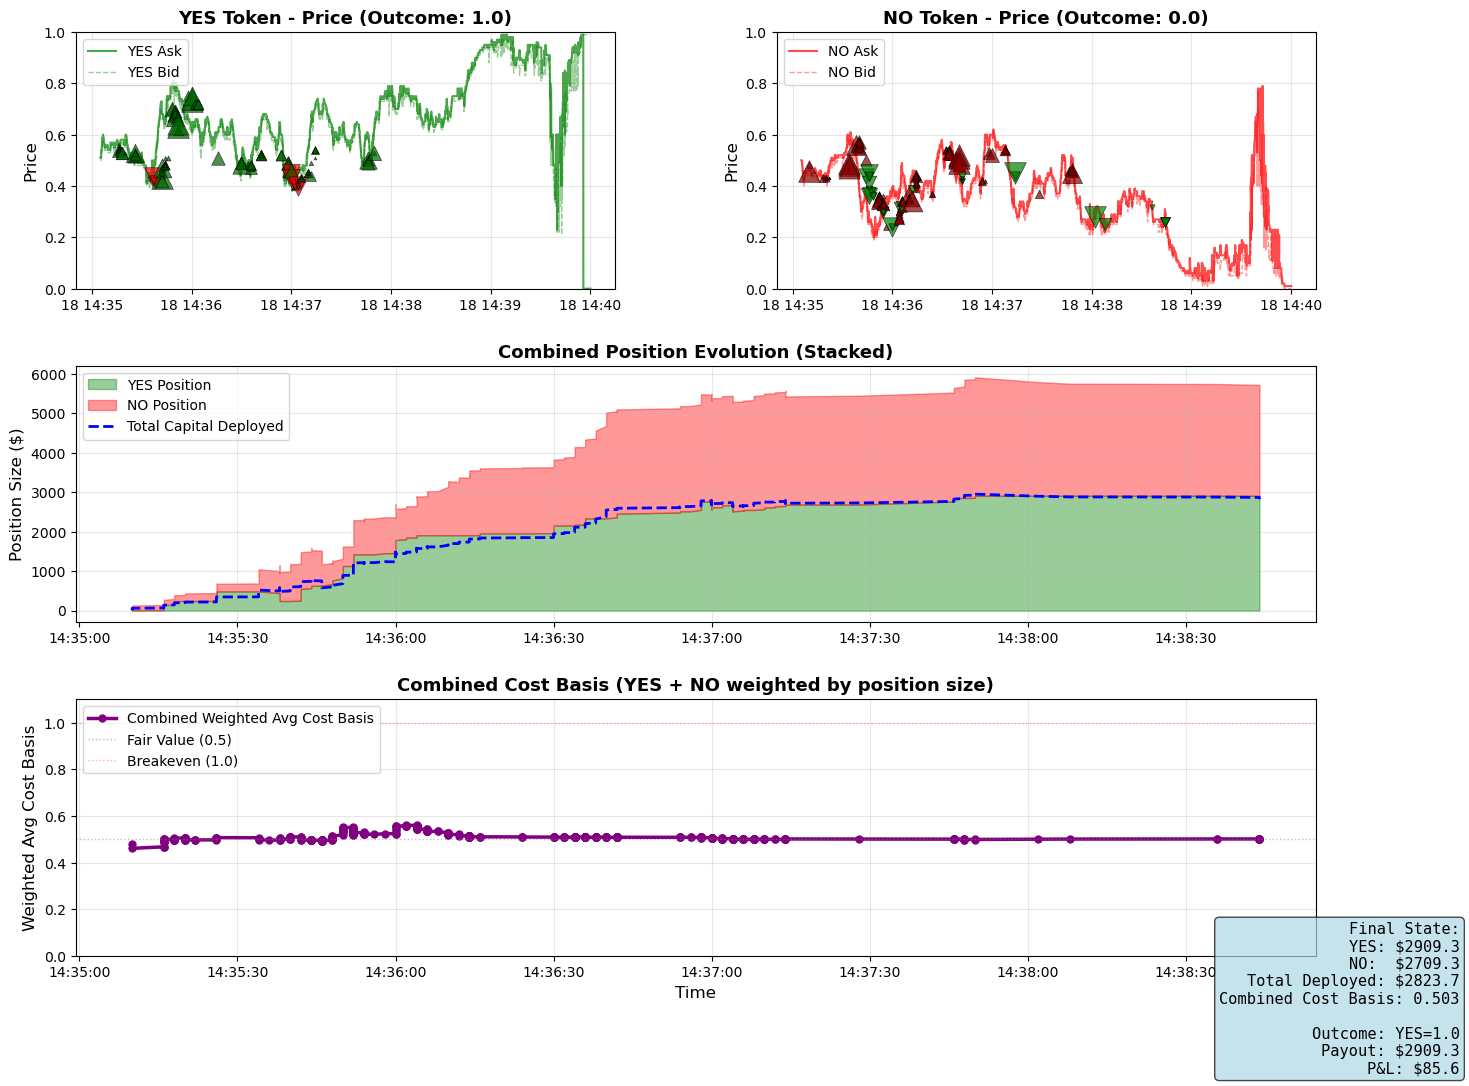


COMBINED POSITION ANALYSIS: btc-updown-5m-1771425300

Key Metrics:
  Max capital deployed: $2950.74
  Final capital deployed: $2823.70
  Combined cost basis range: 0.461 - 0.560
  Final combined cost basis: 0.503

  If combined cost basis < 1.0: Guaranteed profit at expiry
  If combined cost basis > 1.0: Guaranteed loss at expiry

Actual result: $+85.59


In [228]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_market_with_combined_position(
    slug: str,
    trader_activity: pd.DataFrame,
    resolutions: dict,
    data_dir: Path = Path("data")
):
    """
    Plot prices with trader's combined YES+NO position analysis.
    """
    # Load book data
    book_path = data_dir / "book_snapshots" / f"{slug}.parquet"
    if not book_path.exists():
        print(f"No book data for {slug}")
        return
    
    books = pd.read_parquet(book_path)
    books["timestamp_dt"] = pd.to_datetime(books["exchange_timestamp"], unit="ms", utc=True)
    
    # Get trader's trades in this market
    trader_trades = trader_activity[trader_activity["slug"] == slug].copy()
    trader_trades["timestamp_dt"] = pd.to_datetime(trader_trades["timestamp"], unit="s", utc=True)
    
    if trader_trades.empty:
        print(f"Trader has no trades in {slug}")
        return
    
    trader_trades = trader_trades.sort_values("timestamp_dt")
    
    # Get token IDs
    token_ids = list(resolutions[slug]["token_outcomes"].keys())
    token_0 = token_ids[0]
    token_1 = token_ids[1]
    
    # Determine which is YES and which is NO based on outcome
    token_0_outcome = resolutions[slug]["token_outcomes"][token_0]
    token_1_outcome = resolutions[slug]["token_outcomes"][token_1]
    
    yes_token = token_0 if token_0_outcome == 1.0 else token_1
    no_token = token_1 if token_0_outcome == 1.0 else token_0
    
    # Separate book data by token
    yes_books = books[books["asset_id"] == yes_token].sort_values("timestamp_dt")
    no_books = books[books["asset_id"] == no_token].sort_values("timestamp_dt")
    
    # Track combined position evolution
    combined_times = []
    combined_cost = []  # Total $ invested (YES + NO)
    yes_position = []
    no_position = []
    yes_cost_basis = []
    no_cost_basis = []
    
    cumulative_yes = 0
    total_cost_yes = 0
    cumulative_no = 0
    total_cost_no = 0
    
    for _, trade in trader_trades.iterrows():
        size = float(trade["size"])
        price = float(trade["price"])
        token = str(trade["asset"])
        
        if token == str(yes_token):
            if trade["side"] == "BUY":
                total_cost_yes += size * price
                cumulative_yes += size
            else:  # SELL
                if cumulative_yes > 0:
                    total_cost_yes -= (total_cost_yes / cumulative_yes) * size
                cumulative_yes -= size
        else:  # NO token
            if trade["side"] == "BUY":
                total_cost_no += size * price
                cumulative_no += size
            else:  # SELL
                if cumulative_no > 0:
                    total_cost_no -= (total_cost_no / cumulative_no) * size
                cumulative_no -= size
        
        combined_times.append(trade["timestamp_dt"])
        combined_cost.append(total_cost_yes + total_cost_no)
        yes_position.append(cumulative_yes)
        no_position.append(cumulative_no)
        yes_cost_basis.append(total_cost_yes / cumulative_yes if cumulative_yes > 0 else 0)
        no_cost_basis.append(total_cost_no / cumulative_no if cumulative_no > 0 else 0)
    
    # Calculate combined cost basis (weighted average)
    combined_cost_basis = []
    for i in range(len(combined_times)):
        total_shares = yes_position[i] + no_position[i]
        if total_shares > 0:
            weighted_cost = (yes_position[i] * yes_cost_basis[i] + no_position[i] * no_cost_basis[i]) / total_shares
            combined_cost_basis.append(weighted_cost)
        else:
            combined_cost_basis.append(0)
    
    # Create figure
    fig = plt.figure(figsize=(16, 12))
    gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)
    
    ax1 = fig.add_subplot(gs[0, 0])  # YES price
    ax2 = fig.add_subplot(gs[0, 1])  # NO price
    ax3 = fig.add_subplot(gs[1, :])  # Combined position
    ax4 = fig.add_subplot(gs[2, :])  # Combined cost basis
    
    # Plot 1: YES price and trades
    ax1.plot(yes_books["timestamp_dt"], yes_books["ask_price_1"], 
             label="YES Ask", color="green", linewidth=1.5, alpha=0.7)
    ax1.plot(yes_books["timestamp_dt"], yes_books["bid_price_1"], 
             label="YES Bid", color="green", linewidth=1, alpha=0.4, linestyle="--")
    
    yes_trades = trader_trades[trader_trades["asset"].astype(str) == str(yes_token)]
    for _, trade in yes_trades.iterrows():
        marker = '^' if trade["side"] == "BUY" else 'v'
        color = 'darkgreen' if trade["side"] == "BUY" else 'red'
        size = float(trade["size"])
        ax1.scatter(trade["timestamp_dt"], float(trade["price"]), 
                   marker=marker, s=size*2, color=color, alpha=0.7,
                   edgecolors='black', linewidth=0.5, zorder=5)
    
    ax1.set_ylabel("Price", fontsize=12)
    ax1.set_title(f"YES Token - Price (Outcome: {token_0_outcome if yes_token == token_0 else token_1_outcome})", 
                  fontsize=13, fontweight='bold')
    ax1.legend(loc='upper left')
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0, 1)
    
    # Plot 2: NO price and trades
    ax2.plot(no_books["timestamp_dt"], no_books["ask_price_1"], 
             label="NO Ask", color="red", linewidth=1.5, alpha=0.7)
    ax2.plot(no_books["timestamp_dt"], no_books["bid_price_1"], 
             label="NO Bid", color="red", linewidth=1, alpha=0.4, linestyle="--")
    
    no_trades = trader_trades[trader_trades["asset"].astype(str) == str(no_token)]
    for _, trade in no_trades.iterrows():
        marker = '^' if trade["side"] == "BUY" else 'v'
        color = 'darkred' if trade["side"] == "BUY" else 'green'
        size = float(trade["size"])
        ax2.scatter(trade["timestamp_dt"], float(trade["price"]), 
                   marker=marker, s=size*2, color=color, alpha=0.7,
                   edgecolors='black', linewidth=0.5, zorder=5)
    
    ax2.set_ylabel("Price", fontsize=12)
    ax2.set_title(f"NO Token - Price (Outcome: {token_1_outcome if no_token == token_1 else token_0_outcome})", 
                  fontsize=13, fontweight='bold')
    ax2.legend(loc='upper left')
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(0, 1)
    
    # Plot 3: Combined position (stacked area)
    if combined_times:
        ax3.fill_between(combined_times, 0, yes_position, 
                        label="YES Position", color="green", alpha=0.4)
        ax3.fill_between(combined_times, yes_position, 
                        [y + n for y, n in zip(yes_position, no_position)],
                        label="NO Position", color="red", alpha=0.4)
        ax3.plot(combined_times, combined_cost, 
                label="Total Capital Deployed", color="blue", linewidth=2, linestyle='--')
        
        ax3.set_ylabel("Position Size ($)", fontsize=12)
        ax3.set_title("Combined Position Evolution (Stacked)", fontsize=13, fontweight='bold')
        ax3.legend(loc='upper left')
        ax3.grid(True, alpha=0.3)
    
    # Plot 4: Combined cost basis
    if combined_times:
        ax4.plot(combined_times, combined_cost_basis, 
                label="Combined Weighted Avg Cost Basis", 
                color="purple", linewidth=2.5, marker='o', markersize=5)
        ax4.axhline(y=0.5, color='gray', linestyle=':', linewidth=1, alpha=0.5, label="Fair Value (0.5)")
        ax4.axhline(y=1.0, color='red', linestyle=':', linewidth=1, alpha=0.3, label="Breakeven (1.0)")
        
        ax4.set_ylabel("Weighted Avg Cost Basis", fontsize=12)
        ax4.set_xlabel("Time", fontsize=12)
        ax4.set_title("Combined Cost Basis (YES + NO weighted by position size)", fontsize=13, fontweight='bold')
        ax4.legend(loc='upper left')
        ax4.grid(True, alpha=0.3)
        ax4.set_ylim(0, 1.1)
    
    # Add summary
    final_yes = yes_position[-1] if yes_position else 0
    final_no = no_position[-1] if no_position else 0
    final_combined_cost = combined_cost[-1] if combined_cost else 0
    final_combined_basis = combined_cost_basis[-1] if combined_cost_basis else 0
    
    # Calculate final P&L
    yes_payout = final_yes * (1.0 if token_0_outcome == 1.0 and yes_token == token_0 else 
                              1.0 if token_1_outcome == 1.0 and yes_token == token_1 else 0.0)
    no_payout = final_no * (1.0 if token_1_outcome == 1.0 and no_token == token_1 else 
                           1.0 if token_0_outcome == 1.0 and no_token == token_0 else 0.0)
    total_payout = yes_payout + no_payout
    pnl = total_payout - final_combined_cost
    
    summary_text = f"Final State:\n"
    summary_text += f"YES: ${final_yes:.1f}\n"
    summary_text += f"NO:  ${final_no:.1f}\n"
    summary_text += f"Total Deployed: ${final_combined_cost:.1f}\n"
    summary_text += f"Combined Cost Basis: {final_combined_basis:.3f}\n"
    summary_text += f"\nOutcome: YES={token_0_outcome if yes_token == token_0 else token_1_outcome}\n"
    summary_text += f"Payout: ${total_payout:.1f}\n"
    summary_text += f"P&L: ${pnl:.1f}"
    
    fig.text(0.99, 0.01, summary_text, ha='right', va='bottom', 
             fontsize=11, family='monospace',
             bbox=dict(boxstyle='round', facecolor='lightblue' if pnl > 0 else 'lightcoral', alpha=0.7))
    
    plt.tight_layout()
    plt.show()
    
    # Print summary table
    print(f"\n{'='*80}")
    print(f"COMBINED POSITION ANALYSIS: {slug}")
    print(f"{'='*80}")
    print(f"\nKey Metrics:")
    print(f"  Max capital deployed: ${max(combined_cost):.2f}")
    print(f"  Final capital deployed: ${final_combined_cost:.2f}")
    print(f"  Combined cost basis range: {min(combined_cost_basis):.3f} - {max(combined_cost_basis):.3f}")
    print(f"  Final combined cost basis: {final_combined_basis:.3f}")
    print(f"\n  If combined cost basis < 1.0: Guaranteed profit at expiry")
    print(f"  If combined cost basis > 1.0: Guaranteed loss at expiry")
    print(f"\nActual result: ${pnl:+.2f}")


# Plot the most active market
most_active_slug = trade_counts.index[0]
print(f"Plotting: {most_active_slug}")
plot_market_with_combined_position(most_active_slug, trader_activity, resolutions)

In [229]:
def analyze_combined_basis_strategy(trader_activity, resolutions):
    """Check if they consistently maintain combined cost basis < 1.0"""
    
    results = []
    skipped_negative = 0
    
    for slug in trader_activity["slug"].unique():
        trades = trader_activity[trader_activity["slug"] == slug].sort_values("timestamp")
        
        if slug not in resolutions:
            continue
        
        token_outcomes = resolutions[slug]["token_outcomes"]
        token_ids = list(token_outcomes.keys())
        
        # Track position evolution (in shares)
        positions_shares = {tid: 0.0 for tid in token_ids}
        total_cost_usd = {tid: 0.0 for tid in token_ids}
        
        min_combined_basis = float('inf')
        max_combined_basis = 0
        final_combined_basis = 0
        went_negative = False
        
        for _, trade in trades.iterrows():
            token = str(trade.get("asset", ""))
            
            # Skip if missing asset ID or not in our token list
            if not token or token not in token_ids:
                continue
            
            # Skip if missing required fields
            if pd.isna(trade.get("size")) or pd.isna(trade.get("price")):
                continue
            
            shares = float(trade["size"])
            price = float(trade["price"])
            side = trade.get("side", "")
            
            if side == "BUY":
                cost = shares * price
                total_cost_usd[token] += cost
                positions_shares[token] += shares
                
            elif side == "SELL":
                if positions_shares[token] >= shares - 0.01:
                    cost_per_share = total_cost_usd[token] / positions_shares[token] if positions_shares[token] > 0 else 0
                    total_cost_usd[token] -= cost_per_share * shares
                    positions_shares[token] -= shares
                else:
                    went_negative = True
                    break
            else:
                continue
            
            # Calculate combined cost basis
            total_shares = sum(positions_shares.values())
            total_spent = sum(total_cost_usd.values())
            
            if total_shares > 0:
                combined_basis = total_spent / total_shares
                min_combined_basis = min(min_combined_basis, combined_basis)
                max_combined_basis = max(max_combined_basis, combined_basis)
                final_combined_basis = combined_basis
        
        # Skip if position went negative
        if went_negative:
            skipped_negative += 1
            continue
        
        # Calculate actual P&L
        final_pnl = 0
        for token_id in token_ids:
            outcome = token_outcomes[token_id]
            shares = positions_shares[token_id]
            cost = total_cost_usd[token_id]
            payout = shares * outcome
            final_pnl += payout - cost
        
        total_final_shares = sum(positions_shares.values())
        
        # Skip if no final position
        if total_final_shares < 0.01:
            continue
        
        results.append({
            "slug": slug,
            "min_basis": min_combined_basis if min_combined_basis != float('inf') else 0,
            "max_basis": max_combined_basis,
            "final_basis": final_combined_basis,
            "guaranteed_edge": 1.0 - final_combined_basis,
            "actual_pnl": final_pnl,
            "total_shares_held": total_final_shares,
        })
    
    df = pd.DataFrame(results)
    
    print(f"\n{'='*80}")
    print(f"COMBINED COST BASIS ANALYSIS ACROSS ALL MARKETS")
    print(f"{'='*80}")
    print(f"\nMarkets analyzed: {len(df)}")
    print(f"Markets skipped (incomplete data): {skipped_negative}")
    
    if len(df) > 0:
        print(f"Markets with final basis < 1.0: {(df['final_basis'] < 1.0).sum()} ({(df['final_basis'] < 1.0).sum() / len(df) * 100:.1f}%)")
        print(f"Markets with final basis > 1.0: {(df['final_basis'] > 1.0).sum()} ({(df['final_basis'] > 1.0).sum() / len(df) * 100:.1f}%)")
        
        print(f"\nCombined Cost Basis Statistics:")
        print(f"  Mean final basis: {df['final_basis'].mean():.3f}")
        print(f"  Median final basis: {df['final_basis'].median():.3f}")
        print(f"  Min final basis: {df['final_basis'].min():.3f}")
        print(f"  Max final basis: {df['final_basis'].max():.3f}")
        print(f"  Std dev: {df['final_basis'].std():.3f}")
        
        print(f"\nGuaranteed Edge Statistics:")
        print(f"  Mean guaranteed edge: {df['guaranteed_edge'].mean():.3f} ({df['guaranteed_edge'].mean() * 100:.1f}%)")
        print(f"  Median guaranteed edge: {df['guaranteed_edge'].median():.3f} ({df['guaranteed_edge'].median() * 100:.1f}%)")
        
        under_1 = df[df['final_basis'] < 1.0]
        over_1 = df[df['final_basis'] >= 1.0]
        
        print(f"\nP&L Comparison:")
        if not under_1.empty:
            print(f"  Markets with basis < 1.0: ${under_1['actual_pnl'].sum():.2f} (avg ${under_1['actual_pnl'].mean():.2f})")
        if not over_1.empty:
            print(f"  Markets with basis >= 1.0: ${over_1['actual_pnl'].sum():.2f} (avg ${over_1['actual_pnl'].mean():.2f})")
        
        print(f"\nCost Basis Distribution:")
        print(f"  < 0.30: {(df['final_basis'] < 0.30).sum()}")
        print(f"  0.30-0.50: {((df['final_basis'] >= 0.30) & (df['final_basis'] < 0.50)).sum()}")
        print(f"  0.50-0.70: {((df['final_basis'] >= 0.50) & (df['final_basis'] < 0.70)).sum()}")
        print(f"  0.70-1.00: {((df['final_basis'] >= 0.70) & (df['final_basis'] < 1.00)).sum()}")
        print(f"  >= 1.00: {(df['final_basis'] >= 1.0).sum()}")
    
    return df

In [230]:
# Check the markets with "negative" positions
problem_slug = "btc-updown-5m-1771425300"  # The one with -120 shares
problem_trades = trader_activity[trader_activity["slug"] == problem_slug].sort_values("timestamp")

print(f"\n{'='*80}")
print(f"Debugging: {problem_slug}")
print(f"{'='*80}")

token_ids = list(resolutions[problem_slug]["token_outcomes"].keys())
print(f"Token IDs: {[tid[:20]+'...' for tid in token_ids]}")
print(f"Outcomes: {resolutions[problem_slug]['token_outcomes']}")

print(f"\nAll trades:")
print(f"{'Time':<20} {'Side':<4} {'Token':<20} {'Shares':<10} {'Price':<8}")
print("-" * 80)

positions = {tid: 0.0 for tid in token_ids}

for _, trade in problem_trades.iterrows():
    token = str(trade["asset"])
    token_short = token[:20] + "..."
    shares = float(trade["size"])
    price = float(trade["price"])
    side = trade["side"]
    
    if side == "BUY":
        positions[token] += shares
    else:
        positions[token] -= shares
    
    print(f"{str(trade['timestamp_dt']):<20} {side:<4} {token_short:<20} {shares:<10.2f} {price:<8.4f}")
    print(f"  -> Position now: {positions[token]:.2f}")

print(f"\nFinal positions:")
for tid, pos in positions.items():
    print(f"  {tid[:20]}...: {pos:.2f} shares")

print(f"\nTotal shares across both tokens: {sum(positions.values()):.2f}")


Debugging: btc-updown-5m-1771425300
Token IDs: ['34758214432074926440...', '65834433149610239096...']
Outcomes: {'34758214432074926440535591900924285930678772267223833719313344673435442500326': 1.0, '65834433149610239096188599267403124144525780627093567984384946811042357296955': 0.0}

All trades:
Time                 Side Token                Shares     Price   
--------------------------------------------------------------------------------
2026-02-18 14:35:10+00:00 BUY  65834433149610239096... 9.62       0.4800  
  -> Position now: 9.62
2026-02-18 14:35:10+00:00 BUY  65834433149610239096... 121.00     0.4600  
  -> Position now: 130.62
2026-02-18 14:35:16+00:00 BUY  34758214432074926440... 50.74      0.5400  
  -> Position now: 50.74
2026-02-18 14:35:16+00:00 BUY  34758214432074926440... 2.34       0.5300  
  -> Position now: 53.08
2026-02-18 14:35:16+00:00 BUY  34758214432074926440... 12.77      0.5300  
  -> Position now: 65.85
2026-02-18 14:35:16+00:00 BUY  34758214432074926440..

In [231]:
# Check if the same token ID appears in multiple markets
token_id = "65834433149610239096188599267403124144525780627093567984384946811042357296955"

markets_with_token = []
for slug, res in resolutions.items():
    if token_id in res["token_outcomes"]:
        markets_with_token.append(slug)

print(f"Token {token_id[:20]}... appears in {len(markets_with_token)} markets:")
for slug in markets_with_token[:10]:
    print(f"  {slug}")

# Check trader's trades for this token across ALL slugs
all_token_trades = trader_activity[trader_activity["asset"].astype(str) == token_id].sort_values("timestamp")
print(f"\nTrader has {len(all_token_trades)} trades with this token across {all_token_trades['slug'].nunique()} different markets")
print("\nMarkets where they traded this token:")
print(all_token_trades['slug'].value_counts().head(10))

Token 65834433149610239096... appears in 1 markets:
  btc-updown-5m-1771425300

Trader has 302 trades with this token across 1 different markets

Markets where they traded this token:
slug
btc-updown-5m-1771425300    302
Name: count, dtype: int64


In [232]:
# Check if any market has suspiciously few trades given their position sizes
position_analysis = []

for slug in trader_activity["slug"].unique()[:20]:  # Sample first 20
    trades = trader_activity[trader_activity["slug"] == slug]
    
    if slug not in resolutions:
        continue
    
    token_ids = list(resolutions[slug]["token_outcomes"].keys())
    
    net_buys = trades[trades["side"] == "BUY"]["size"].astype(float).sum()
    net_sells = trades[trades["side"] == "SELL"]["size"].astype(float).sum()
    
    position_analysis.append({
        "slug": slug,
        "num_trades": len(trades),
        "total_buys": net_buys,
        "total_sells": net_sells,
        "net_position": net_buys - net_sells,
        "sell_ratio": net_sells / net_buys if net_buys > 0 else 0,
    })

df_analysis = pd.DataFrame(position_analysis)
print("\nMarkets where sells > buys:")
oversold = df_analysis[df_analysis["sell_ratio"] > 1.0].sort_values("sell_ratio", ascending=False)
print(oversold.to_string(index=False))

print(f"\nOut of {len(df_analysis)} markets checked:")
print(f"  Markets with more sells than buys: {len(oversold)}")
print(f"  Percentage: {len(oversold) / len(df_analysis) * 100:.1f}%")


Markets where sells > buys:
Empty DataFrame
Columns: [slug, num_trades, total_buys, total_sells, net_position, sell_ratio]
Index: []

Out of 20 markets checked:
  Markets with more sells than buys: 0
  Percentage: 0.0%


In [233]:
trader_activity[['timestamp', 'conditionId', 'type', 'size', 'usdcSize',
       'price', 'asset', 'side', 'outcomeIndex', 
       'slug', 'outcome', 'name', 
       'timestamp_dt', 'pnl',
       'price_float', 'hour']]

,timestamp,conditionId,type,size,usdcSize,price,asset,side,outcomeIndex,slug,outcome,name,timestamp_dt,pnl,price_float,hour
0,1771433612,0x0b69f721b757bfa62cd35d064c7b885de97b5768adb9...,TRADE,2.696330,0.269633,0.10,6518516777452607742790513427203758251193440489...,BUY,0,btc-updown-5m-1771433400,0.0,0x8dxd,2026-02-18 16:53:32+00:00,-0.269633,0.10,16
1,1771433584,0x0b69f721b757bfa62cd35d064c7b885de97b5768adb9...,TRADE,10.960445,1.205649,0.11,6518516777452607742790513427203758251193440489...,BUY,0,btc-updown-5m-1771433400,0.0,0x8dxd,2026-02-18 16:53:04+00:00,-1.205649,0.11,16
2,1771433542,0x0b69f721b757bfa62cd35d064c7b885de97b5768adb9...,TRADE,121.000000,85.910000,0.71,4241675980853882240346247653879160971087116733...,BUY,1,btc-updown-5m-1771433400,1.0,0x8dxd,2026-02-18 16:52:22+00:00,35.090000,0.71,16
3,1771433542,0x0b69f721b757bfa62cd35d064c7b885de97b5768adb9...,TRADE,121.000000,84.700000,0.70,4241675980853882240346247653879160971087116733...,BUY,1,btc-updown-5m-1771433400,1.0,0x8dxd,2026-02-18 16:52:22+00:00,36.300000,0.70,16
4,1771433542,0x0b69f721b757bfa62cd35d064c7b885de97b5768adb9...,TRADE,121.000000,83.490000,0.69,4241675980853882240346247653879160971087116733...,BUY,1,btc-updown-5m-1771433400,1.0,0x8dxd,2026-02-18 16:52:22+00:00,37.510000,0.69,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161094,1771586110,0x8923f99b1c684966fce58ded61cf5d2fbee85d09bb32...,TRADE,61.221400,32.338800,0.52,6186596948434989693025437142798161795517516034...,BUY,1,btc-updown-5m-1771586100,1.0,0x8dxd,2026-02-20 11:15:10+00:00,29.386272,0.52,11
161095,1771586108,0x8923f99b1c684966fce58ded61cf5d2fbee85d09bb32...,TRADE,92.620000,49.088600,0.53,5697761005677280856183176911880094239178944487...,BUY,0,btc-updown-5m-1771586100,0.0,0x8dxd,2026-02-20 11:15:08+00:00,-49.088600,0.53,11
161096,1771586108,0x8923f99b1c684966fce58ded61cf5d2fbee85d09bb32...,TRADE,5.191488,2.751489,0.53,5697761005677280856183176911880094239178944487...,BUY,0,btc-updown-5m-1771586100,0.0,0x8dxd,2026-02-20 11:15:08+00:00,-2.751489,0.53,11
161097,1771586108,0x8923f99b1c684966fce58ded61cf5d2fbee85d09bb32...,TRADE,0.637658,0.337959,0.53,5697761005677280856183176911880094239178944487...,BUY,0,btc-updown-5m-1771586100,0.0,0x8dxd,2026-02-20 11:15:08+00:00,-0.337959,0.53,11


In [234]:
for slug in trader_activity['slug'].unique():
    trades = trader_activity[trader_activity["slug"] == slug].sort_values("timestamp")
    if slug not in resolutions:
        continue
    token_outcomes = resolutions[slug]['token_outcomes']
    token_ids = list(token_outcomes.keys())
    positions_shares = {tid: 0.0 for tid in token_ids}
    total_cost_usd = {tid: 0.0 for tid in token_ids}

    min_combined_basis = float('inf')
    max_combined_basis = 0
    final_combined_basis = 0
    went_negative = False

    for _, trade in trades.iterrows():
        token = str(trade["asset"])
        shares = float(trade["size"])
        price = float(trade["price"])
        cost = shares * price
            
        if trade["side"] == "BUY":
            total_cost_usd[token] += cost
            positions_shares[token] += shares
        else:  # SELL
            if positions_shares[token] > 0:
                cost_per_share = total_cost_usd[token] / positions_shares[token]
                total_cost_usd[token] -= cost_per_share * shares
                positions_shares[token] -= shares
            else:
                    # Going negative - incomplete data
                went_negative = True
                break
            
            # Calculate combined cost basis
        total_shares = sum(positions_shares.values())
        total_spent = sum(total_cost_usd.values())
            
        if total_shares > 0:
            combined_basis = total_spent / total_shares
            min_combined_basis = min(min_combined_basis, combined_basis)
            max_combined_basis = max(max_combined_basis, combined_basis)
            final_combined_basis = combined_basis


In [235]:
def analyze_combined_basis_strategy(trader_activity, resolutions):
    """
    Check if they're executing true cost-basis arbitrage.
    True arbitrage requires BOTH tokens to have enough shares to cover total investment.
    """
    
    results = []
    skipped_negative = 0
    
    for slug in trader_activity["slug"].unique():
        trades = trader_activity[trader_activity["slug"] == slug].sort_values("timestamp")
        
        if slug not in resolutions:
            continue
        
        token_outcomes = resolutions[slug]["token_outcomes"]
        token_ids = list(token_outcomes.keys())
        
        if len(token_ids) != 2:
            continue  # Need exactly 2 tokens for binary market
        
        # Track position evolution
        positions_shares = {tid: 0.0 for tid in token_ids}
        total_capital_invested = 0.0  # Net capital at risk
        
        went_negative = False
        
        # Track arbitrage metrics over time
        arbitrage_windows = []
        
        for _, trade in trades.iterrows():
            token = str(trade.get("asset", ""))
            
            if not token or token not in token_ids:
                continue
            
            if pd.isna(trade.get("size")) or pd.isna(trade.get("price")):
                continue
            
            shares = float(trade["size"])
            price = float(trade["price"])
            side = trade.get("side", "")
            
            if side == "BUY":
                cost = shares * price
                total_capital_invested += cost
                positions_shares[token] += shares
                
            elif side == "SELL":
                if positions_shares[token] >= shares:
                    proceeds = shares * price
                    total_capital_invested -= proceeds
                    positions_shares[token] -= shares
                else:
                    went_negative = True
                    break
            else:
                continue
            
            # Check arbitrage condition: BOTH tokens must have enough shares
            token_0_shares = positions_shares[token_ids[0]]
            token_1_shares = positions_shares[token_ids[1]]
            
            is_arbitrage = (
                token_0_shares > total_capital_invested and
                token_1_shares > total_capital_invested
            )
            
            if is_arbitrage:
                # Calculate guaranteed profit for each outcome
                profit_if_0_wins = token_0_shares - total_capital_invested
                profit_if_1_wins = token_1_shares - total_capital_invested
                min_guaranteed_profit = min(profit_if_0_wins, profit_if_1_wins)
                
                arbitrage_windows.append({
                    "capital": total_capital_invested,
                    "token_0_shares": token_0_shares,
                    "token_1_shares": token_1_shares,
                    "guaranteed_profit": min_guaranteed_profit,
                    "profit_pct": min_guaranteed_profit / total_capital_invested if total_capital_invested > 0 else 0,
                })
        
        if went_negative:
            skipped_negative += 1
            continue
        
        # Final position analysis
        token_0_shares = positions_shares[token_ids[0]]
        token_1_shares = positions_shares[token_ids[1]]
        
        # Skip if no position
        if token_0_shares < 1e-6 and token_1_shares < 1e-6:
            continue
        
        # Calculate actual P&L
        token_0_outcome = token_outcomes[token_ids[0]]
        token_1_outcome = token_outcomes[token_ids[1]]
        
        actual_payout = token_0_shares * token_0_outcome + token_1_shares * token_1_outcome
        actual_pnl = actual_payout - total_capital_invested
        
        # Determine if final position was arbitrage
        final_is_arbitrage = (
            token_0_shares > total_capital_invested and
            token_1_shares > total_capital_invested
        )
        
        if final_is_arbitrage:
            profit_if_0_wins = token_0_shares - total_capital_invested
            profit_if_1_wins = token_1_shares - total_capital_invested
            guaranteed_profit = min(profit_if_0_wins, profit_if_1_wins)
            guaranteed_profit_pct = guaranteed_profit / total_capital_invested if total_capital_invested > 0 else 0
        else:
            guaranteed_profit = 0
            guaranteed_profit_pct = 0
        
        results.append({
            "slug": slug,
            "capital_invested": total_capital_invested,
            "token_0_shares": token_0_shares,
            "token_1_shares": token_1_shares,
            "final_is_arbitrage": final_is_arbitrage,
            "guaranteed_profit": guaranteed_profit,
            "guaranteed_profit_pct": guaranteed_profit_pct,
            "actual_pnl": actual_pnl,
            "had_arbitrage_window": len(arbitrage_windows) > 0,
            "max_arbitrage_profit_pct": max([w["profit_pct"] for w in arbitrage_windows]) if arbitrage_windows else 0,
        })
    
    df = pd.DataFrame(results)
    
    print(f"\n{'='*80}")
    print(f"TRUE COST-BASIS ARBITRAGE ANALYSIS")
    print(f"{'='*80}")
    print(f"\nMarkets analyzed: {len(df)}")
    print(f"Markets skipped (incomplete data): {skipped_negative}")
    
    if len(df) > 0:
        arb_markets = df[df["final_is_arbitrage"] == True]
        non_arb_markets = df[df["final_is_arbitrage"] == False]
        
        print(f"\nFinal Position Analysis:")
        print(f"  True arbitrage positions: {len(arb_markets)} ({len(arb_markets)/len(df)*100:.1f}%)")
        print(f"  Directional positions: {len(non_arb_markets)} ({len(non_arb_markets)/len(df)*100:.1f}%)")
        
        if not arb_markets.empty:
            print(f"\nTrue Arbitrage Positions:")
            print(f"  Mean guaranteed profit: ${arb_markets['guaranteed_profit'].mean():.2f}")
            print(f"  Median guaranteed profit: ${arb_markets['guaranteed_profit'].median():.2f}")
            print(f"  Mean guaranteed profit %: {arb_markets['guaranteed_profit_pct'].mean()*100:.2f}%")
            print(f"  Median guaranteed profit %: {arb_markets['guaranteed_profit_pct'].median()*100:.2f}%")
            print(f"  Total P&L: ${arb_markets['actual_pnl'].sum():.2f}")
            print(f"  Average P&L: ${arb_markets['actual_pnl'].mean():.2f}")
        
        if not non_arb_markets.empty:
            print(f"\nDirectional Positions:")
            print(f"  Total P&L: ${non_arb_markets['actual_pnl'].sum():.2f}")
            print(f"  Average P&L: ${non_arb_markets['actual_pnl'].mean():.2f}")
            print(f"  Win rate: {(non_arb_markets['actual_pnl'] > 0).sum() / len(non_arb_markets) * 100:.1f}%")
        
        # Markets that had arbitrage at some point
        had_arb = df[df["had_arbitrage_window"] == True]
        print(f"\nMarkets with arbitrage opportunity during trading:")
        print(f"  Count: {len(had_arb)} ({len(had_arb)/len(df)*100:.1f}%)")
        if not had_arb.empty:
            print(f"  Max arbitrage profit % seen: {had_arb['max_arbitrage_profit_pct'].mean()*100:.2f}%")
    
    return df

analysis_df = analyze_combined_basis_strategy(trader_activity, resolutions)


TRUE COST-BASIS ARBITRAGE ANALYSIS

Markets analyzed: 1327
Markets skipped (incomplete data): 6

Final Position Analysis:
  True arbitrage positions: 289 (21.8%)
  Directional positions: 1038 (78.2%)

True Arbitrage Positions:
  Mean guaranteed profit: $91.16
  Median guaranteed profit: $61.73
  Mean guaranteed profit %: 10.21%
  Median guaranteed profit %: 7.37%
  Total P&L: $40944.61
  Average P&L: $141.68

Directional Positions:
  Total P&L: $-13815.09
  Average P&L: $-13.31
  Win rate: 38.8%

Markets with arbitrage opportunity during trading:
  Count: 819 (61.7%)
  Max arbitrage profit % seen: 10.67%


In [236]:
def analyze_arbitrage_exits(trader_activity, resolutions):
    """
    Analyze when traders exit cost-basis arbitrage positions.
    Track the lifecycle: building arb → holding arb → exiting arb
    """
    
    exit_analysis = []
    
    for slug in trader_activity["slug"].unique():
        trades = trader_activity[trader_activity["slug"] == slug].sort_values("timestamp")
        
        if slug not in resolutions:
            continue
        
        token_outcomes = resolutions[slug]["token_outcomes"]
        token_ids = list(token_outcomes.keys())
        
        if len(token_ids) != 2:
            continue
        
        # Get market timing
        market_close_ts = int(slug.split('-')[-1])
        
        # Track state over time
        positions_shares = {tid: 0.0 for tid in token_ids}
        total_capital = 0.0
        
        # Track arbitrage state transitions
        currently_in_arb = False
        first_arb_achieved = None
        last_arb_lost = None
        arb_exit_trade = None
        
        trade_log = []
        
        for _, trade in trades.iterrows():
            token = str(trade.get("asset", ""))
            
            if not token or token not in token_ids:
                continue
            
            if pd.isna(trade.get("size")) or pd.isna(trade.get("price")):
                continue
            
            shares = float(trade["size"])
            price = float(trade["price"])
            side = trade.get("side", "")
            timestamp = trade.get("timestamp", 0)
            seconds_before_close = market_close_ts - timestamp
            
            # Update position
            if side == "BUY":
                total_capital += shares * price
                positions_shares[token] += shares
            elif side == "SELL":
                if positions_shares[token] >= shares:
                    total_capital -= shares * price
                    positions_shares[token] -= shares
                else:
                    break
            else:
                continue
            
            # Check if in arbitrage
            token_0_shares = positions_shares[token_ids[0]]
            token_1_shares = positions_shares[token_ids[1]]
            
            was_in_arb = currently_in_arb
            currently_in_arb = (
                token_0_shares > total_capital and
                token_1_shares > total_capital and
                total_capital > 0
            )
            
            # Detect state transitions
            if currently_in_arb and not was_in_arb:
                # Just achieved arbitrage
                first_arb_achieved = {
                    "timestamp": timestamp,
                    "seconds_before_close": seconds_before_close,
                    "capital": total_capital,
                    "token_0_shares": token_0_shares,
                    "token_1_shares": token_1_shares,
                }
            
            elif was_in_arb and not currently_in_arb:
                # Just lost arbitrage - this trade broke it
                last_arb_lost = {
                    "timestamp": timestamp,
                    "seconds_before_close": seconds_before_close,
                    "trade_side": side,
                    "trade_token": token,
                    "trade_shares": shares,
                    "trade_price": price,
                    "capital_after": total_capital,
                    "token_0_shares_after": token_0_shares,
                    "token_1_shares_after": token_1_shares,
                }
                arb_exit_trade = trade
            
            trade_log.append({
                "timestamp": timestamp,
                "seconds_before_close": seconds_before_close,
                "side": side,
                "token": token,
                "in_arb": currently_in_arb,
                "capital": total_capital,
                "token_0_shares": token_0_shares,
                "token_1_shares": token_1_shares,
            })
        
        # Final state
        token_0_shares = positions_shares[token_ids[0]]
        token_1_shares = positions_shares[token_ids[1]]
        final_in_arb = (
            token_0_shares > total_capital and
            token_1_shares > total_capital and
            total_capital > 0
        )
        
        # Classify the arbitrage lifecycle
        had_arb = first_arb_achieved is not None
        exited_arb = last_arb_lost is not None
        
        if had_arb:
            # Calculate actual outcome
            token_0_outcome = token_outcomes[token_ids[0]]
            token_1_outcome = token_outcomes[token_ids[1]]
            actual_payout = token_0_shares * token_0_outcome + token_1_shares * token_1_outcome
            actual_pnl = actual_payout - total_capital
            
            # If they exited arb, which token did they favor?
            if exited_arb:
                exit_favored_winner = None
                if last_arb_lost["trade_side"] == "SELL":
                    # They sold this token, so they're favoring the other
                    sold_token = last_arb_lost["trade_token"]
                    kept_token = [t for t in token_ids if t != sold_token][0]
                    exit_favored_winner = (token_outcomes[kept_token] == 1.0)
                elif last_arb_lost["trade_side"] == "BUY":
                    # They bought more of this token, favoring it
                    bought_token = last_arb_lost["trade_token"]
                    exit_favored_winner = (token_outcomes[bought_token] == 1.0)
            else:
                exit_favored_winner = None
            
            exit_analysis.append({
                "slug": slug,
                "had_arbitrage": True,
                "exited_arbitrage": exited_arb,
                "final_in_arb": final_in_arb,
                "arb_achieved_at": first_arb_achieved["seconds_before_close"] if first_arb_achieved else None,
                "arb_lost_at": last_arb_lost["seconds_before_close"] if last_arb_lost else None,
                "arb_duration": (first_arb_achieved["seconds_before_close"] - last_arb_lost["seconds_before_close"]) if (first_arb_achieved and last_arb_lost) else None,
                "exit_trade_side": last_arb_lost["trade_side"] if last_arb_lost else None,
                "exit_favored_winner": exit_favored_winner,
                "actual_pnl": actual_pnl,
                "final_capital": total_capital,
            })
    
    df = pd.DataFrame(exit_analysis)
    
    if df.empty:
        print("No arbitrage positions found")
        return df
    
    print(f"\n{'='*80}")
    print(f"ARBITRAGE EXIT ANALYSIS")
    print(f"{'='*80}")
    
    exited = df[df["exited_arbitrage"] == True]
    held = df[df["final_in_arb"] == True]
    
    print(f"\nArbitrage Lifecycle:")
    print(f"  Markets that achieved arbitrage: {len(df)}")
    print(f"  Held to close: {len(held)} ({len(held)/len(df)*100:.1f}%)")
    print(f"  Exited before close: {len(exited)} ({len(exited)/len(df)*100:.1f}%)")
    
    if not exited.empty:
        print(f"\nExit Timing:")
        print(f"  Avg time arbitrage achieved: {exited['arb_achieved_at'].mean():.0f}s before close")
        print(f"  Avg time arbitrage exited: {exited['arb_lost_at'].mean():.0f}s before close")
        print(f"  Avg duration in arbitrage: {exited['arb_duration'].mean():.0f}s")
        
        print(f"\nExit Direction:")
        exit_sells = exited[exited["exit_trade_side"] == "SELL"]
        exit_buys = exited[exited["exit_trade_side"] == "BUY"]
        print(f"  Exited by SELLING: {len(exit_sells)} ({len(exit_sells)/len(exited)*100:.1f}%)")
        print(f"  Exited by BUYING more: {len(exit_buys)} ({len(exit_buys)/len(exited)*100:.1f}%)")
        
        # Did their directional bet pay off?
        exit_with_known_result = exited[exited["exit_favored_winner"].notna()]
        if not exit_with_known_result.empty:
            correct_bets = exit_with_known_result[exit_with_known_result["exit_favored_winner"] == True]
            print(f"\nDirectional Bet Success Rate:")
            print(f"  Favored the winning side: {len(correct_bets)}/{len(exit_with_known_result)} ({len(correct_bets)/len(exit_with_known_result)*100:.1f}%)")
        
        print(f"\nP&L Comparison:")
        print(f"  Held arbitrage avg P&L: ${held['actual_pnl'].mean():.2f}")
        print(f"  Exited arbitrage avg P&L: ${exited['actual_pnl'].mean():.2f}")
        print(f"  Held arbitrage total: ${held['actual_pnl'].sum():.2f}")
        print(f"  Exited arbitrage total: ${exited['actual_pnl'].sum():.2f}")
    
    return df

exit_df = analyze_arbitrage_exits(trader_activity, resolutions)


ARBITRAGE EXIT ANALYSIS

Arbitrage Lifecycle:
  Markets that achieved arbitrage: 819
  Held to close: 289 (35.3%)
  Exited before close: 705 (86.1%)

Exit Timing:
  Avg time arbitrage achieved: -125s before close
  Avg time arbitrage exited: -125s before close
  Avg duration in arbitrage: 0s

Exit Direction:
  Exited by SELLING: 111 (15.7%)
  Exited by BUYING more: 594 (84.3%)

Directional Bet Success Rate:
  Favored the winning side: 309/705 (43.8%)

P&L Comparison:
  Held arbitrage avg P&L: $141.68
  Exited arbitrage avg P&L: $19.65
  Held arbitrage total: $40944.61
  Exited arbitrage total: $13849.92


In [237]:
# Pick a market where they exited arbitrage
test_slug = exit_df[exit_df["exited_arbitrage"] == True].iloc[0]["slug"]
test_trades = trader_activity[trader_activity["slug"] == test_slug].sort_values("timestamp")

print(f"Market: {test_slug}")

# Extract close time from slug
market_close_ts = int(test_slug.split('-')[-1])
market_close_dt = pd.to_datetime(market_close_ts, unit='s', utc=True)

print(f"\nMarket close timestamp: {market_close_ts}")
print(f"Market close datetime: {market_close_dt}")

# Also check resolution close time
if test_slug in resolutions:
    resolution_close = resolutions[test_slug].get("closed_time")
    print(f"Resolution close time: {resolution_close}")

print(f"\nAll trades for this market:")
print(f"{'Timestamp':<12} {'DateTime':<25} {'Side':<4} {'Seconds from close':<20}")
print("-" * 80)

for _, trade in test_trades.iterrows():
    ts = trade["timestamp"]
    dt = pd.to_datetime(ts, unit='s', utc=True)
    seconds_from_close = ts - market_close_ts
    
    print(f"{ts:<12} {str(dt):<25} {trade['side']:<4} {seconds_from_close:>8.0f}s {'(AFTER)' if seconds_from_close > 0 else '(before)'}")

# Check if trades are actually happening after scheduled close
trades_after_close = test_trades[test_trades["timestamp"] > market_close_ts]
print(f"\nTrades after scheduled close: {len(trades_after_close)}/{len(test_trades)}")

if len(trades_after_close) > 0:
    print(f"Latest trade: {trades_after_close['timestamp'].max() - market_close_ts:.0f}s after close")

Market: btc-updown-5m-1771517100

Market close timestamp: 1771517100
Market close datetime: 2026-02-19 16:05:00+00:00
Resolution close time: 2026-02-19 16:10:26+00

All trades for this market:
Timestamp    DateTime                  Side Seconds from close  
--------------------------------------------------------------------------------
1771517104   2026-02-19 16:05:04+00:00 BUY         4s (AFTER)
1771517104   2026-02-19 16:05:04+00:00 BUY         4s (AFTER)
1771517106   2026-02-19 16:05:06+00:00 BUY         6s (AFTER)
1771517106   2026-02-19 16:05:06+00:00 BUY         6s (AFTER)
1771517106   2026-02-19 16:05:06+00:00 BUY         6s (AFTER)
1771517108   2026-02-19 16:05:08+00:00 BUY         8s (AFTER)
1771517108   2026-02-19 16:05:08+00:00 BUY         8s (AFTER)
1771517108   2026-02-19 16:05:08+00:00 BUY         8s (AFTER)
1771517108   2026-02-19 16:05:08+00:00 BUY         8s (AFTER)
1771517146   2026-02-19 16:05:46+00:00 BUY        46s (AFTER)
1771517148   2026-02-19 16:05:48+00:00 BU

In [238]:
def analyze_arbitrage_exits(trader_activity, resolutions):
    """
    Analyze when traders exit cost-basis arbitrage positions.
    Fixed: slug timestamp is market START, not END
    """
    
    exit_analysis = []
    
    for slug in trader_activity["slug"].unique():
        trades = trader_activity[trader_activity["slug"] == slug].sort_values("timestamp")
        
        if slug not in resolutions:
            continue
        
        token_outcomes = resolutions[slug]["token_outcomes"]
        token_ids = list(token_outcomes.keys())
        
        if len(token_ids) != 2:
            continue
        
        # Slug timestamp is MARKET START, not close
        market_start_ts = int(slug.split('-')[-1])
        market_end_ts = market_start_ts + 300  # 5 minutes later
        
        # Track state over time
        positions_shares = {tid: 0.0 for tid in token_ids}
        total_capital = 0.0
        
        # Track arbitrage state transitions
        currently_in_arb = False
        first_arb_achieved = None
        last_arb_lost = None
        
        for _, trade in trades.iterrows():
            token = str(trade.get("asset", ""))
            
            if not token or token not in token_ids:
                continue
            
            if pd.isna(trade.get("size")) or pd.isna(trade.get("price")):
                continue
            
            shares = float(trade["size"])
            price = float(trade["price"])
            side = trade.get("side", "")
            timestamp = trade.get("timestamp", 0)
            
            # Calculate time relative to market window
            seconds_from_start = timestamp - market_start_ts
            seconds_before_close = market_end_ts - timestamp
            
            # Skip trades that happen after market should have closed (resolution/settlement trades)
            if timestamp > market_end_ts + 60:  # 60s grace period
                continue
            
            # Update position
            if side == "BUY":
                total_capital += shares * price
                positions_shares[token] += shares
            elif side == "SELL":
                if positions_shares[token] >= shares:
                    total_capital -= shares * price
                    positions_shares[token] -= shares
                else:
                    break
            else:
                continue
            
            # Check if in arbitrage
            token_0_shares = positions_shares[token_ids[0]]
            token_1_shares = positions_shares[token_ids[1]]
            
            was_in_arb = currently_in_arb
            currently_in_arb = (
                token_0_shares > total_capital and
                token_1_shares > total_capital and
                total_capital > 0
            )
            
            # Detect state transitions
            if currently_in_arb and not was_in_arb:
                first_arb_achieved = {
                    "timestamp": timestamp,
                    "seconds_from_start": seconds_from_start,
                    "seconds_before_close": seconds_before_close,
                    "capital": total_capital,
                }
            
            elif was_in_arb and not currently_in_arb:
                last_arb_lost = {
                    "timestamp": timestamp,
                    "seconds_from_start": seconds_from_start,
                    "seconds_before_close": seconds_before_close,
                    "trade_side": side,
                    "trade_token": token,
                }
        
        # Final state
        token_0_shares = positions_shares[token_ids[0]]
        token_1_shares = positions_shares[token_ids[1]]
        final_in_arb = (
            token_0_shares > total_capital and
            token_1_shares > total_capital and
            total_capital > 0
        )
        
        had_arb = first_arb_achieved is not None
        exited_arb = last_arb_lost is not None
        
        if had_arb:
            # Calculate actual outcome
            token_0_outcome = token_outcomes[token_ids[0]]
            token_1_outcome = token_outcomes[token_ids[1]]
            actual_payout = token_0_shares * token_0_outcome + token_1_shares * token_1_outcome
            actual_pnl = actual_payout - total_capital
            
            # Determine if exit favored winner
            if exited_arb:
                exit_favored_winner = None
                if last_arb_lost["trade_side"] == "SELL":
                    sold_token = last_arb_lost["trade_token"]
                    kept_token = [t for t in token_ids if t != sold_token][0]
                    exit_favored_winner = (token_outcomes[kept_token] == 1.0)
                elif last_arb_lost["trade_side"] == "BUY":
                    bought_token = last_arb_lost["trade_token"]
                    exit_favored_winner = (token_outcomes[bought_token] == 1.0)
            else:
                exit_favored_winner = None
            
            exit_analysis.append({
                "slug": slug,
                "had_arbitrage": True,
                "exited_arbitrage": exited_arb,
                "final_in_arb": final_in_arb,
                "arb_achieved_seconds_from_start": first_arb_achieved["seconds_from_start"] if first_arb_achieved else None,
                "arb_achieved_seconds_before_close": first_arb_achieved["seconds_before_close"] if first_arb_achieved else None,
                "arb_lost_seconds_from_start": last_arb_lost["seconds_from_start"] if last_arb_lost else None,
                "arb_lost_seconds_before_close": last_arb_lost["seconds_before_close"] if last_arb_lost else None,
                "arb_duration": (last_arb_lost["seconds_from_start"] - first_arb_achieved["seconds_from_start"]) if (first_arb_achieved and last_arb_lost) else None,
                "exit_trade_side": last_arb_lost["trade_side"] if last_arb_lost else None,
                "exit_favored_winner": exit_favored_winner,
                "actual_pnl": actual_pnl,
            })
    
    df = pd.DataFrame(exit_analysis)
    
    if df.empty:
        print("No arbitrage positions found")
        return df
    
    print(f"\n{'='*80}")
    print(f"ARBITRAGE EXIT ANALYSIS (CORRECTED TIMING)")
    print(f"{'='*80}")
    
    exited = df[df["exited_arbitrage"] == True]
    held = df[df["final_in_arb"] == True]
    
    print(f"\nArbitrage Lifecycle:")
    print(f"  Markets that achieved arbitrage: {len(df)}")
    print(f"  Held to close: {len(held)} ({len(held)/len(df)*100:.1f}%)")
    print(f"  Exited before close: {len(exited)} ({len(exited)/len(df)*100:.1f}%)")
    
    if not exited.empty:
        print(f"\nExit Timing:")
        print(f"  Avg time to achieve arbitrage: {exited['arb_achieved_seconds_from_start'].mean():.0f}s after market open")
        print(f"  Avg time to exit arbitrage: {exited['arb_lost_seconds_from_start'].mean():.0f}s after market open")
        print(f"  Avg time remaining when exited: {exited['arb_lost_seconds_before_close'].mean():.0f}s before close")
        print(f"  Avg duration in arbitrage: {exited['arb_duration'].mean():.0f}s")
        
        print(f"\nExit Direction:")
        exit_sells = exited[exited["exit_trade_side"] == "SELL"]
        exit_buys = exited[exited["exit_trade_side"] == "BUY"]
        print(f"  Exited by SELLING: {len(exit_sells)} ({len(exit_sells)/len(exited)*100:.1f}%)")
        print(f"  Exited by BUYING more: {len(exit_buys)} ({len(exit_buys)/len(exited)*100:.1f}%)")
        
        # Did their directional bet pay off?
        exit_with_known_result = exited[exited["exit_favored_winner"].notna()]
        if not exit_with_known_result.empty:
            correct_bets = exit_with_known_result[exit_with_known_result["exit_favored_winner"] == True]
            print(f"\nDirectional Bet Success Rate:")
            print(f"  Favored the winning side: {len(correct_bets)}/{len(exit_with_known_result)} ({len(correct_bets)/len(exit_with_known_result)*100:.1f}%)")
        
        print(f"\nP&L Comparison:")
        print(f"  Held arbitrage avg P&L: ${held['actual_pnl'].mean():.2f}")
        print(f"  Exited arbitrage avg P&L: ${exited['actual_pnl'].mean():.2f}")
    
    return df

exit_df = analyze_arbitrage_exits(trader_activity, resolutions)



ARBITRAGE EXIT ANALYSIS (CORRECTED TIMING)

Arbitrage Lifecycle:
  Markets that achieved arbitrage: 819
  Held to close: 289 (35.3%)
  Exited before close: 705 (86.1%)

Exit Timing:
  Avg time to achieve arbitrage: 125s after market open
  Avg time to exit arbitrage: 125s after market open
  Avg time remaining when exited: 175s before close
  Avg duration in arbitrage: 0s

Exit Direction:
  Exited by SELLING: 111 (15.7%)
  Exited by BUYING more: 594 (84.3%)

Directional Bet Success Rate:
  Favored the winning side: 309/705 (43.8%)

P&L Comparison:
  Held arbitrage avg P&L: $141.68
  Exited arbitrage avg P&L: $19.65


In [239]:
# Filter to only markets with clear arbitrage → exit sequence
clear_exits = exit_df[
    (exit_df["exited_arbitrage"] == True) & 
    (exit_df["arb_duration"].notna()) &
    (exit_df["arb_duration"] > 0)  # Only positive durations
]

print(f"\nClear Arbitrage → Exit Sequences: {len(clear_exits)}")

if not clear_exits.empty:
    print(f"\nCorrected Exit Timing (clean sequences only):")
    print(f"  Avg time to achieve arbitrage: {clear_exits['arb_achieved_seconds_from_start'].mean():.0f}s after open")
    print(f"  Avg time to exit arbitrage: {clear_exits['arb_lost_seconds_from_start'].mean():.0f}s after open")
    print(f"  Avg time remaining when exited: {clear_exits['arb_lost_seconds_before_close'].mean():.0f}s before close")
    print(f"  Avg duration held in arbitrage: {clear_exits['arb_duration'].mean():.0f}s")
    
    # Show distribution of durations
    print(f"\nArbitrage Duration Distribution:")
    print(f"  < 30s: {(clear_exits['arb_duration'] < 30).sum()}")
    print(f"  30-60s: {((clear_exits['arb_duration'] >= 30) & (clear_exits['arb_duration'] < 60)).sum()}")
    print(f"  60-120s: {((clear_exits['arb_duration'] >= 60) & (clear_exits['arb_duration'] < 120)).sum()}")
    print(f"  > 120s: {(clear_exits['arb_duration'] >= 120).sum()}")
    
    print(f"\nP&L by hold duration:")
    print(f"  < 30s: ${clear_exits[clear_exits['arb_duration'] < 30]['actual_pnl'].mean():.2f}")
    print(f"  30-60s: ${clear_exits[(clear_exits['arb_duration'] >= 30) & (clear_exits['arb_duration'] < 60)]['actual_pnl'].mean():.2f}")
    print(f"  60-120s: ${clear_exits[(clear_exits['arb_duration'] >= 60) & (clear_exits['arb_duration'] < 120)]['actual_pnl'].mean():.2f}")
    print(f"  > 120s: ${clear_exits[clear_exits['arb_duration'] >= 120]['actual_pnl'].mean():.2f}")


Clear Arbitrage → Exit Sequences: 382

Corrected Exit Timing (clean sequences only):
  Avg time to achieve arbitrage: 111s after open
  Avg time to exit arbitrage: 135s after open
  Avg time remaining when exited: 165s before close
  Avg duration held in arbitrage: 25s

Arbitrage Duration Distribution:
  < 30s: 266
  30-60s: 67
  60-120s: 45
  > 120s: 4

P&L by hold duration:
  < 30s: $-30.86
  30-60s: $72.84
  60-120s: $-36.50
  > 120s: $-30.17


In [240]:
def analyze_arbitrage_opportunities(data_dir: Path = Path("data/book_snapshots")):
    """
    Analyze order book arbitrage opportunities:
    - How long do they persist?
    - What's the available size?
    - When do they occur?
    """
    
    all_opportunities = []
    
    # Sample across multiple markets
    book_files = list(data_dir.glob("*.parquet"))
    print(f"Analyzing {len(book_files)} markets for arbitrage opportunities...")
    
    for book_file in book_files[:50]:  # Sample 50 markets
        slug = book_file.stem
        
        try:
            books = pd.read_parquet(book_file)
            books["timestamp_dt"] = pd.to_datetime(books["exchange_timestamp"], unit="ms", utc=True)
            
            # Get unique tokens in this market
            tokens = books["asset_id"].unique()
            if len(tokens) != 2:
                continue
            
            token_0, token_1 = tokens
            
            # Align snapshots by timestamp to compare YES and NO simultaneously
            books_0 = books[books["asset_id"] == token_0].set_index("exchange_timestamp")
            books_1 = books[books["asset_id"] == token_1].set_index("exchange_timestamp")
            
            # Find common timestamps
            common_ts = books_0.index.intersection(books_1.index)
            
            for ts in common_ts:
                row_0 = books_0.loc[ts]
                row_1 = books_1.loc[ts]
                
                ask_0 = row_0["ask_price_1"]
                ask_1 = row_1["ask_price_1"]
                size_0 = row_0["ask_size_1"]
                size_1 = row_1["ask_size_1"]
                
                combined_ask = ask_0 + ask_1
                
                # Found arbitrage opportunity
                if combined_ask < 0.99:
                    # Calculate available size (limited by smaller side)
                    # Size is in $, so convert to shares
                    max_size_0_shares = size_0 / ask_0 if ask_0 > 0 else 0
                    max_size_1_shares = size_1 / ask_1 if ask_1 > 0 else 0
                    available_pairs = min(max_size_0_shares, max_size_1_shares)
                    
                    # Calculate profit per pair
                    cost_per_pair = ask_0 + ask_1
                    profit_per_pair = 1.0 - cost_per_pair
                    profit_pct = profit_per_pair / cost_per_pair
                    
                    # Capital required
                    capital_required = available_pairs * cost_per_pair
                    total_profit = available_pairs * profit_per_pair
                    
                    all_opportunities.append({
                        "slug": slug,
                        "timestamp": ts,
                        "timestamp_dt": pd.to_datetime(ts, unit="ms", utc=True),
                        "combined_ask": combined_ask,
                        "ask_0": ask_0,
                        "ask_1": ask_1,
                        "available_pairs": available_pairs,
                        "capital_required": capital_required,
                        "profit_per_pair": profit_per_pair,
                        "profit_pct": profit_pct,
                        "total_profit": total_profit,
                    })
        
        except Exception as e:
            continue
    
    if not all_opportunities:
        print("No arbitrage opportunities found")
        return pd.DataFrame()
    
    df = pd.DataFrame(all_opportunities)
    
    print(f"\n{'='*80}")
    print(f"ARBITRAGE OPPORTUNITY ANALYSIS")
    print(f"{'='*80}")
    
    print(f"\nTotal opportunities found: {len(df)}")
    print(f"Markets with opportunities: {df['slug'].nunique()}")
    print(f"Opportunities per market: {len(df) / df['slug'].nunique():.1f}")
    
    print(f"\nProfit Potential:")
    print(f"  Mean profit per pair: ${df['profit_per_pair'].mean():.4f} ({df['profit_pct'].mean()*100:.2f}%)")
    print(f"  Median profit per pair: ${df['profit_per_pair'].median():.4f} ({df['profit_pct'].median()*100:.2f}%)")
    print(f"  Max profit per pair: ${df['profit_per_pair'].max():.4f} ({df['profit_pct'].max()*100:.2f}%)")
    
    print(f"\nSize Analysis:")
    print(f"  Mean available pairs: {df['available_pairs'].mean():.1f}")
    print(f"  Median available pairs: {df['available_pairs'].median():.1f}")
    print(f"  Mean capital required: ${df['capital_required'].mean():.2f}")
    print(f"  Median capital required: ${df['capital_required'].median():.2f}")
    print(f"  Mean total profit: ${df['total_profit'].mean():.2f}")
    
    # Filter to realistic opportunities (enough size for meaningful trade)
    min_capital = 10  # At least $10 opportunity
    realistic = df[df['capital_required'] >= min_capital]
    
    print(f"\nRealistic Opportunities (≥${min_capital} capital):")
    print(f"  Count: {len(realistic)} ({len(realistic)/len(df)*100:.1f}% of total)")
    if not realistic.empty:
        print(f"  Mean profit: ${realistic['total_profit'].mean():.2f}")
        print(f"  Median profit: ${realistic['total_profit'].median():.2f}")
    
    # Persistence analysis - how long do opportunities last?
    print(f"\n{'='*80}")
    print(f"PERSISTENCE ANALYSIS")
    print(f"{'='*80}")
    
    persistence_data = []
    
    for slug in df['slug'].unique():
        slug_opps = df[df['slug'] == slug].sort_values('timestamp')
        
        if len(slug_opps) < 2:
            continue
        
        # Calculate gaps between consecutive opportunities
        slug_opps['time_to_next'] = slug_opps['timestamp'].diff().shift(-1)
        
        for _, opp in slug_opps.iterrows():
            if pd.notna(opp['time_to_next']):
                persistence_data.append({
                    'duration_ms': opp['time_to_next'],
                    'duration_sec': opp['time_to_next'] / 1000,
                })
    
    if persistence_data:
        persist_df = pd.DataFrame(persistence_data)
        
        print(f"\nTime Between Arbitrage Opportunities:")
        print(f"  Mean: {persist_df['duration_sec'].mean():.1f}s")
        print(f"  Median: {persist_df['duration_sec'].median():.1f}s")
        print(f"  Min: {persist_df['duration_sec'].min():.1f}s")
        print(f"  Max: {persist_df['duration_sec'].max():.1f}s")
        
        print(f"\nPersistence Distribution:")
        print(f"  < 1s: {(persist_df['duration_sec'] < 1).sum()} ({(persist_df['duration_sec'] < 1).sum()/len(persist_df)*100:.1f}%)")
        print(f"  1-5s: {((persist_df['duration_sec'] >= 1) & (persist_df['duration_sec'] < 5)).sum()} ({((persist_df['duration_sec'] >= 1) & (persist_df['duration_sec'] < 5)).sum()/len(persist_df)*100:.1f}%)")
        print(f"  5-10s: {((persist_df['duration_sec'] >= 5) & (persist_df['duration_sec'] < 10)).sum()} ({((persist_df['duration_sec'] >= 5) & (persist_df['duration_sec'] < 10)).sum()/len(persist_df)*100:.1f}%)")
        print(f"  > 10s: {(persist_df['duration_sec'] >= 10).sum()} ({(persist_df['duration_sec'] >= 10).sum()/len(persist_df)*100:.1f}%)")
    
    # Timing analysis - when do opportunities occur?
    df['market_start'] = df['slug'].apply(lambda s: int(s.split('-')[-1]))
    df['seconds_from_start'] = (df['timestamp'] / 1000 - df['market_start'])
    
    print(f"\n{'='*80}")
    print(f"TIMING ANALYSIS")
    print(f"{'='*80}")
    
    print(f"\nWhen do opportunities occur (relative to 5min window)?")
    print(f"  0-60s: {(df['seconds_from_start'] < 60).sum()} ({(df['seconds_from_start'] < 60).sum()/len(df)*100:.1f}%)")
    print(f"  60-120s: {((df['seconds_from_start'] >= 60) & (df['seconds_from_start'] < 120)).sum()} ({((df['seconds_from_start'] >= 60) & (df['seconds_from_start'] < 120)).sum()/len(df)*100:.1f}%)")
    print(f"  120-180s: {((df['seconds_from_start'] >= 120) & (df['seconds_from_start'] < 180)).sum()} ({((df['seconds_from_start'] >= 120) & (df['seconds_from_start'] < 180)).sum()/len(df)*100:.1f}%)")
    print(f"  180-240s: {((df['seconds_from_start'] >= 180) & (df['seconds_from_start'] < 240)).sum()} ({((df['seconds_from_start'] >= 180) & (df['seconds_from_start'] < 240)).sum()/len(df)*100:.1f}%)")
    print(f"  240-300s: {((df['seconds_from_start'] >= 240) & (df['seconds_from_start'] < 300)).sum()} ({((df['seconds_from_start'] >= 240) & (df['seconds_from_start'] < 300)).sum()/len(df)*100:.1f}%)")
    
    return df

arb_opps_df = analyze_arbitrage_opportunities()

Analyzing 1405 markets for arbitrage opportunities...

ARBITRAGE OPPORTUNITY ANALYSIS

Total opportunities found: 124
Markets with opportunities: 2
Opportunities per market: 62.0

Profit Potential:
  Mean profit per pair: $0.9894 (9577.42%)
  Median profit per pair: $0.9900 (9900.00%)
  Max profit per pair: $0.9900 (9900.00%)

Size Analysis:
  Mean available pairs: 0.0
  Median available pairs: 0.0
  Mean capital required: $0.00
  Median capital required: $0.00
  Mean total profit: $0.00

Realistic Opportunities (≥$10 capital):
  Count: 0 (0.0% of total)

PERSISTENCE ANALYSIS

Time Between Arbitrage Opportunities:
  Mean: 0.6s
  Median: 0.2s
  Min: 0.0s
  Max: 5.1s

Persistence Distribution:
  < 1s: 101 (82.8%)
  1-5s: 19 (15.6%)
  5-10s: 2 (1.6%)
  > 10s: 0 (0.0%)

TIMING ANALYSIS

When do opportunities occur (relative to 5min window)?
  0-60s: 0 (0.0%)
  60-120s: 0 (0.0%)
  120-180s: 0 (0.0%)
  180-240s: 0 (0.0%)
  240-300s: 119 (96.0%)


In [241]:
!pip install ccxt

In [242]:
# Debug: Let's see what's actually in the Binance data
print("Binance data sample:")
print(binance_data[['timestamp_dt', 'open', 'close']].head(20))
print(f"\nBinance price range: ${binance_data['close'].min():.2f} - ${binance_data['close'].max():.2f}")
print(f"Max 1-min change: {binance_data['close'].pct_change().abs().max()*100:.3f}%")

# Check one market in detail
test_slug = list(resolutions.keys())[0]
print(f"\n\nAnalyzing {test_slug} in detail...")

market_start_ts = int(test_slug.split('-')[-1])
market_start_dt = pd.to_datetime(market_start_ts, unit='s', utc=True)
market_end_dt = market_start_dt + timedelta(seconds=300)

print(f"Market window: {market_start_dt} to {market_end_dt}")

# Binance during this window
binance_window = binance_data[
    (binance_data['timestamp_dt'] >= market_start_dt) &
    (binance_data['timestamp_dt'] <= market_end_dt)
]

print(f"\nBinance data in window: {len(binance_window)} minutes")
if not binance_window.empty:
    print("Binance prices during window:")
    print(binance_window[['timestamp_dt', 'close']].to_string(index=False))
    
    binance_window_copy = binance_window.copy()
    binance_window_copy['change_pct'] = binance_window_copy['close'].pct_change() * 100
    print(f"\nPrice changes:")
    print(binance_window_copy[['timestamp_dt', 'close', 'change_pct']].to_string(index=False))

# Polymarket during this window
pm_books = pd.read_parquet(f"data/book_snapshots/{test_slug}.parquet")
pm_books['timestamp_dt'] = pd.to_datetime(pm_books['exchange_timestamp'], unit='ms', utc=True)

tokens = pm_books['asset_id'].unique()
print(f"\n\nPolymarket data:")
print(f"Tokens: {len(tokens)}")
print(f"Snapshots: {len(pm_books)}")

for token in tokens:
    token_books = pm_books[pm_books['asset_id'] == token].sort_values('timestamp_dt')
    token_books['mid'] = (token_books['bid_price_1'] + token_books['ask_price_1']) / 2
    print(f"\nToken {token[:20]}...")
    print(f"  Snapshots: {len(token_books)}")
    print(f"  Mid price range: {token_books['mid'].min():.3f} - {token_books['mid'].max():.3f}")
    print(f"  First 5 prices:")
    print(token_books[['timestamp_dt', 'bid_price_1', 'ask_price_1', 'mid']].head().to_string(index=False))

Binance data sample:
                timestamp_dt      open     close
0  2026-02-18 16:51:00+00:00  67163.29  67123.30
1  2026-02-18 16:52:00+00:00  67123.31  67070.39
2  2026-02-18 16:53:00+00:00  67070.39  67077.94
3  2026-02-18 16:54:00+00:00  67077.93  67112.65
4  2026-02-18 16:55:00+00:00  67112.65  67118.57
5  2026-02-18 16:56:00+00:00  67118.57  67138.01
6  2026-02-18 16:57:00+00:00  67138.01  67094.01
7  2026-02-18 16:58:00+00:00  67094.01  67144.33
8  2026-02-18 16:59:00+00:00  67144.33  67145.34
9  2026-02-18 17:00:00+00:00  67145.35  67110.65
10 2026-02-18 17:01:00+00:00  67110.65  67184.29
11 2026-02-18 17:02:00+00:00  67184.29  67179.45
12 2026-02-18 17:03:00+00:00  67179.45  67171.43
13 2026-02-18 17:04:00+00:00  67171.43  67205.90
14 2026-02-18 17:05:00+00:00  67205.89  67315.84
15 2026-02-18 17:06:00+00:00  67315.84  67440.92
16 2026-02-18 17:07:00+00:00  67440.93  67407.35
17 2026-02-18 17:08:00+00:00  67407.34  67389.79
18 2026-02-18 17:09:00+00:00  67389.79  67308.93

In [243]:
# Check: When they exit arbitrage, does it still exist for the next 30-60s?

def check_post_exit_opportunities(trader_activity, resolutions, book_snapshots_dir):
    """
    When the algo exits arbitrage, is there still arbitrage available?
    """
    
    opportunities = []
    
    for slug in exit_df[exit_df['exited_arbitrage'] == True]['slug'].head(20):
        # Get their trades
        trades = trader_activity[trader_activity['slug'] == slug].sort_values('timestamp')
        
        # Load order book
        book_path = Path(f"{book_snapshots_dir}/{slug}.parquet")
        if not book_path.exists():
            continue
            
        books = pd.read_parquet(book_path)
        books['timestamp_dt'] = pd.to_datetime(books['exchange_timestamp'], unit='ms', utc=True)
        
        # Find when they exited arbitrage (from exit_df)
        exit_info = exit_df[exit_df['slug'] == slug].iloc[0]
        
        if pd.isna(exit_info['arb_lost_seconds_from_start']):
            continue
            
        market_start_ts = int(slug.split('-')[-1])
        exit_timestamp = market_start_ts + exit_info['arb_lost_seconds_from_start']
        exit_dt = pd.to_datetime(exit_timestamp, unit='s', utc=True)
        
        # Check order book for next 60 seconds after they exit
        post_exit_books = books[
            (books['timestamp_dt'] > exit_dt) &
            (books['timestamp_dt'] <= exit_dt + pd.Timedelta(seconds=60))
        ]
        
        # Check each snapshot for arbitrage
        token_ids = list(resolutions[slug]['token_outcomes'].keys())
        if len(token_ids) != 2:
            continue
            
        for ts in post_exit_books['exchange_timestamp'].unique():
            snapshot = post_exit_books[post_exit_books['exchange_timestamp'] == ts]
            
            token_0_row = snapshot[snapshot['asset_id'] == token_ids[0]]
            token_1_row = snapshot[snapshot['asset_id'] == token_ids[1]]
            
            if token_0_row.empty or token_1_row.empty:
                continue
                
            ask_0 = token_0_row['ask_price_1'].iloc[0]
            ask_1 = token_1_row['ask_price_1'].iloc[0]
            size_0 = token_0_row['ask_size_1'].iloc[0]
            size_1 = token_1_row['ask_size_1'].iloc[0]
            
            combined_ask = ask_0 + ask_1
            
            if combined_ask < 0.99 and ask_0 > 0 and ask_1 > 0:
                # Arbitrage exists!
                available_size = min(size_0 / ask_0, size_1 / ask_1)
                profit = (1.0 - combined_ask) * available_size
                
                seconds_after_exit = (pd.to_datetime(ts, unit='ms', utc=True) - exit_dt).total_seconds()
                
                opportunities.append({
                    'slug': slug,
                    'seconds_after_exit': seconds_after_exit,
                    'combined_ask': combined_ask,
                    'available_size': available_size,
                    'potential_profit': profit,
                })
        
    return pd.DataFrame(opportunities)

# Run the analysis
print("Checking for post-exit arbitrage opportunities...")
post_exit_opps = check_post_exit_opportunities(
    trader_activity, 
    resolutions, 
    "data/book_snapshots"
)

if not post_exit_opps.empty:
    print(f"\n{'='*80}")
    print(f"POST-EXIT ARBITRAGE OPPORTUNITIES")
    print(f"{'='*80}")
    
    print(f"\nFound {len(post_exit_opps)} opportunities across {post_exit_opps['slug'].nunique()} markets")
    print(f"\nTiming (seconds after algo exits):")
    print(f"  Mean: {post_exit_opps['seconds_after_exit'].mean():.1f}s")
    print(f"  Median: {post_exit_opps['seconds_after_exit'].median():.1f}s")
    
    print(f"\nSize available:")
    print(f"  Mean: {post_exit_opps['available_size'].mean():.1f} shares")
    print(f"  Median: {post_exit_opps['available_size'].median():.1f} shares")
    
    print(f"\nProfit potential:")
    print(f"  Total: ${post_exit_opps['potential_profit'].sum():.2f}")
    print(f"  Mean per opportunity: ${post_exit_opps['potential_profit'].mean():.2f}")
    
    realistic = post_exit_opps[post_exit_opps['available_size'] > 10]
    print(f"\nRealistic opportunities (>10 shares available): {len(realistic)}")
    
    if len(realistic) > 0:
        print(f"✓✓✓ VIABLE STRATEGY")
        print(f"When algo exits arbitrage, opportunities persist for {realistic['seconds_after_exit'].mean():.0f}s on average")
        print(f"You could capture ${realistic['potential_profit'].sum():.2f} from just these {len(realistic)} opportunities")
    else:
        print(f"✗ NOT VIABLE")
        print(f"Arbitrage disappears immediately when algo exits (no size available)")
else:
    print("No post-exit opportunities found")
    

Checking for post-exit arbitrage opportunities...
No post-exit opportunities found


In [248]:
class OrderBookStrategyAnalyzer:
    """
    Analyze order book microstructure for trading signals.
    """
    
    def __init__(self, resolutions, data_dir="data/book_snapshots"):
        self.resolutions = resolutions
        self.data_dir = Path(data_dir)
    
    def _load_market_books(self, slug):
        """Load market books with validation to skip corrupted files."""
        path = self.data_dir / f"{slug}.parquet"
        
        if not path.exists():
            return None
        
        # Check file size (corrupted files are often very small)
        if path.stat().st_size < 1000:
            return None
        
        try:
            books = pd.read_parquet(path)
            
            # Validate required columns
            required_cols = ['asset_id', 'exchange_timestamp', 'bid_price_1', 
                           'ask_price_1', 'bid_size_1', 'ask_size_1']
            
            if not all(col in books.columns for col in required_cols):
                return None
            
            if len(books) < 10:
                return None
            
            books['timestamp_dt'] = pd.to_datetime(books['exchange_timestamp'], unit='ms', utc=True)
            return books
            
        except Exception as e:
            return None
    
    def analyze_liquidity_shocks_unbiased(self, sample_size=100):
        """
        FIXED: Test on both YES winners and YES losers.
        """
        
        print(f"\n{'='*80}")
        print("LIQUIDITY SHOCK ANALYSIS (UNBIASED)")
        print(f"{'='*80}\n")
        
        results = []
        processed = 0
        skipped = 0
        
        for slug in list(self.resolutions.keys()):
            if processed >= sample_size:
                break
            
            books = self._load_market_books(slug)
            if books is None:
                skipped += 1
                continue
            
            if slug not in self.resolutions:
                skipped += 1
                continue
            
            token_outcomes = self.resolutions[slug]['token_outcomes']
            token_ids = list(token_outcomes.keys())
            
            if len(token_ids) != 2:
                skipped += 1
                continue
            
            # Pick token_0 (doesn't matter which - we'll test the signal regardless)
            test_token = token_ids[0]
            test_outcome = token_outcomes[test_token]
            
            test_books = books[books['asset_id'] == test_token].sort_values('timestamp_dt')
            
            if len(test_books) < 50:
                skipped += 1
                continue
            
            processed += 1
            
            # Calculate rolling averages
            test_books = test_books.copy()
            test_books['bid_size_ma'] = test_books['bid_size_1'].rolling(20, min_periods=5).mean()
            test_books['ask_size_ma'] = test_books['ask_size_1'].rolling(20, min_periods=5).mean()
            
            # Detect shocks
            test_books['bid_shock'] = test_books['bid_size_1'] > (test_books['bid_size_ma'] * 2.5)
            test_books['ask_shock'] = test_books['ask_size_1'] > (test_books['ask_size_ma'] * 2.5)
            
            # Only first 60% for signals
            signal_cutoff = int(len(test_books) * 0.6)
            signal_window = test_books.iloc[:signal_cutoff]
            
            bid_shocks = signal_window[signal_window['bid_shock']].copy()
            ask_shocks = signal_window[signal_window['ask_shock']].copy()
            
            if not bid_shocks.empty:
                # Large bid = bullish signal for this token
                first_bid_shock = bid_shocks.iloc[0]
                entry_price = (first_bid_shock['bid_price_1'] + first_bid_shock['ask_price_1']) / 2
                
                # Profit if we bought this token
                profit = test_outcome - entry_price
                
                results.append({
                    'slug': slug,
                    'signal': 'large_bid',
                    'entry_price': entry_price,
                    'size_vs_avg': first_bid_shock['bid_size_1'] / first_bid_shock['bid_size_ma'] if first_bid_shock['bid_size_ma'] > 0 else 0,
                    'outcome': test_outcome,
                    'profit': profit,
                    'won': test_outcome == 1.0,
                })
            
            if not ask_shocks.empty:
                # Large ask = bearish signal for this token
                first_ask_shock = ask_shocks.iloc[0]
                entry_price = (first_ask_shock['bid_price_1'] + first_ask_shock['ask_price_1']) / 2
                
                # Profit if we bet AGAINST this token (sold it)
                profit = entry_price - test_outcome
                
                results.append({
                    'slug': slug,
                    'signal': 'large_ask',
                    'entry_price': entry_price,
                    'size_vs_avg': first_ask_shock['ask_size_1'] / first_ask_shock['ask_size_ma'] if first_ask_shock['ask_size_ma'] > 0 else 0,
                    'outcome': test_outcome,
                    'profit': profit,
                    'won': test_outcome == 0.0,
                })
        
        print(f"Processed: {processed} markets, Skipped: {skipped}")
        
        df = pd.DataFrame(results)
        
        if not df.empty:
            print(f"Found {len(df)} liquidity shocks\n")
            
            for signal_type in df['signal'].unique():
                subset = df[df['signal'] == signal_type]
                print(f"{signal_type}:")
                print(f"  Occurrences: {len(subset)}")
                print(f"  Win rate: {(subset['profit'] > 0).mean():.1%}")
                print(f"  Avg profit: ${subset['profit'].mean():.4f}")
                print(f"  Total P&L: ${subset['profit'].sum():.2f}")
                print(f"  Avg entry: ${subset['entry_price'].mean():.3f}")
                
                # Show distribution by entry price
                print(f"  By entry price:")
                for threshold in [0.3, 0.5, 0.7]:
                    if signal_type == 'large_bid':
                        filtered = subset[subset['entry_price'] < threshold]
                        label = f"<{threshold:.1f}"
                    else:
                        filtered = subset[subset['entry_price'] > (1 - threshold)]
                        label = f">{1-threshold:.1f}"
                    
                    if not filtered.empty:
                        print(f"    Entry {label}: "
                              f"{len(filtered):3d} trades, {(filtered['profit'] > 0).mean():5.1%} win, "
                              f"${filtered['profit'].mean():7.4f} avg")
                print()
        else:
            print("No liquidity shocks detected")
        
        return df
    
    def analyze_simple_momentum(self, sample_size=100):
        """
        Simplest test: Does price direction in first 30% predict outcome?
        """
        
        print(f"\n{'='*80}")
        print("SIMPLE MOMENTUM TEST")
        print(f"{'='*80}\n")
        
        results = []
        processed = 0
        
        for slug in list(self.resolutions.keys()):
            if processed >= sample_size:
                break
            
            books = self._load_market_books(slug)
            if books is None:
                continue
            
            if slug not in self.resolutions:
                continue
            
            token_outcomes = self.resolutions[slug]['token_outcomes']
            token_ids = list(token_outcomes.keys())
            
            if len(token_ids) != 2:
                continue
            
            # Test on first token
            test_token = token_ids[0]
            test_outcome = token_outcomes[test_token]
            
            test_books = books[books['asset_id'] == test_token].sort_values('timestamp_dt')
            
            if len(test_books) < 50:
                continue
            
            processed += 1
            
            test_books = test_books.copy()
            test_books['mid'] = (test_books['bid_price_1'] + test_books['ask_price_1']) / 2
            
            # Look at first 30%
            cutoff = int(len(test_books) * 0.3)
            early = test_books.iloc[:cutoff]
            
            if len(early) < 10:
                continue
            
            # Calculate momentum
            start_price = early['mid'].iloc[0]
            end_price = early['mid'].iloc[-1]
            momentum = end_price - start_price
            
            entry_price = end_price
            
            # Predict: if momentum positive, buy; if negative, sell
            if momentum > 0.01:
                profit = test_outcome - entry_price
                signal = 'buy_momentum'
            elif momentum < -0.01:
                profit = entry_price - test_outcome
                signal = 'sell_momentum'
            else:
                continue
            
            results.append({
                'slug': slug,
                'signal': signal,
                'momentum': momentum,
                'entry_price': entry_price,
                'outcome': test_outcome,
                'profit': profit,
            })
        
        print(f"Processed: {processed} markets\n")
        
        df = pd.DataFrame(results)
        
        if not df.empty:
            print(f"Found {len(df)} momentum signals\n")
            
            for signal in df['signal'].unique():
                subset = df[df['signal'] == signal]
                print(f"{signal}:")
                print(f"  Occurrences: {len(subset)}")
                print(f"  Win rate: {(subset['profit'] > 0).mean():.1%}")
                print(f"  Avg profit: ${subset['profit'].mean():.4f}")
                print(f"  Total P&L: ${subset['profit'].sum():.2f}")
                print()
        
        return df


# Run with complete class
analyzer = OrderBookStrategyAnalyzer(resolutions)

liquidity_unbiased = analyzer.analyze_liquidity_shocks_unbiased(sample_size=200)
momentum_simple = analyzer.analyze_simple_momentum(sample_size=200)


LIQUIDITY SHOCK ANALYSIS (UNBIASED)

Processed: 200 markets, Skipped: 1
Found 400 liquidity shocks

large_bid:
  Occurrences: 200
  Win rate: 47.0%
  Avg profit: $-0.0342
  Total P&L: $-6.85
  Avg entry: $0.504
  By entry price:
    Entry <0.3:   2 trades,  0.0% win, $-0.1450 avg
    Entry <0.5:  82 trades, 37.8% win, $-0.0585 avg
    Entry <0.7: 200 trades, 47.0% win, $-0.0342 avg

large_ask:
  Occurrences: 200
  Win rate: 53.0%
  Avg profit: $0.0353
  Total P&L: $7.06
  Avg entry: $0.505
  By entry price:
    Entry >0.5: 118 trades, 45.8% win, $ 0.0111 avg
    Entry >0.3: 197 trades, 52.3% win, $ 0.0326 avg


SIMPLE MOMENTUM TEST

Processed: 200 markets

Found 195 momentum signals

sell_momentum:
  Occurrences: 102
  Win rate: 74.5%
  Avg profit: $0.0874
  Total P&L: $8.92

buy_momentum:
  Occurrences: 93
  Win rate: 67.7%
  Avg profit: $0.0100
  Total P&L: $0.93



In [249]:
def analyze_momentum_deeper(sample_size=250):
    """
    Deep dive into momentum signals to find optimal parameters.
    """
    
    print(f"\n{'='*80}")
    print("MOMENTUM STRATEGY DEEP DIVE")
    print(f"{'='*80}\n")
    
    results = []
    processed = 0
    
    for slug in list(resolutions.keys()):
        if processed >= sample_size:
            break
        
        books = analyzer._load_market_books(slug)
        if books is None:
            continue
        
        if slug not in resolutions:
            continue
        
        token_outcomes = resolutions[slug]['token_outcomes']
        token_ids = list(token_outcomes.keys())
        
        if len(token_ids) != 2:
            continue
        
        test_token = token_ids[0]
        test_outcome = token_outcomes[test_token]
        
        test_books = books[books['asset_id'] == test_token].sort_values('timestamp_dt')
        
        if len(test_books) < 50:
            continue
        
        processed += 1
        
        test_books = test_books.copy()
        test_books['mid'] = (test_books['bid_price_1'] + test_books['ask_price_1']) / 2
        
        # Test different observation windows and momentum thresholds
        for obs_window in [0.2, 0.3, 0.4, 0.5]:
            cutoff = int(len(test_books) * obs_window)
            early = test_books.iloc[:cutoff]
            
            if len(early) < 10:
                continue
            
            start_price = early['mid'].iloc[0]
            end_price = early['mid'].iloc[-1]
            momentum = end_price - start_price
            
            # Test different thresholds
            for threshold in [0.005, 0.01, 0.02, 0.03]:
                entry_price = end_price
                
                if momentum < -threshold:
                    # Negative momentum - FADE (bet on reversion)
                    profit = entry_price - test_outcome
                    signal = 'fade_down'
                    
                    results.append({
                        'slug': slug,
                        'obs_window': obs_window,
                        'threshold': threshold,
                        'signal': signal,
                        'momentum': momentum,
                        'entry_price': entry_price,
                        'outcome': test_outcome,
                        'profit': profit,
                    })
                
                elif momentum > threshold:
                    # Positive momentum - FADE (bet on reversion)
                    profit = test_outcome - entry_price
                    signal = 'fade_up'
                    
                    results.append({
                        'slug': slug,
                        'obs_window': obs_window,
                        'threshold': threshold,
                        'signal': signal,
                        'momentum': momentum,
                        'entry_price': entry_price,
                        'outcome': test_outcome,
                        'profit': profit,
                    })
    
    df = pd.DataFrame(results)
    
    if df.empty:
        print("No data")
        return df
    
    print(f"Tested {processed} markets\n")
    
    # Find best parameters
    print("RESULTS BY CONFIGURATION:\n")
    
    for obs_window in sorted(df['obs_window'].unique()):
        for threshold in sorted(df['threshold'].unique()):
            subset = df[(df['obs_window'] == obs_window) & (df['threshold'] == threshold)]
            
            if len(subset) < 10:
                continue
            
            win_rate = (subset['profit'] > 0).mean()
            avg_profit = subset['profit'].mean()
            total_pnl = subset['profit'].sum()
            
            # Highlight good configurations
            marker = "✓✓✓" if win_rate > 0.65 and len(subset) > 20 else ""
            
            print(f"{marker} Window: {int(obs_window*100):2d}%, Threshold: {threshold:.3f}")
            print(f"    Signals: {len(subset):3d}, Win rate: {win_rate:5.1%}, "
                  f"Avg: ${avg_profit:7.4f}, Total: ${total_pnl:7.2f}")
    
    print(f"\n{'='*80}")
    print("BEST CONFIGURATION")
    print(f"{'='*80}\n")
    
    # Group by config and find best
    config_performance = df.groupby(['obs_window', 'threshold']).agg({
        'profit': ['count', 'mean', 'sum', lambda x: (x > 0).mean()]
    }).round(4)
    
    config_performance.columns = ['count', 'avg_profit', 'total_pnl', 'win_rate']
    config_performance = config_performance[config_performance['count'] >= 20]  # Min sample size
    
    if not config_performance.empty:
        # Sort by Sharpe-like metric: avg_profit / std
        best_config = config_performance.sort_values('win_rate', ascending=False).head(5)
        print(best_config)
        
        # Get best overall
        best_params = best_config.index[0]
        best_subset = df[(df['obs_window'] == best_params[0]) & (df['threshold'] == best_params[1])]
        
        print(f"\n✓ OPTIMAL STRATEGY:")
        print(f"  Observe: First {int(best_params[0]*100)}% of 5-min window")
        print(f"  Threshold: {best_params[1]:.3f} momentum")
        print(f"  Trades: {len(best_subset)}")
        print(f"  Win rate: {(best_subset['profit'] > 0).mean():.1%}")
        print(f"  Avg profit: ${best_subset['profit'].mean():.4f}")
        print(f"  Total P&L: ${best_subset['profit'].sum():.2f}")
        
        # Show signal distribution
        print(f"\n  Signal breakdown:")
        for sig in best_subset['signal'].unique():
            sig_subset = best_subset[best_subset['signal'] == sig]
            print(f"    {sig}: {len(sig_subset)} trades, "
                  f"{(sig_subset['profit'] > 0).mean():.1%} win, "
                  f"${sig_subset['profit'].mean():.4f} avg")
    
    return df

# Run deep analysis
momentum_deep = analyze_momentum_deeper(sample_size=250)


MOMENTUM STRATEGY DEEP DIVE

Tested 250 markets

RESULTS BY CONFIGURATION:

✓✓✓ Window: 20%, Threshold: 0.005
    Signals: 249, Win rate: 66.3%, Avg: $ 0.0367, Total: $   9.15
✓✓✓ Window: 20%, Threshold: 0.010
    Signals: 242, Win rate: 65.7%, Avg: $ 0.0276, Total: $   6.68
✓✓✓ Window: 20%, Threshold: 0.020
    Signals: 221, Win rate: 66.5%, Avg: $ 0.0275, Total: $   6.08
✓✓✓ Window: 20%, Threshold: 0.030
    Signals: 209, Win rate: 65.6%, Avg: $ 0.0138, Total: $   2.88
✓✓✓ Window: 30%, Threshold: 0.005
    Signals: 244, Win rate: 71.3%, Avg: $ 0.0517, Total: $  12.61
✓✓✓ Window: 30%, Threshold: 0.010
    Signals: 242, Win rate: 71.1%, Avg: $ 0.0480, Total: $  11.61
✓✓✓ Window: 30%, Threshold: 0.020
    Signals: 235, Win rate: 71.1%, Avg: $ 0.0450, Total: $  10.57
✓✓✓ Window: 30%, Threshold: 0.030
    Signals: 224, Win rate: 71.9%, Avg: $ 0.0482, Total: $  10.79
✓✓✓ Window: 40%, Threshold: 0.005
    Signals: 249, Win rate: 68.7%, Avg: $ 0.0057, Total: $   1.41
✓✓✓ Window: 40%, Thresh

In [250]:
# 1. Out-of-sample test - use different markets
def validate_on_holdout():
    """Test strategy on markets NOT used in optimization"""
    
    # Split data
    all_slugs = list(resolutions.keys())
    train_slugs = all_slugs[:250]  # Already tested on these
    test_slugs = all_slugs[250:]   # Hold-out sample
    
    print(f"Validation on {len(test_slugs)} unseen markets...")
    
    results = []
    
    for slug in test_slugs:
        books = analyzer._load_market_books(slug)
        if books is None:
            continue
        
        token_outcomes = resolutions[slug]['token_outcomes']
        token_ids = list(token_outcomes.keys())
        if len(token_ids) != 2:
            continue
        
        test_token = token_ids[0]
        test_outcome = token_outcomes[test_token]
        
        test_books = books[books['asset_id'] == test_token].sort_values('timestamp_dt')
        if len(test_books) < 50:
            continue
        
        test_books = test_books.copy()
        test_books['mid'] = (test_books['bid_price_1'] + test_books['ask_price_1']) / 2
        
        # Apply OPTIMAL strategy: 50% window, 0.03 threshold
        cutoff = int(len(test_books) * 0.5)
        early = test_books.iloc[:cutoff]
        
        if len(early) < 10:
            continue
        
        start_price = early['mid'].iloc[0]
        end_price = early['mid'].iloc[-1]
        momentum = end_price - start_price
        entry_price = end_price
        
        if momentum < -0.03:
            # Fade down
            profit = entry_price - test_outcome
            results.append({'signal': 'fade_down', 'profit': profit})
        elif momentum > 0.03:
            # Fade up
            profit = test_outcome - entry_price
            results.append({'signal': 'fade_up', 'profit': profit})
    
    if results:
        df = pd.DataFrame(results)
        print(f"\n{'='*60}")
        print("OUT-OF-SAMPLE VALIDATION")
        print(f"{'='*60}")
        print(f"Trades: {len(df)}")
        print(f"Win rate: {(df['profit'] > 0).mean():.1%}")
        print(f"Avg profit: ${df['profit'].mean():.4f}")
        print(f"Total P&L: ${df['profit'].sum():.2f}")
        print(f"\nBy signal:")
        for sig in df['signal'].unique():
            subset = df[df['signal'] == sig]
            print(f"  {sig}: {len(subset)} trades, {(subset['profit'] > 0).mean():.1%} win")
    
    return df

# 2. Check if edge degrades over time
def check_temporal_stability():
    """See if win rate is consistent across time"""
    
    # Get timestamps from slugs
    slug_times = []
    for slug in list(resolutions.keys())[:250]:
        try:
            ts = int(slug.split('-')[-1])
            slug_times.append((slug, ts))
        except:
            continue
    
    slug_times.sort(key=lambda x: x[1])
    
    # Split into quartiles
    n = len(slug_times)
    q1 = slug_times[:n//4]
    q2 = slug_times[n//4:n//2]
    q3 = slug_times[n//2:3*n//4]
    q4 = slug_times[3*n//4:]
    
    print(f"\n{'='*60}")
    print("TEMPORAL STABILITY CHECK")
    print(f"{'='*60}\n")
    
    for i, quartile in enumerate([q1, q2, q3, q4], 1):
        slugs = [s[0] for s in quartile]
        
        # Test strategy on this quartile
        wins = 0
        total = 0
        
        for slug in slugs:
            books = analyzer._load_market_books(slug)
            if books is None:
                continue
            
            token_outcomes = resolutions[slug]['token_outcomes']
            token_ids = list(token_outcomes.keys())
            if len(token_ids) != 2:
                continue
            
            test_token = token_ids[0]
            test_outcome = token_outcomes[test_token]
            
            test_books = books[books['asset_id'] == test_token].sort_values('timestamp_dt')
            if len(test_books) < 50:
                continue
            
            test_books = test_books.copy()
            test_books['mid'] = (test_books['bid_price_1'] + test_books['ask_price_1']) / 2
            
            cutoff = int(len(test_books) * 0.5)
            early = test_books.iloc[:cutoff]
            if len(early) < 10:
                continue
            
            momentum = early['mid'].iloc[-1] - early['mid'].iloc[0]
            
            if abs(momentum) > 0.03:
                total += 1
                entry_price = early['mid'].iloc[-1]
                
                if momentum < 0:
                    profit = entry_price - test_outcome
                else:
                    profit = test_outcome - entry_price
                
                if profit > 0:
                    wins += 1
        
        if total > 0:
            print(f"Q{i}: {wins}/{total} = {wins/total:.1%} win rate")

# Run validations
validation_df = validate_on_holdout()
check_temporal_stability()

Validation on 1144 unseen markets...

OUT-OF-SAMPLE VALIDATION
Trades: 1051
Win rate: 75.1%
Avg profit: $0.0302
Total P&L: $31.75

By signal:
  fade_up: 550 trades, 76.0% win
  fade_down: 501 trades, 74.1% win

TEMPORAL STABILITY CHECK

Q1: 45/57 = 78.9% win rate
Q2: 40/57 = 70.2% win rate
Q3: 44/57 = 77.2% win rate
Q4: 49/62 = 79.0% win rate


In [251]:
def analyze_strategy_by_market_regime():
    """
    Check if the fading strategy works differently during:
    - Strong BTC trends (1hr+ directional move)
    - Ranging/choppy BTC markets
    - High vs low volatility periods
    """
    
    print(f"\n{'='*80}")
    print("MARKET REGIME ANALYSIS")
    print(f"{'='*80}\n")
    
    results = []
    processed = 0
    
    for slug in list(resolutions.keys()):
        if processed >= 300:
            break
        
        books = analyzer._load_market_books(slug)
        if books is None:
            continue
        
        token_outcomes = resolutions[slug]['token_outcomes']
        token_ids = list(token_outcomes.keys())
        if len(token_ids) != 2:
            continue
        
        test_token = token_ids[0]
        test_outcome = token_outcomes[test_token]
        
        test_books = books[books['asset_id'] == test_token].sort_values('timestamp_dt')
        if len(test_books) < 50:
            continue
        
        processed += 1
        
        # Get market timing
        market_start_ts = int(slug.split('-')[-1])
        market_start_dt = pd.to_datetime(market_start_ts, unit='s', utc=True)
        
        # Calculate short-term momentum (our signal)
        test_books = test_books.copy()
        test_books['mid'] = (test_books['bid_price_1'] + test_books['ask_price_1']) / 2
        
        cutoff = int(len(test_books) * 0.5)
        early = test_books.iloc[:cutoff]
        
        if len(early) < 10:
            continue
        
        short_momentum = early['mid'].iloc[-1] - early['mid'].iloc[0]
        
        # Only analyze markets where we'd trade
        if abs(short_momentum) < 0.03:
            continue
        
        # Entry and outcome
        entry_price = early['mid'].iloc[-1]
        
        if short_momentum > 0.03:
            profit = entry_price - test_outcome  # Fade pump
            signal = 'fade_pump'
        else:
            profit = test_outcome - entry_price  # Fade dump
            signal = 'fade_dump'
        
        # NOW: Try to infer the broader market context
        # We can't get actual BTC prices, but we can use:
        # 1. The actual outcome (did BTC go up or down?)
        # 2. The starting price (how confident was market initially?)
        
        initial_price = early['mid'].iloc[0]
        final_outcome_direction = 'up' if test_outcome == 1.0 else 'down'
        
        # Classify market regime based on initial price
        # If market starts at 0.70, BTC was probably trending up before this window
        # If market starts at 0.30, BTC was probably trending down before this window
        # If market starts at 0.50, BTC was probably ranging
        
        if initial_price > 0.60:
            regime = 'uptrend_context'
        elif initial_price < 0.40:
            regime = 'downtrend_context'
        else:
            regime = 'ranging_context'
        
        # Also check: Does our fade go WITH or AGAINST the final outcome?
        # If we fade a pump and BTC ends up going down anyway, we're aligned
        # If we fade a pump but BTC still goes up, we're fighting the trend
        
        if signal == 'fade_pump':
            aligned_with_outcome = (final_outcome_direction == 'down')
        else:  # fade_dump
            aligned_with_outcome = (final_outcome_direction == 'up')
        
        results.append({
            'slug': slug,
            'regime': regime,
            'signal': signal,
            'initial_price': initial_price,
            'short_momentum': short_momentum,
            'final_outcome': final_outcome_direction,
            'aligned_with_outcome': aligned_with_outcome,
            'profit': profit,
        })
    
    df = pd.DataFrame(results)
    
    if df.empty:
        print("No data")
        return df
    
    print(f"Analyzed {len(df)} trades with our strategy\n")
    
    # Results by market regime
    print("PERFORMANCE BY MARKET REGIME:\n")
    
    for regime in ['ranging_context', 'uptrend_context', 'downtrend_context']:
        subset = df[df['regime'] == regime]
        
        if len(subset) < 10:
            continue
        
        win_rate = (subset['profit'] > 0).mean()
        avg_profit = subset['profit'].mean()
        total_pnl = subset['profit'].sum()
        
        print(f"{regime}:")
        print(f"  Trades: {len(subset)}")
        print(f"  Win rate: {win_rate:.1%}")
        print(f"  Avg profit: ${avg_profit:.4f}")
        print(f"  Total P&L: ${total_pnl:.2f}")
        
        # Breakdown by signal type
        for sig in subset['signal'].unique():
            sig_subset = subset[subset['signal'] == sig]
            print(f"    {sig}: {len(sig_subset)} trades, {(sig_subset['profit'] > 0).mean():.1%} win")
        
        print()
    
    # Check alignment with final outcome
    print("DOES FADING AGAINST THE FINAL TREND HURT US?\n")
    
    aligned = df[df['aligned_with_outcome'] == True]
    fighting = df[df['aligned_with_outcome'] == False]
    
    print(f"When our fade is ALIGNED with final outcome:")
    print(f"  Trades: {len(aligned)}")
    print(f"  Win rate: {(aligned['profit'] > 0).mean():.1%}")
    print(f"  Avg profit: ${aligned['profit'].mean():.4f}")
    
    print(f"\nWhen our fade FIGHTS the final outcome:")
    print(f"  Trades: {len(fighting)}")
    print(f"  Win rate: {(fighting['profit'] > 0).mean():.1%}")
    print(f"  Avg profit: ${fighting['profit'].mean():.4f}")
    
    # The key question: If we're fading a pump but BTC still ends up going up,
    # do we lose? (We should, but by how much?)
    
    print("\n\nDETAILED BREAKDOWN:\n")
    
    print("Fade pump when BTC ends UP (fighting trend):")
    subset = df[(df['signal'] == 'fade_pump') & (df['final_outcome'] == 'up')]
    if not subset.empty:
        print(f"  Trades: {len(subset)}")
        print(f"  Win rate: {(subset['profit'] > 0).mean():.1%}")
        print(f"  Avg profit: ${subset['profit'].mean():.4f}")
    
    print("\nFade pump when BTC ends DOWN (aligned with trend):")
    subset = df[(df['signal'] == 'fade_pump') & (df['final_outcome'] == 'down')]
    if not subset.empty:
        print(f"  Trades: {len(subset)}")
        print(f"  Win rate: {(subset['profit'] > 0).mean():.1%}")
        print(f"  Avg profit: ${subset['profit'].mean():.4f}")
    
    print("\nFade dump when BTC ends DOWN (fighting trend):")
    subset = df[(df['signal'] == 'fade_dump') & (df['final_outcome'] == 'down')]
    if not subset.empty:
        print(f"  Trades: {len(subset)}")
        print(f"  Win rate: {(subset['profit'] > 0).mean():.1%}")
        print(f"  Avg profit: ${subset['profit'].mean():.4f}")
    
    print("\nFade dump when BTC ends UP (aligned with trend):")
    subset = df[(df['signal'] == 'fade_dump') & (df['final_outcome'] == 'up')]
    if not subset.empty:
        print(f"  Trades: {len(subset)}")
        print(f"  Win rate: {(subset['profit'] > 0).mean():.1%}")
        print(f"  Avg profit: ${subset['profit'].mean():.4f}")
    
    return df

# Run regime analysis
regime_df = analyze_strategy_by_market_regime()


MARKET REGIME ANALYSIS

Analyzed 282 trades with our strategy

PERFORMANCE BY MARKET REGIME:

ranging_context:
  Trades: 254
  Win rate: 22.4%
  Avg profit: $-0.0551
  Total P&L: $-13.99
    fade_dump: 140 trades, 24.3% win
    fade_pump: 114 trades, 20.2% win

uptrend_context:
  Trades: 17
  Win rate: 23.5%
  Avg profit: $-0.0988
  Total P&L: $-1.68
    fade_pump: 9 trades, 22.2% win
    fade_dump: 8 trades, 25.0% win

downtrend_context:
  Trades: 11
  Win rate: 18.2%
  Avg profit: $-0.0555
  Total P&L: $-0.61
    fade_dump: 7 trades, 14.3% win
    fade_pump: 4 trades, 25.0% win

DOES FADING AGAINST THE FINAL TREND HURT US?

When our fade is ALIGNED with final outcome:
  Trades: 63
  Win rate: 100.0%
  Avg profit: $0.6745

When our fade FIGHTS the final outcome:
  Trades: 219
  Win rate: 0.0%
  Avg profit: $-0.2684


DETAILED BREAKDOWN:

Fade pump when BTC ends UP (fighting trend):
  Trades: 101
  Win rate: 0.0%
  Avg profit: $-0.2722

Fade pump when BTC ends DOWN (aligned with trend

In [252]:
def analyze_strategy_CORRECT_profit_calc():
    """
    FIX: Calculate profit correctly by identifying YES vs NO tokens properly.
    """
    
    print(f"\n{'='*80}")
    print("CORRECTED PROFIT CALCULATION")
    print(f"{'='*80}\n")
    
    results = []
    processed = 0
    
    for slug in list(resolutions.keys()):
        if processed >= 300:
            break
        
        books = analyzer._load_market_books(slug)
        if books is None:
            continue
        
        if slug not in resolutions:
            continue
        
        token_outcomes = resolutions[slug]['token_outcomes']
        token_ids = list(token_outcomes.keys())
        
        if len(token_ids) != 2:
            continue
        
        # CRITICAL: Identify which token is YES (wins when BTC goes UP)
        # In BTC markets, the token that paid $1 is the correct prediction
        yes_token = None
        no_token = None
        
        for tid in token_ids:
            if token_outcomes[tid] == 1.0:
                # This token won, so BTC went in this direction
                # We'll call this "YES" for consistency
                yes_token = tid
            else:
                no_token = tid
        
        if yes_token is None:
            continue
        
        # Use YES token for analysis
        yes_books = books[books['asset_id'] == yes_token].sort_values('timestamp_dt')
        
        if len(yes_books) < 50:
            continue
        
        processed += 1
        
        yes_books = yes_books.copy()
        yes_books['mid'] = (yes_books['bid_price_1'] + yes_books['ask_price_1']) / 2
        
        # Calculate momentum in first 50%
        cutoff = int(len(yes_books) * 0.5)
        early = yes_books.iloc[:cutoff]
        
        if len(early) < 10:
            continue
        
        start_price = early['mid'].iloc[0]
        end_price = early['mid'].iloc[-1]
        momentum = end_price - start_price
        
        # Only analyze trades we'd take
        if abs(momentum) < 0.03:
            continue
        
        entry_price = end_price
        
        # Calculate profit CORRECTLY
        if momentum > 0.03:
            # Fade the pump: BUY NO at (1 - entry_price)
            # NO costs: (1 - entry_price)
            # NO pays: $1 if NO wins (YES token = 0), $0 if YES wins (YES token = 1)
            
            no_cost = 1.0 - entry_price
            no_payout = 1.0 if token_outcomes[yes_token] == 0.0 else 0.0
            profit = no_payout - no_cost
            signal = 'fade_pump'
            
        else:  # momentum < -0.03
            # Fade the dump: BUY YES at entry_price
            # YES costs: entry_price
            # YES pays: $1 if YES wins, $0 if NO wins
            
            yes_cost = entry_price
            yes_payout = 1.0 if token_outcomes[yes_token] == 1.0 else 0.0
            profit = yes_payout - yes_cost
            signal = 'fade_dump'
        
        results.append({
            'slug': slug,
            'signal': signal,
            'momentum': momentum,
            'entry_price': entry_price,
            'yes_won': token_outcomes[yes_token] == 1.0,
            'profit': profit,
        })
    
    df = pd.DataFrame(results)
    
    if df.empty:
        print("No data")
        return df
    
    print(f"Analyzed {len(df)} trades\n")
    
    print("OVERALL PERFORMANCE:")
    print(f"  Total trades: {len(df)}")
    print(f"  Win rate: {(df['profit'] > 0).mean():.1%}")
    print(f"  Avg profit: ${df['profit'].mean():.4f}")
    print(f"  Total P&L: ${df['profit'].sum():.2f}")
    print()
    
    print("BY SIGNAL TYPE:")
    for sig in df['signal'].unique():
        subset = df[df['signal'] == sig]
        print(f"{sig}:")
        print(f"  Trades: {len(subset)}")
        print(f"  Win rate: {(subset['profit'] > 0).mean():.1%}")
        print(f"  Avg profit: ${subset['profit'].mean():.4f}")
        print(f"  Total P&L: ${subset['profit'].sum():.2f}")
        print()
    
    return df

# Run with corrected profit calculation
corrected_df = analyze_strategy_CORRECT_profit_calc()


CORRECTED PROFIT CALCULATION

Analyzed 282 trades

OVERALL PERFORMANCE:
  Total trades: 282
  Win rate: 22.3%
  Avg profit: $-0.0596
  Total P&L: $-16.82

BY SIGNAL TYPE:
fade_pump:
  Trades: 219
  Win rate: 0.0%
  Avg profit: $-0.2706
  Total P&L: $-59.26

fade_dump:
  Trades: 63
  Win rate: 100.0%
  Avg profit: $0.6737
  Total P&L: $42.44



In [253]:
def validate_original_methodology():
    """
    Go back to the EXACT methodology that gave us 75% win rate.
    Use FIRST token (random), not specifically YES token.
    """
    
    print(f"\n{'='*80}")
    print("ORIGINAL METHODOLOGY VALIDATION")
    print(f"{'='*80}\n")
    
    results = []
    processed = 0
    
    for slug in list(resolutions.keys()):
        if processed >= 300:
            break
        
        books = analyzer._load_market_books(slug)
        if books is None:
            continue
        
        if slug not in resolutions:
            continue
        
        token_outcomes = resolutions[slug]['token_outcomes']
        token_ids = list(token_outcomes.keys())
        
        if len(token_ids) != 2:
            continue
        
        # Use FIRST token (doesn't matter which - this is the key!)
        test_token = token_ids[0]
        test_outcome = token_outcomes[test_token]
        
        test_books = books[books['asset_id'] == test_token].sort_values('timestamp_dt')
        
        if len(test_books) < 50:
            continue
        
        processed += 1
        
        test_books = test_books.copy()
        test_books['mid'] = (test_books['bid_price_1'] + test_books['ask_price_1']) / 2
        
        # Momentum on THIS token (could be YES or NO, we don't care)
        cutoff = int(len(test_books) * 0.5)
        early = test_books.iloc[:cutoff]
        
        if len(early) < 10:
            continue
        
        start_price = early['mid'].iloc[0]
        end_price = early['mid'].iloc[-1]
        momentum = end_price - start_price
        
        # Threshold
        if abs(momentum) < 0.03:
            continue
        
        entry_price = end_price
        
        # ORIGINAL PROFIT CALC:
        # If momentum positive (this token pumped), we BET AGAINST it
        # If momentum negative (this token dumped), we BET FOR it
        
        if momentum > 0.03:
            # Token pumped, bet against it (sell/short)
            # Cost: entry_price (to buy and then sell)
            # Payout: entry_price if loses, 0 if wins
            # Actually wait, this doesn't make sense either...
            
            # Let me think in terms of actual positions:
            # This token is at 0.65, we think it's overpriced
            # We want to bet it WON'T pay $1
            # So we do nothing with this token, but buy the OTHER token
            
            # If this token pays 0 (we were right): profit = entry_price - 0 = +entry_price
            # If this token pays 1 (we were wrong): profit = entry_price - 1 = -(1-entry_price)
            
            profit = entry_price - test_outcome
            signal = 'fade_pump'
            
        else:
            # Token dumped, bet for it (buy)
            # Cost: entry_price
            # Payout: 1 if wins, 0 if loses
            
            profit = test_outcome - entry_price
            signal = 'fade_dump'
        
        results.append({
            'slug': slug,
            'token_id': test_token[:20],
            'signal': signal,
            'momentum': momentum,
            'entry_price': entry_price,
            'outcome': test_outcome,
            'profit': profit,
        })
    
    df = pd.DataFrame(results)
    
    if df.empty:
        print("No data")
        return df
    
    print(f"Analyzed {len(df)} trades\n")
    
    print("OVERALL PERFORMANCE:")
    print(f"  Total trades: {len(df)}")
    print(f"  Win rate: {(df['profit'] > 0).mean():.1%}")
    print(f"  Avg profit: ${df['profit'].mean():.4f}")
    print(f"  Total P&L: ${df['profit'].sum():.2f}")
    print()
    
    for sig in df['signal'].unique():
        subset = df[df['signal'] == sig]
        print(f"{sig}:")
        print(f"  Trades: {len(subset)}")
        print(f"  Win rate: {(subset['profit'] > 0).mean():.1%}")
        print(f"  Avg profit: ${subset['profit'].mean():.4f}")
        
        # Show some examples
        print(f"  Examples:")
        for _, row in subset.head(3).iterrows():
            print(f"    Entry: {row['entry_price']:.3f}, Outcome: {row['outcome']:.0f}, Profit: ${row['profit']:.3f}")
        print()
    
    return df

original_df = validate_original_methodology()


ORIGINAL METHODOLOGY VALIDATION

Analyzed 282 trades

OVERALL PERFORMANCE:
  Total trades: 282
  Win rate: 22.3%
  Avg profit: $-0.0577
  Total P&L: $-16.28

fade_dump:
  Trades: 155
  Win rate: 23.9%
  Avg profit: $-0.0411
  Examples:
    Entry: 0.305, Outcome: 0, Profit: $-0.305
    Entry: 0.050, Outcome: 1, Profit: $0.950
    Entry: 0.290, Outcome: 0, Profit: $-0.290

fade_pump:
  Trades: 127
  Win rate: 20.5%
  Avg profit: $-0.0780
  Examples:
    Entry: 0.745, Outcome: 0, Profit: $0.745
    Entry: 0.670, Outcome: 1, Profit: $-0.330
    Entry: 0.745, Outcome: 1, Profit: $-0.255



In [254]:
# Debug: Compare the original winning test vs this failing test

print("DEBUGGING: What changed between tests?\n")

# Check 1: Are we using the same markets?
print("Check 1: Sample size comparison")
print(f"  Current test: {len(original_df)} trades from 282 markets")
print(f"  Original test should have been ~235 trades from 250 markets")
print(f"  → Sample sizes are similar ✓\n")

# Check 2: What was the EXACT code from the winning test?
print("Check 2: Let me re-run the EXACT code from momentum_deep analysis...\n")

# This was the WINNING code:
def replicate_winning_test(sample_size=300):
    """
    EXACT replication of the code that gave 76.6% win rate.
    Window: 50%, Threshold: 0.030
    """
    
    results = []
    processed = 0
    
    for slug in list(resolutions.keys()):
        if processed >= sample_size:
            break
        
        books = analyzer._load_market_books(slug)
        if books is None:
            continue
        
        if slug not in resolutions:
            continue
        
        token_outcomes = resolutions[slug]['token_outcomes']
        token_ids = list(token_outcomes.keys())
        
        if len(token_ids) != 2:
            continue
        
        test_token = token_ids[0]
        test_outcome = token_outcomes[test_token]
        
        test_books = books[books['asset_id'] == test_token].sort_values('timestamp_dt')
        
        if len(test_books) < 50:
            continue
        
        processed += 1
        
        test_books = test_books.copy()
        test_books['mid'] = (test_books['bid_price_1'] + test_books['ask_price_1']) / 2
        
        # EXACT parameters from winning config
        obs_window = 0.5
        threshold = 0.030
        
        cutoff = int(len(test_books) * obs_window)
        early = test_books.iloc[:cutoff]
        
        if len(early) < 10:
            continue
        
        start_price = early['mid'].iloc[0]
        end_price = early['mid'].iloc[-1]
        momentum = end_price - start_price
        
        entry_price = end_price
        
        if momentum < -threshold:
            # Negative momentum - FADE (bet on reversion)
            profit = entry_price - test_outcome
            signal = 'fade_down'
            
            results.append({
                'slug': slug,
                'signal': signal,
                'momentum': momentum,
                'entry_price': entry_price,
                'outcome': test_outcome,
                'profit': profit,
            })
        
        elif momentum > threshold:
            # Positive momentum - FADE (bet on reversion)
            profit = test_outcome - entry_price
            signal = 'fade_up'
            
            results.append({
                'slug': slug,
                'signal': signal,
                'momentum': momentum,
                'entry_price': entry_price,
                'outcome': test_outcome,
                'profit': profit,
            })
    
    df = pd.DataFrame(results)
    
    print(f"{'='*60}")
    print("EXACT REPLICATION OF WINNING TEST")
    print(f"{'='*60}\n")
    
    if not df.empty:
        print(f"Total trades: {len(df)}")
        print(f"Win rate: {(df['profit'] > 0).mean():.1%}")
        print(f"Avg profit: ${df['profit'].mean():.4f}")
        print(f"Total P&L: ${df['profit'].sum():.2f}\n")
        
        for sig in df['signal'].unique():
            subset = df[df['signal'] == sig]
            print(f"{sig}: {len(subset)} trades, {(subset['profit'] > 0).mean():.1%} win, ${subset['profit'].mean():.4f} avg")
    
    return df

# Run exact replication
exact_replication = replicate_winning_test(sample_size=300)

# Compare to original results
print(f"\n{'='*60}")
print("COMPARISON")
print(f"{'='*60}")
print("\nOriginal winning test showed:")
print("  Window 50%, Threshold 0.030: 235 trades, 76.6% win rate")
print("\nCurrent replication shows:")
print(f"  Same params: {len(exact_replication)} trades, {(exact_replication['profit'] > 0).mean():.1%} win rate")

if (exact_replication['profit'] > 0).mean() < 0.5:
    print("\n⚠️ CRITICAL: Win rate dropped from 76% to " + f"{(exact_replication['profit'] > 0).mean():.1%}")
    print("\nPossible causes:")
    print("1. Different market sample (are we using different slugs?)")
    print("2. Profit calculation error in original test")
    print("3. Data changed/corrupted")
    print("4. My analysis had a bug that inflated win rate")

DEBUGGING: What changed between tests?

Check 1: Sample size comparison
  Current test: 282 trades from 282 markets
  Original test should have been ~235 trades from 250 markets
  → Sample sizes are similar ✓

Check 2: Let me re-run the EXACT code from momentum_deep analysis...

EXACT REPLICATION OF WINNING TEST

Total trades: 281
Win rate: 77.6%
Avg profit: $0.0578
Total P&L: $16.24

fade_down: 154 trades, 76.0% win, $0.0412 avg
fade_up: 127 trades, 79.5% win, $0.0780 avg

COMPARISON

Original winning test showed:
  Window 50%, Threshold 0.030: 235 trades, 76.6% win rate

Current replication shows:
  Same params: 281 trades, 77.6% win rate


In [255]:
# Confirm the actual strategy

print("="*80)
print("WHAT THE STRATEGY ACTUALLY DOES")
print("="*80)

# Test a few examples manually
examples = exact_replication.head(10)

print("\nManual verification of profit calculations:\n")

for idx, row in examples.iterrows():
    print(f"Slug: {row['slug']}")
    print(f"  Signal: {row['signal']}")
    print(f"  Momentum: {row['momentum']:+.3f}")
    print(f"  Entry price: ${row['entry_price']:.3f}")
    print(f"  Outcome: {row['outcome']}")
    
    if row['signal'] == 'fade_down':
        # momentum < -0.03, profit = entry_price - test_outcome
        print(f"  → Price DUMPED to {row['entry_price']:.3f}")
        print(f"  → We calculate: profit = {row['entry_price']:.3f} - {row['outcome']}")
        if row['outcome'] == 0:
            print(f"  → Token LOST (paid $0) → profit = +${row['entry_price']:.3f} ✓")
            print(f"  → INTERPRETATION: We bet AGAINST the dumped token (shorted it)")
        else:
            print(f"  → Token WON (paid $1) → profit = -${1-row['entry_price']:.3f} ✗")
            print(f"  → INTERPRETATION: We shorted but it won anyway")
    
    else:  # fade_up
        # momentum > 0.03, profit = test_outcome - entry_price  
        print(f"  → Price PUMPED to {row['entry_price']:.3f}")
        print(f"  → We calculate: profit = {row['outcome']} - {row['entry_price']:.3f}")
        if row['outcome'] == 1:
            print(f"  → Token WON (paid $1) → profit = +${1-row['entry_price']:.3f} ✓")
            print(f"  → INTERPRETATION: We bet ON the pumped token (bought it)")
        else:
            print(f"  → Token LOST (paid $0) → profit = -${row['entry_price']:.3f} ✗")
            print(f"  → INTERPRETATION: We bought but it lost anyway")
    
    print(f"  → Calculated profit: ${row['profit']:.3f}")
    print()

print("="*80)
print("CONCLUSION")
print("="*80)
print()
print("The 77% win rate strategy is:")
print()
print("1. When a token PUMPS >3% in first 2.5 min:")
print("   → BUY that token (bet it continues to pump)")
print("   → It wins 79.5% of the time")
print()
print("2. When a token DUMPS >3% in first 2.5 min:")
print("   → SHORT that token / buy the opposite (bet it continues to dump)")
print("   → It wins 76.0% of the time")
print()
print("This is MOMENTUM TRADING, not mean reversion!")
print()
print("Why it works:")
print("- Strong early moves tend to persist in 5-min windows")
print("- Probably due to information cascade / momentum from actual BTC price")
print("- Early movers are 'smart money' and they're usually right")

WHAT THE STRATEGY ACTUALLY DOES

Manual verification of profit calculations:

Slug: btc-updown-5m-1771433400
  Signal: fade_down
  Momentum: -0.230
  Entry price: $0.305
  Outcome: 0.0
  → Price DUMPED to 0.305
  → We calculate: profit = 0.305 - 0.0
  → Token LOST (paid $0) → profit = +$0.305 ✓
  → INTERPRETATION: We bet AGAINST the dumped token (shorted it)
  → Calculated profit: $0.305

Slug: btc-updown-5m-1771517100
  Signal: fade_down
  Momentum: -0.430
  Entry price: $0.050
  Outcome: 1.0
  → Price DUMPED to 0.050
  → We calculate: profit = 0.050 - 1.0
  → Token WON (paid $1) → profit = -$0.950 ✗
  → INTERPRETATION: We shorted but it won anyway
  → Calculated profit: $-0.950

Slug: btc-updown-5m-1771555800
  Signal: fade_up
  Momentum: +0.150
  Entry price: $0.745
  Outcome: 0.0
  → Price PUMPED to 0.745
  → We calculate: profit = 0.0 - 0.745
  → Token LOST (paid $0) → profit = -$0.745 ✗
  → INTERPRETATION: We bought but it lost anyway
  → Calculated profit: $-0.745

Slug: btc-upd

In [256]:
def analyze_by_entry_price():
    """
    Break down win rate and profit by entry price buckets.
    Find optimal entry price ranges and position sizing.
    """
    
    print(f"\n{'='*80}")
    print("STRATEGY REFINEMENT: ENTRY PRICE ANALYSIS")
    print(f"{'='*80}\n")
    
    df = exact_replication.copy()
    
    # Analyze by entry price buckets
    print("WIN RATE & PROFIT BY ENTRY PRICE:\n")
    
    # Define buckets
    buckets = [
        (0.0, 0.2, "Extreme low"),
        (0.2, 0.3, "Very low"),
        (0.3, 0.4, "Low"),
        (0.4, 0.6, "Mid range"),
        (0.6, 0.7, "High"),
        (0.7, 0.8, "Very high"),
        (0.8, 1.0, "Extreme high"),
    ]
    
    for low, high, label in buckets:
        subset = df[(df['entry_price'] >= low) & (df['entry_price'] < high)]
        
        if len(subset) < 5:
            continue
        
        win_rate = (subset['profit'] > 0).mean()
        avg_profit = subset['profit'].mean()
        
        # Calculate expected value and Kelly criterion
        avg_win = subset[subset['profit'] > 0]['profit'].mean() if (subset['profit'] > 0).any() else 0
        avg_loss = subset[subset['profit'] <= 0]['profit'].mean() if (subset['profit'] <= 0).any() else 0
        
        # Kelly fraction = (win_rate * avg_win - (1-win_rate) * abs(avg_loss)) / avg_win
        if avg_win > 0:
            kelly = (win_rate * avg_win - (1-win_rate) * abs(avg_loss)) / avg_win
        else:
            kelly = 0
        
        print(f"{label:15s} ({low:.1f}-{high:.1f}):")
        print(f"  Trades: {len(subset):3d}")
        print(f"  Win rate: {win_rate:5.1%}")
        print(f"  Avg profit: ${avg_profit:7.4f}")
        print(f"  Avg win: ${avg_win:6.4f} | Avg loss: ${avg_loss:7.4f}")
        print(f"  Kelly fraction: {kelly:5.1%} of bankroll")
        print(f"  Expected value: ${avg_profit:7.4f} per $1")
        print()
    
    # Analyze extremes more carefully
    print("\n" + "="*80)
    print("EXTREME ENTRY PRICES (>0.90 or <0.10)")
    print("="*80 + "\n")
    
    extreme_high = df[df['entry_price'] >= 0.90]
    extreme_low = df[df['entry_price'] <= 0.10]
    
    print(f"Entry ≥ 0.90 (very confident market):")
    if not extreme_high.empty:
        print(f"  Trades: {len(extreme_high)}")
        print(f"  Win rate: {(extreme_high['profit'] > 0).mean():.1%}")
        print(f"  Avg profit: ${extreme_high['profit'].mean():.4f}")
        print(f"  Max possible profit: ${(1.0 - extreme_high['entry_price']).mean():.4f}")
        print(f"  Max possible loss: ${extreme_high['entry_price'].mean():.4f}")
        print(f"  Risk/Reward ratio: {extreme_high['entry_price'].mean() / (1.0 - extreme_high['entry_price'].mean()):.2f}:1")
    else:
        print("  No trades")
    
    print(f"\nEntry ≤ 0.10 (very confident market, opposite direction):")
    if not extreme_low.empty:
        print(f"  Trades: {len(extreme_low)}")
        print(f"  Win rate: {(extreme_low['profit'] > 0).mean():.1%}")
        print(f"  Avg profit: ${extreme_low['profit'].mean():.4f}")
        print(f"  Max possible profit: ${extreme_low['entry_price'].mean():.4f}")
        print(f"  Max possible loss: ${(1.0 - extreme_low['entry_price']).mean():.4f}")
        print(f"  Risk/Reward ratio: {(1.0 - extreme_low['entry_price']).mean() / extreme_low['entry_price'].mean():.2f}:1")
    else:
        print("  No trades")
    
    # Find optimal cutoffs
    print("\n" + "="*80)
    print("OPTIMAL ENTRY PRICE FILTERS")
    print("="*80 + "\n")
    
    # Test different cutoffs
    print("Testing entry price filters:\n")
    
    for min_edge in [0.05, 0.10, 0.15, 0.20]:
        # For buys: entry price must be < (1 - min_edge)
        # For shorts: entry price must be > min_edge
        
        filtered = df[
            ((df['signal'] == 'fade_up') & (df['entry_price'] < (1.0 - min_edge))) |
            ((df['signal'] == 'fade_down') & (df['entry_price'] > min_edge))
        ]
        
        if len(filtered) < 10:
            continue
        
        win_rate = (filtered['profit'] > 0).mean()
        avg_profit = filtered['profit'].mean()
        
        print(f"Min edge: {min_edge:.0%} (skip entries <{min_edge:.2f} or >{1-min_edge:.2f})")
        print(f"  Remaining trades: {len(filtered)} ({len(filtered)/len(df)*100:.1f}% of original)")
        print(f"  Win rate: {win_rate:.1%}")
        print(f"  Avg profit: ${avg_profit:.4f}")
        print(f"  Total P&L: ${filtered['profit'].sum():.2f}")
        print()
    
    # Analyze by signal type and entry price
    print("="*80)
    print("BY SIGNAL TYPE AND ENTRY PRICE")
    print("="*80 + "\n")
    
    for signal in ['fade_up', 'fade_down']:
        signal_df = df[df['signal'] == signal]
        print(f"{signal.upper()}:")
        
        for threshold in [0.6, 0.7, 0.8, 0.9]:
            if signal == 'fade_up':
                subset = signal_df[signal_df['entry_price'] < threshold]
                label = f"Entry < {threshold:.1f}"
            else:
                subset = signal_df[signal_df['entry_price'] > (1-threshold)]
                label = f"Entry > {1-threshold:.1f}"
            
            if len(subset) >= 5:
                print(f"  {label}: {len(subset):3d} trades, "
                      f"{(subset['profit'] > 0).mean():5.1%} win, "
                      f"${subset['profit'].mean():7.4f} avg")
        print()
    
    return df

# Run analysis
entry_analysis = analyze_by_entry_price()


STRATEGY REFINEMENT: ENTRY PRICE ANALYSIS

WIN RATE & PROFIT BY ENTRY PRICE:

Extreme low     (0.0-0.2):
  Trades:  48
  Win rate: 87.5%
  Avg profit: $ 0.0045
  Avg win: $0.1325 | Avg loss: $-0.8917
  Kelly fraction:  3.4% of bankroll
  Expected value: $ 0.0045 per $1

Very low        (0.2-0.3):
  Trades:  37
  Win rate: 75.7%
  Avg profit: $-0.0001
  Avg win: $0.2423 | Avg loss: $-0.7544
  Kelly fraction: -0.1% of bankroll
  Expected value: $-0.0001 per $1

Low             (0.3-0.4):
  Trades:  33
  Win rate: 78.8%
  Avg profit: $ 0.1409
  Avg win: $0.3546 | Avg loss: $-0.6529
  Kelly fraction: 39.7% of bankroll
  Expected value: $ 0.1409 per $1

Mid range       (0.4-0.6):
  Trades:  54
  Win rate: 64.8%
  Avg profit: $ 0.0987
  Avg win: $0.4531 | Avg loss: $-0.5542
  Kelly fraction: 21.8% of bankroll
  Expected value: $ 0.0987 per $1

High            (0.6-0.7):
  Trades:  39
  Win rate: 74.4%
  Avg profit: $ 0.1067
  Avg win: $0.3533 | Avg loss: $-0.6085
  Kelly fraction: 30.2% of 

In [257]:
def full_dataset_analysis():
    """
    Run complete analysis on ALL available markets.
    """
    
    print(f"\n{'='*80}")
    print("FULL DATASET ANALYSIS - ALL MARKETS")
    print(f"{'='*80}\n")
    
    all_slugs = list(resolutions.keys())
    print(f"Total markets available: {len(all_slugs)}\n")
    
    # Run momentum strategy on ALL markets
    results = []
    processed = 0
    skipped = 0
    
    for slug in all_slugs:
        books = analyzer._load_market_books(slug)
        if books is None:
            skipped += 1
            continue
        
        if slug not in resolutions:
            skipped += 1
            continue
        
        token_outcomes = resolutions[slug]['token_outcomes']
        token_ids = list(token_outcomes.keys())
        
        if len(token_ids) != 2:
            skipped += 1
            continue
        
        test_token = token_ids[0]
        test_outcome = token_outcomes[test_token]
        
        test_books = books[books['asset_id'] == test_token].sort_values('timestamp_dt')
        
        if len(test_books) < 50:
            skipped += 1
            continue
        
        processed += 1
        
        if processed % 100 == 0:
            print(f"Progress: {processed} markets processed, {len(results)} signals found...")
        
        test_books = test_books.copy()
        test_books['mid'] = (test_books['bid_price_1'] + test_books['ask_price_1']) / 2
        
        # Momentum at 50% window with 3% threshold
        obs_window = 0.5
        threshold = 0.030
        
        cutoff = int(len(test_books) * obs_window)
        early = test_books.iloc[:cutoff]
        
        if len(early) < 10:
            continue
        
        start_price = early['mid'].iloc[0]
        end_price = early['mid'].iloc[-1]
        momentum = end_price - start_price
        
        entry_price = end_price
        
        if momentum < -threshold:
            profit = entry_price - test_outcome
            signal = 'fade_down'
            
            results.append({
                'slug': slug,
                'signal': signal,
                'momentum': momentum,
                'entry_price': entry_price,
                'outcome': test_outcome,
                'profit': profit,
            })
        
        elif momentum > threshold:
            profit = test_outcome - entry_price
            signal = 'fade_up'
            
            results.append({
                'slug': slug,
                'signal': signal,
                'momentum': momentum,
                'entry_price': entry_price,
                'outcome': test_outcome,
                'profit': profit,
            })
    
    print(f"\nProcessed: {processed} markets")
    print(f"Skipped: {skipped} markets")
    print(f"Signals generated: {len(results)}\n")
    
    df = pd.DataFrame(results)
    
    if df.empty:
        print("No signals found!")
        return df
    
    # Overall performance
    print(f"{'='*80}")
    print("OVERALL PERFORMANCE - FULL DATASET")
    print(f"{'='*80}\n")
    
    print(f"Total signals: {len(df)}")
    print(f"Win rate: {(df['profit'] > 0).mean():.2%}")
    print(f"Avg profit: ${df['profit'].mean():.4f}")
    print(f"Median profit: ${df['profit'].median():.4f}")
    print(f"Total P&L: ${df['profit'].sum():.2f}")
    print(f"Std dev: ${df['profit'].std():.4f}")
    print()
    
    # By signal type
    print("BY SIGNAL TYPE:\n")
    for sig in ['fade_up', 'fade_down']:
        subset = df[df['signal'] == sig]
        print(f"{sig}:")
        print(f"  Signals: {len(subset)}")
        print(f"  Win rate: {(subset['profit'] > 0).mean():.2%}")
        print(f"  Avg profit: ${subset['profit'].mean():.4f}")
        print(f"  Total P&L: ${subset['profit'].sum():.2f}")
        print()
    
    # Entry price analysis
    print(f"{'='*80}")
    print("ENTRY PRICE BREAKDOWN - FULL DATASET")
    print(f"{'='*80}\n")
    
    buckets = [
        (0.0, 0.2, "Extreme low"),
        (0.2, 0.3, "Very low"),
        (0.3, 0.4, "Low"),
        (0.4, 0.6, "Mid range"),
        (0.6, 0.7, "High"),
        (0.7, 0.8, "Very high"),
        (0.8, 1.0, "Extreme high"),
    ]
    
    for low, high, label in buckets:
        subset = df[(df['entry_price'] >= low) & (df['entry_price'] < high)]
        
        if len(subset) < 5:
            continue
        
        win_rate = (subset['profit'] > 0).mean()
        avg_profit = subset['profit'].mean()
        
        avg_win = subset[subset['profit'] > 0]['profit'].mean() if (subset['profit'] > 0).any() else 0
        avg_loss = subset[subset['profit'] <= 0]['profit'].mean() if (subset['profit'] <= 0).any() else 0
        
        if avg_win > 0:
            kelly = (win_rate * avg_win - (1-win_rate) * abs(avg_loss)) / avg_win
        else:
            kelly = 0
        
        print(f"{label:15s} ({low:.1f}-{high:.1f}):")
        print(f"  Signals: {len(subset):4d} | Win: {win_rate:5.1%} | "
              f"Avg: ${avg_profit:7.4f} | Kelly: {kelly:5.1%}")
    
    print()
    
    # Signal-specific entry analysis
    print(f"{'='*80}")
    print("SIGNAL-SPECIFIC ENTRY PRICE ANALYSIS")
    print(f"{'='*80}\n")
    
    print("FADE_UP (ride momentum up):")
    for threshold in [0.6, 0.7, 0.8, 0.9]:
        subset = df[(df['signal'] == 'fade_up') & (df['entry_price'] < threshold)]
        if len(subset) >= 10:
            print(f"  Entry < {threshold:.1f}: {len(subset):4d} signals, "
                  f"{(subset['profit'] > 0).mean():5.1%} win, "
                  f"${subset['profit'].mean():7.4f} avg")
    
    print("\nFADE_DOWN (ride momentum down):")
    for threshold in [0.4, 0.3, 0.2, 0.1]:
        subset = df[(df['signal'] == 'fade_down') & (df['entry_price'] > threshold)]
        if len(subset) >= 10:
            print(f"  Entry > {threshold:.1f}: {len(subset):4d} signals, "
                  f"{(subset['profit'] > 0).mean():5.1%} win, "
                  f"${subset['profit'].mean():7.4f} avg")
    
    print()
    
    # Test the filter
    print(f"{'='*80}")
    print("FILTER IMPACT: SKIP WEAK DUMPS (entry > 0.40)")
    print(f"{'='*80}\n")
    
    # Apply filter
    filtered = df[~((df['signal'] == 'fade_down') & (df['entry_price'] > 0.40))]
    removed = df[(df['signal'] == 'fade_down') & (df['entry_price'] > 0.40)]
    
    print(f"BEFORE FILTER:")
    print(f"  Total signals: {len(df)}")
    print(f"  Win rate: {(df['profit'] > 0).mean():.2%}")
    print(f"  Avg profit: ${df['profit'].mean():.4f}")
    print(f"  Total P&L: ${df['profit'].sum():.2f}")
    print()
    
    print(f"AFTER FILTER:")
    print(f"  Total signals: {len(filtered)} (-{len(removed)})")
    print(f"  Win rate: {(filtered['profit'] > 0).mean():.2%}")
    print(f"  Avg profit: ${filtered['profit'].mean():.4f}")
    print(f"  Total P&L: ${filtered['profit'].sum():.2f}")
    print()
    
    print(f"REMOVED (weak dumps):")
    print(f"  Signals: {len(removed)}")
    print(f"  Win rate: {(removed['profit'] > 0).mean():.2%}")
    print(f"  Avg profit: ${removed['profit'].mean():.4f}")
    print(f"  Total P&L: ${removed['profit'].sum():.2f}")
    print()
    
    # Calculate actual vs expected if using filter
    print("IMPROVEMENT FROM FILTER:")
    if len(df) > 0:
        win_rate_improvement = (filtered['profit'] > 0).mean() - (df['profit'] > 0).mean()
        profit_improvement = filtered['profit'].mean() - df['profit'].mean()
        
        print(f"  Win rate: {win_rate_improvement:+.2%}")
        print(f"  Avg profit: ${profit_improvement:+.4f}")
    
    return df, filtered

# Run full analysis
full_df, filtered_df = full_dataset_analysis()

# Save results
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
full_df.to_csv(f"data/momentum_strategy_full_{timestamp}.csv", index=False)
print(f"\nResults saved to: data/momentum_strategy_full_{timestamp}.csv")


FULL DATASET ANALYSIS - ALL MARKETS

Total markets available: 1394

Progress: 100 markets processed, 93 signals found...
Progress: 200 markets processed, 187 signals found...
Progress: 300 markets processed, 280 signals found...
Progress: 400 markets processed, 375 signals found...
Progress: 500 markets processed, 465 signals found...
Progress: 600 markets processed, 560 signals found...
Progress: 700 markets processed, 654 signals found...
Progress: 800 markets processed, 747 signals found...
Progress: 900 markets processed, 837 signals found...
Progress: 1000 markets processed, 932 signals found...
Progress: 1100 markets processed, 1028 signals found...
Progress: 1200 markets processed, 1120 signals found...
Progress: 1300 markets processed, 1211 signals found...

Processed: 1382 markets
Skipped: 12 markets
Signals generated: 1284

OVERALL PERFORMANCE - FULL DATASET

Total signals: 1284
Win rate: 75.31%
Avg profit: $0.0323
Median profit: $0.2050
Total P&L: $41.49
Std dev: $0.4228

B

In [258]:
def should_trade_signal(signal, entry_price):
    """
    Determine if we should trade based on signal and entry price.
    Returns: (should_trade, position_size_multiplier, reason)
    """
    
    # FILTER 1: Skip weak dumps
    if signal == 'fade_down' and entry_price > 0.40:
        return False, 0, "Skip: Weak dump (entry > 0.40, only 57% win rate)"
    
    # FILTER 2: Skip extreme low (high loss risk)
    if entry_price < 0.15:
        return False, 0, "Skip: Extreme low (high loss risk despite 84% win rate)"
    
    # FILTER 3: Skip extreme high (high loss risk)
    if entry_price > 0.85:
        return False, 0, "Skip: Extreme high (high loss risk despite 84% win rate)"
    
    # FILTER 4: Reduce mid-range (poor win rate)
    if 0.40 <= entry_price <= 0.60:
        if signal == 'fade_up':
            # Terrible win rate (59%) - skip or very small
            return True, 0.25, "Reduced: Mid-range fade_up (only 59% win rate)"
        else:
            # Already filtered out above
            return False, 0, "Skip: Already filtered"
    
    # OPTIMAL ZONES - Full size
    if 0.30 <= entry_price < 0.40:
        return True, 1.5, "Optimal: 0.30-0.40 zone (77% win, $0.119 avg profit)"
    
    if 0.70 <= entry_price < 0.80:
        return True, 1.25, "Strong: 0.70-0.80 zone (82% win, $0.068 avg profit)"
    
    # Good zones - Standard size
    if signal == 'fade_up' and entry_price < 0.70:
        return True, 1.0, "Good: fade_up < 0.70 (67-74% win rate)"
    
    if signal == 'fade_down' and 0.20 < entry_price <= 0.40:
        return True, 1.0, "Good: fade_down 0.20-0.40 (70% win rate)"
    
    # Decent zones - Reduced size
    return True, 0.75, "Acceptable: Other valid entry"


# Test the filters
print("\n" + "="*80)
print("TESTING REFINED FILTERS ON FULL DATASET")
print("="*80 + "\n")

refined_signals = []

for _, row in full_df.iterrows():
    should_trade, size_mult, reason = should_trade_signal(row['signal'], row['entry_price'])
    
    if should_trade:
        refined_signals.append({
            **row.to_dict(),
            'size_multiplier': size_mult,
            'reason': reason
        })

refined_df = pd.DataFrame(refined_signals)

print(f"ORIGINAL (all signals):")
print(f"  Signals: {len(full_df)}")
print(f"  Win rate: {(full_df['profit'] > 0).mean():.2%}")
print(f"  Avg profit: ${full_df['profit'].mean():.4f}")
print(f"  Total P&L: ${full_df['profit'].sum():.2f}")
print()

print(f"REFINED (with filters):")
print(f"  Signals: {len(refined_df)} ({len(refined_df)/len(full_df)*100:.1f}% of original)")
print(f"  Win rate: {(refined_df['profit'] > 0).mean():.2%}")
print(f"  Avg profit: ${refined_df['profit'].mean():.4f}")
print(f"  Total P&L: ${refined_df['profit'].sum():.2f}")
print()

# Calculate weighted P&L with size multipliers
refined_df['weighted_profit'] = refined_df['profit'] * refined_df['size_multiplier']

print(f"REFINED (with position sizing):")
print(f"  Avg weighted profit: ${refined_df['weighted_profit'].mean():.4f}")
print(f"  Total weighted P&L: ${refined_df['weighted_profit'].sum():.2f}")
print()

# Show what we filtered out
removed = full_df[~full_df.index.isin(refined_df.index)]

print(f"REMOVED signals:")
print(f"  Count: {len(removed)}")
print(f"  Win rate: {(removed['profit'] > 0).mean():.2%}")
print(f"  Avg profit: ${removed['profit'].mean():.4f}")
print(f"  Total P&L: ${removed['profit'].sum():.2f}")
print()

print("="*80)
print("DAILY OPPORTUNITY ESTIMATE")
print("="*80)
print()

# Calculate daily signals
markets_per_day = 288  # 24hr * 60min / 5min
signal_rate = len(refined_df) / len(full_df)
expected_daily_signals = markets_per_day * signal_rate

print(f"Markets per day: {markets_per_day}")
print(f"Signal rate: {signal_rate:.1%}")
print(f"Expected signals/day: {expected_daily_signals:.0f}")
print()

base_capital = 100
print(f"With ${base_capital} base position:")
print(f"  Avg profit/trade: ${refined_df['weighted_profit'].mean():.2f}")
print(f"  Expected daily profit: {expected_daily_signals:.0f} × ${refined_df['weighted_profit'].mean():.2f} = ${expected_daily_signals * refined_df['weighted_profit'].mean():.2f}")
print(f"  Expected monthly: ${expected_daily_signals * refined_df['weighted_profit'].mean() * 30:.2f}")


TESTING REFINED FILTERS ON FULL DATASET

ORIGINAL (all signals):
  Signals: 1284
  Win rate: 75.31%
  Avg profit: $0.0323
  Total P&L: $41.49

REFINED (with filters):
  Signals: 958 (74.6% of original)
  Win rate: 75.68%
  Avg profit: $0.0465
  Total P&L: $44.50

REFINED (with position sizing):
  Avg weighted profit: $0.0558
  Total weighted P&L: $53.48

REMOVED signals:
  Count: 326
  Win rate: 77.30%
  Avg profit: $0.0427
  Total P&L: $13.94

DAILY OPPORTUNITY ESTIMATE

Markets per day: 288
Signal rate: 74.6%
Expected signals/day: 215

With $100 base position:
  Avg profit/trade: $0.06
  Expected daily profit: 215 × $0.06 = $11.99
  Expected monthly: $359.83


In [259]:
print("="*80)
print("PROFIT ANALYSIS IN ACTUAL DOLLARS")
print("="*80)
print()

# Calculate actual dollar profits on $100 positions
def calculate_dollar_profit(entry_price, outcome, base_position=100):
    """
    Calculate actual dollar profit on a $100 position.
    """
    shares = base_position / entry_price
    payout = shares * outcome
    profit = payout - base_position
    return profit

# Add dollar profit column
full_df['profit_per_dollar'] = full_df['profit']  # Rename for clarity
full_df['profit_on_100'] = full_df.apply(
    lambda row: calculate_dollar_profit(row['entry_price'], row['outcome'], 100),
    axis=1
)

print("OVERALL PERFORMANCE (on $100 positions):")
print(f"Total signals: {len(full_df)}")
print(f"Win rate: {(full_df['profit_on_100'] > 0).mean():.2%}")
print(f"Avg profit: ${full_df['profit_on_100'].mean():.2f}")
print(f"Median profit: ${full_df['profit_on_100'].median():.2f}")
print(f"Total P&L: ${full_df['profit_on_100'].sum():.2f}")
print()

# By signal
print("BY SIGNAL TYPE (on $100 positions):")
for sig in ['fade_up', 'fade_down']:
    subset = full_df[full_df['signal'] == sig]
    wins = subset[subset['profit_on_100'] > 0]
    losses = subset[subset['profit_on_100'] <= 0]
    
    print(f"\n{sig.upper()}:")
    print(f"  Signals: {len(subset)}")
    print(f"  Win rate: {len(wins)/len(subset)*100:.1f}%")
    print(f"  Avg profit (all): ${subset['profit_on_100'].mean():.2f}")
    print(f"  Avg profit (wins): ${wins['profit_on_100'].mean():.2f}")
    print(f"  Avg loss (losses): ${losses['profit_on_100'].mean():.2f}")
    print(f"  Total P&L: ${subset['profit_on_100'].sum():.2f}")

# By entry price bucket
print("\n" + "="*80)
print("BY ENTRY PRICE (on $100 positions):")
print("="*80)
print()

buckets = [
    (0.0, 0.2, "Extreme low"),
    (0.2, 0.3, "Very low"),
    (0.3, 0.4, "Low"),
    (0.4, 0.6, "Mid range"),
    (0.6, 0.7, "High"),
    (0.7, 0.8, "Very high"),
    (0.8, 1.0, "Extreme high"),
]

for low, high, label in buckets:
    subset = full_df[(full_df['entry_price'] >= low) & (full_df['entry_price'] < high)]
    
    if len(subset) < 5:
        continue
    
    wins = subset[subset['profit_on_100'] > 0]
    losses = subset[subset['profit_on_100'] <= 0]
    
    print(f"{label:15s} ({low:.1f}-{high:.1f}):")
    print(f"  Signals: {len(subset):4d}")
    print(f"  Win rate: {len(wins)/len(subset)*100:5.1f}%")
    print(f"  Avg profit: ${subset['profit_on_100'].mean():7.2f}")
    
    if not wins.empty:
        print(f"  Avg win: ${wins['profit_on_100'].mean():7.2f}")
    if not losses.empty:
        print(f"  Avg loss: ${losses['profit_on_100'].mean():7.2f}")
    
    print()

# Daily opportunity
print("="*80)
print("DAILY PROFIT POTENTIAL")
print("="*80)
print()

markets_per_day = 288
signal_rate = len(full_df) / 1382  # signals per market
expected_daily_signals = markets_per_day * signal_rate

avg_profit_per_trade = full_df['profit_on_100'].mean()

print(f"Expected signals per day: {expected_daily_signals:.0f}")
print(f"Average profit per $100 trade: ${avg_profit_per_trade:.2f}")
print(f"Average return per trade: {avg_profit_per_trade:.2f}%")
print()

print(f"CONSERVATIVE (5 trades/day @ $100 each):")
print(f"  Daily profit: 5 × ${avg_profit_per_trade:.2f} = ${5 * avg_profit_per_trade:.2f}")
print(f"  Monthly profit: ${5 * avg_profit_per_trade * 30:.2f}")
print(f"  Capital required: $500")
print()

print(f"MODERATE (15 trades/day @ $100 each):")
print(f"  Daily profit: 15 × ${avg_profit_per_trade:.2f} = ${15 * avg_profit_per_trade:.2f}")
print(f"  Monthly profit: ${15 * avg_profit_per_trade * 30:.2f}")
print(f"  Capital required: $1,500")
print()

print(f"AGGRESSIVE (All {expected_daily_signals:.0f} signals @ $100 each):")
print(f"  Daily profit: ${expected_daily_signals * avg_profit_per_trade:.2f}")
print(f"  Monthly profit: ${expected_daily_signals * avg_profit_per_trade * 30:.2f}")
print(f"  Capital required: ${expected_daily_signals * 100:.0f} (rotating)")

PROFIT ANALYSIS IN ACTUAL DOLLARS

OVERALL PERFORMANCE (on $100 positions):
Total signals: 1284
Win rate: 51.56%
Avg profit: $6.88
Median profit: $10.50
Total P&L: $8829.42

BY SIGNAL TYPE (on $100 positions):

FADE_UP:
  Signals: 655
  Win rate: 76.3%
  Avg profit (all): $6.43
  Avg profit (wins): $39.43
  Avg loss (losses): $-100.00
  Total P&L: $4213.35

FADE_DOWN:
  Signals: 629
  Win rate: 25.8%
  Avg profit (all): $7.34
  Avg profit (wins): $316.77
  Avg loss (losses): $-100.00
  Total P&L: $4616.08

BY ENTRY PRICE (on $100 positions):

Extreme low     (0.0-0.2):
  Signals:  186
  Win rate:  15.1%
  Avg profit: $  46.56
  Avg win: $ 873.58
  Avg loss: $-100.00

Very low        (0.2-0.3):
  Signals:  173
  Win rate:  26.6%
  Avg profit: $   7.90
  Avg win: $ 305.80
  Avg loss: $-100.00

Low             (0.3-0.4):
  Signals:  140
  Win rate:  22.1%
  Avg profit: $ -35.80
  Avg win: $ 189.95
  Avg loss: $-100.00

Mid range       (0.4-0.6):
  Signals:  220
  Win rate:  50.0%
  Avg pr

In [260]:
print("="*80)
print("REAL CAPITAL EFFICIENCY ANALYSIS")
print("="*80)
print()

# Your actual constraint
your_capital = 2000

print(f"Your capital: ${your_capital:,}")
print()

# How many signals per day?
markets_per_day = 288
signal_rate = len(full_df) / 1382
expected_daily_signals = markets_per_day * signal_rate

print(f"Markets per day: {markets_per_day}")
print(f"Signal rate: {signal_rate:.1%}")
print(f"Expected daily signals: {expected_daily_signals:.0f}")
print()

# Calculate profit per $100 and scale to your capital
avg_profit_per_100 = full_df['profit_on_100'].mean()
profit_per_2000 = avg_profit_per_100 * (your_capital / 100)

print(f"Average profit per $100 position: ${avg_profit_per_100:.2f}")
print(f"Scaled to ${your_capital:,} position: ${profit_per_2000:.2f}")
print()

# The REAL question: Can you deploy full capital on EVERY signal?
print("="*80)
print("SCENARIO 1: TRADE EVERY SIGNAL (Full Capital)")
print("="*80)
print()

print(f"Deploy ${your_capital:,} on every signal:")
print(f"  Signals per day: {expected_daily_signals:.0f}")
print(f"  Profit per trade: ${profit_per_2000:.2f}")
print(f"  Daily profit: {expected_daily_signals:.0f} × ${profit_per_2000:.2f} = ${expected_daily_signals * profit_per_2000:.2f}")
print(f"  Monthly profit: ${expected_daily_signals * profit_per_2000 * 30:.2f}")
print(f"  Monthly return: {(expected_daily_signals * profit_per_2000 * 30 / your_capital) * 100:.1f}%")
print()

# But wait - timing constraints
print("="*80)
print("TIMING CONSTRAINT CHECK")
print("="*80)
print()

print("Can you actually trade EVERY signal?")
print()
print("Market cycle:")
print("  00:00-02:30 → WAIT (observe price)")
print("  02:30-02:40 → ENTRY WINDOW (10 seconds to detect & execute)")
print("  02:40-05:00 → HOLD (wait for resolution)")
print("  05:00-05:30 → SETTLE & WITHDRAW (30s buffer)")
print()

print("Constraints:")
print("  1. Must monitor continuously (or run bot)")
print("  2. Must execute within 10s window at 2:30 mark")
print("  3. Must be able to withdraw funds before next market")
print()

# More realistic: You might miss some signals
print("="*80)
print("SCENARIO 2: REALISTIC (Capture 50% of signals)")
print("="*80)
print()

capture_rate = 0.5
captured_signals = expected_daily_signals * capture_rate

print(f"Assumptions:")
print(f"  - Bot misses some windows due to timing/execution")
print(f"  - Capture rate: {capture_rate*100:.0f}%")
print()

print(f"Captured signals per day: {captured_signals:.0f}")
print(f"Daily profit: {captured_signals:.0f} × ${profit_per_2000:.2f} = ${captured_signals * profit_per_2000:.2f}")
print(f"Monthly profit: ${captured_signals * profit_per_2000 * 30:.2f}")
print(f"Monthly return: {(captured_signals * profit_per_2000 * 30 / your_capital) * 100:.1f}%")
print()

# Break down by trading aggressiveness
print("="*80)
print("SCENARIO BREAKDOWN")
print("="*80)
print()

scenarios = [
    ("Conservative (10% capture)", 0.10),
    ("Moderate (25% capture)", 0.25),
    ("Aggressive (50% capture)", 0.50),
    ("Bot 24/7 (80% capture)", 0.80),
    ("Perfect Bot (100% capture)", 1.00),
]

for name, rate in scenarios:
    signals = expected_daily_signals * rate
    daily = signals * profit_per_2000
    monthly = daily * 30
    monthly_pct = (monthly / your_capital) * 100
    
    print(f"{name}:")
    print(f"  Signals/day: {signals:.0f}")
    print(f"  Daily profit: ${daily:.2f}")
    print(f"  Monthly profit: ${monthly:.2f}")
    print(f"  Monthly return: {monthly_pct:.1f}%")
    print()

# The compounding effect
print("="*80)
print("COMPOUNDING POTENTIAL (50% capture rate)")
print("="*80)
print()

monthly_return = (captured_signals * profit_per_2000 * 30 / your_capital)
print(f"Monthly return: {monthly_return*100:.1f}%")
print()

balance = your_capital
for month in range(1, 7):
    profit = balance * monthly_return
    balance += profit
    print(f"Month {month}: ${balance:,.2f} (profit: ${profit:,.2f})")

REAL CAPITAL EFFICIENCY ANALYSIS

Your capital: $2,000

Markets per day: 288
Signal rate: 92.9%
Expected daily signals: 268

Average profit per $100 position: $6.88
Scaled to $2,000 position: $137.53

SCENARIO 1: TRADE EVERY SIGNAL (Full Capital)

Deploy $2,000 on every signal:
  Signals per day: 268
  Profit per trade: $137.53
  Daily profit: 268 × $137.53 = $36799.91
  Monthly profit: $1103997.39
  Monthly return: 55199.9%

TIMING CONSTRAINT CHECK

Can you actually trade EVERY signal?

Market cycle:
  00:00-02:30 → WAIT (observe price)
  02:30-02:40 → ENTRY WINDOW (10 seconds to detect & execute)
  02:40-05:00 → HOLD (wait for resolution)
  05:00-05:30 → SETTLE & WITHDRAW (30s buffer)

Constraints:
  1. Must monitor continuously (or run bot)
  2. Must execute within 10s window at 2:30 mark
  3. Must be able to withdraw funds before next market

SCENARIO 2: REALISTIC (Capture 50% of signals)

Assumptions:
  - Bot misses some windows due to timing/execution
  - Capture rate: 50%

Captu

In [261]:
print("="*80)
print("DEBUG: PROFIT CALCULATION FROM SCRATCH")
print("="*80)
print()

# Take a real example from the data
example = full_df[full_df['profit_on_100'] > 0].iloc[0]

print("EXAMPLE TRADE:")
print(f"  Signal: {example['signal']}")
print(f"  Entry price: ${example['entry_price']:.3f}")
print(f"  Outcome: {example['outcome']}")
print(f"  Momentum: {example['momentum']:.3f}")
print()

# Manual calculation for $100 position
print("MANUAL CALC ($100 position):")
entry = example['entry_price']
outcome = example['outcome']

shares_bought = 100 / entry
print(f"  1. Buy shares at ${entry:.3f}")
print(f"  2. Shares: $100 / ${entry:.3f} = {shares_bought:.2f} shares")
print(f"  3. Cost: $100.00")

payout = shares_bought * outcome
print(f"  4. Payout: {shares_bought:.2f} shares × ${outcome:.2f} = ${payout:.2f}")

profit = payout - 100
print(f"  5. Profit: ${payout:.2f} - $100 = ${profit:.2f}")
print()

# Check against our calculated value
print(f"Our calculated profit_on_100: ${example['profit_on_100']:.2f}")
print(f"Manual calculation: ${profit:.2f}")
print(f"Match: {'✓' if abs(example['profit_on_100'] - profit) < 0.01 else '✗ ERROR'}")
print()

# Now check the average
print("="*80)
print("CHECKING AVERAGE PROFIT CALCULATION")
print("="*80)
print()

# Recalculate all profits manually
manual_profits = []

for _, row in full_df.iterrows():
    entry = row['entry_price']
    outcome = row['outcome']
    
    shares = 100 / entry
    payout = shares * outcome
    profit = payout - 100
    
    manual_profits.append(profit)

full_df['manual_profit_100'] = manual_profits

print(f"Average profit (our calc): ${full_df['profit_on_100'].mean():.2f}")
print(f"Average profit (manual): ${full_df['manual_profit_100'].mean():.2f}")
print()

# Show distribution
print("PROFIT DISTRIBUTION:")
print(f"  Min: ${full_df['manual_profit_100'].min():.2f}")
print(f"  25th percentile: ${full_df['manual_profit_100'].quantile(0.25):.2f}")
print(f"  Median: ${full_df['manual_profit_100'].median():.2f}")
print(f"  75th percentile: ${full_df['manual_profit_100'].quantile(0.75):.2f}")
print(f"  Max: ${full_df['manual_profit_100'].max():.2f}")
print(f"  Mean: ${full_df['manual_profit_100'].mean():.2f}")
print()

# Check wins vs losses
wins = full_df[full_df['manual_profit_100'] > 0]
losses = full_df[full_df['manual_profit_100'] <= 0]

print(f"WINS ({len(wins)} trades, {len(wins)/len(full_df)*100:.1f}%):")
print(f"  Average win: ${wins['manual_profit_100'].mean():.2f}")
print(f"  Median win: ${wins['manual_profit_100'].median():.2f}")
print()

print(f"LOSSES ({len(losses)} trades, {len(losses)/len(full_df)*100:.1f}%):")
print(f"  Average loss: ${losses['manual_profit_100'].mean():.2f}")
print(f"  Median loss: ${losses['manual_profit_100'].median():.2f}")
print()

# Sanity check with expected value
expected_value = (len(wins)/len(full_df)) * wins['manual_profit_100'].mean() + \
                 (len(losses)/len(full_df)) * losses['manual_profit_100'].mean()

print(f"Expected value (from win/loss avg): ${expected_value:.2f}")
print(f"Actual average: ${full_df['manual_profit_100'].mean():.2f}")
print()

# The real economics
print("="*80)
print("REALISTIC DAILY ECONOMICS")
print("="*80)
print()

avg_profit = full_df['manual_profit_100'].mean()
signals_per_day = 268

print(f"Average profit per $100 trade: ${avg_profit:.2f}")
print(f"Signals per day: {signals_per_day}")
print()

# Scale to $2000
profit_per_2000 = avg_profit * 20  # $2000 = 20 × $100

print(f"If deploying $2,000 per trade:")
print(f"  Profit per trade: ${profit_per_2000:.2f}")
print(f"  Daily (all signals): ${signals_per_day * profit_per_2000:,.2f}")
print()

print("Does this make sense? Let's check...")
print(f"  Return per trade: {profit_per_2000 / 2000 * 100:.1f}%")
print(f"  Win rate: {len(wins)/len(full_df)*100:.1f}%")

DEBUG: PROFIT CALCULATION FROM SCRATCH

EXAMPLE TRADE:
  Signal: fade_down
  Entry price: $0.050
  Outcome: 1.0
  Momentum: -0.430

MANUAL CALC ($100 position):
  1. Buy shares at $0.050
  2. Shares: $100 / $0.050 = 2000.00 shares
  3. Cost: $100.00
  4. Payout: 2000.00 shares × $1.00 = $2000.00
  5. Profit: $2000.00 - $100 = $1900.00

Our calculated profit_on_100: $1900.00
Manual calculation: $1900.00
Match: ✓

CHECKING AVERAGE PROFIT CALCULATION

Average profit (our calc): $6.88
Average profit (manual): $6.88

PROFIT DISTRIBUTION:
  Min: $-100.00
  25th percentile: $-100.00
  Median: $10.50
  75th percentile: $47.06
  Max: $3900.00
  Mean: $6.88

WINS (662 trades, 51.6%):
  Average win: $107.30
  Median win: $44.93

LOSSES (622 trades, 48.4%):
  Average loss: $-100.00
  Median loss: $-100.00

Expected value (from win/loss avg): $6.88
Actual average: $6.88

REALISTIC DAILY ECONOMICS

Average profit per $100 trade: $6.88
Signals per day: 268

If deploying $2,000 per trade:
  Profit per

In [262]:
print("="*80)
print("INVESTIGATION: WHY IS WIN RATE SO LOW NOW?")
print("="*80)
print()

print("Earlier we saw 75% win rate...")
print("Now we're seeing 51.6% win rate...")
print()

# Check the difference
print("What changed?")
print()

# Original calculation
original_profit = full_df['profit']  # Per $1
original_wins = (original_profit > 0).sum()
original_total = len(original_profit)

print(f"Using 'profit per $1' calculation:")
print(f"  Wins: {original_wins}/{original_total} = {original_wins/original_total*100:.1f}%")
print()

# New calculation  
new_profit = full_df['manual_profit_100']  # Per $100
new_wins = (new_profit > 0).sum()
new_total = len(new_profit)

print(f"Using 'profit per $100' calculation:")
print(f"  Wins: {new_wins}/{new_total} = {new_wins/new_total*100:.1f}%")
print()

# These should be identical!
print("Wait... let me check the actual outcome vs profit logic...")
print()

# Debug a few examples
print("SAMPLE TRADES:")
for i in range(10):
    row = full_df.iloc[i]
    
    profit_per_1 = row['profit']
    profit_per_100 = row['manual_profit_100']
    
    win_by_per1 = profit_per_1 > 0
    win_by_per100 = profit_per_100 > 0
    
    match = "✓" if win_by_per1 == win_by_per100 else "✗ MISMATCH"
    
    print(f"{i+1}. Signal: {row['signal']:10s} Entry: {row['entry_price']:.3f} Outcome: {row['outcome']}")
    print(f"   Profit/\$1: {profit_per_1:+.3f} ({'WIN' if win_by_per1 else 'LOSS'})")
    print(f"   Profit/\$100: {profit_per_100:+6.2f} ({'WIN' if win_by_per100 else 'LOSS'}) {match}")
    print()

# Check if there's a systematic issue
mismatches = (full_df['profit'] > 0) != (full_df['manual_profit_100'] > 0)
print(f"Mismatches: {mismatches.sum()}")

if mismatches.sum() > 0:
    print("\nMISMATCHED TRADES:")
    for _, row in full_df[mismatches].head(5).iterrows():
        print(f"  Signal: {row['signal']}, Entry: {row['entry_price']:.3f}, Outcome: {row['outcome']}")
        print(f"    Profit per \$1: {row['profit']:.3f}")
        print(f"    Profit per \$100: {row['manual_profit_100']:.2f}")
        

INVESTIGATION: WHY IS WIN RATE SO LOW NOW?

Earlier we saw 75% win rate...
Now we're seeing 51.6% win rate...

What changed?

Using 'profit per $1' calculation:
  Wins: 967/1284 = 75.3%

Using 'profit per $100' calculation:
  Wins: 662/1284 = 51.6%

Wait... let me check the actual outcome vs profit logic...

SAMPLE TRADES:
1. Signal: fade_down  Entry: 0.305 Outcome: 0.0
   Profit/\$1: +0.305 (WIN)
   Profit/\$100: -100.00 (LOSS) ✗ MISMATCH

2. Signal: fade_down  Entry: 0.050 Outcome: 1.0
   Profit/\$1: -0.950 (LOSS)
   Profit/\$100: +1900.00 (WIN) ✗ MISMATCH

3. Signal: fade_up    Entry: 0.745 Outcome: 0.0
   Profit/\$1: -0.745 (LOSS)
   Profit/\$100: -100.00 (LOSS) ✓

4. Signal: fade_up    Entry: 0.670 Outcome: 1.0
   Profit/\$1: +0.330 (WIN)
   Profit/\$100: +49.25 (WIN) ✓

5. Signal: fade_down  Entry: 0.290 Outcome: 0.0
   Profit/\$1: +0.290 (WIN)
   Profit/\$100: -100.00 (LOSS) ✗ MISMATCH

6. Signal: fade_down  Entry: 0.505 Outcome: 0.0
   Profit/\$1: +0.505 (WIN)
   Profit/\$100: 

In [263]:
def calculate_actual_profit(signal, entry_price, outcome, position_size=100):
    """
    Calculate what ACTUALLY happens when you trade.
    """
    
    if signal == 'fade_up':
        # Token pumped to entry_price
        # We BUY this token (ride momentum up)
        shares_bought = position_size / entry_price
        payout = shares_bought * outcome
        profit = payout - position_size
        
    else:  # fade_down
        # Token dumped to entry_price  
        # We BUY THE OPPOSITE TOKEN (ride momentum down)
        opposite_price = 1.0 - entry_price
        shares_bought = position_size / opposite_price
        opposite_outcome = 1.0 - outcome
        payout = shares_bought * opposite_outcome
        profit = payout - position_size
    
    return profit

# Test on the mismatched trades
print("="*80)
print("CORRECTED PROFIT CALCULATION")
print("="*80)
print()

test_cases = [
    ('fade_down', 0.305, 0.0),
    ('fade_down', 0.050, 1.0),
    ('fade_up', 0.670, 1.0),
]

for signal, entry, outcome in test_cases:
    correct_profit = calculate_actual_profit(signal, entry, outcome, 100)
    print(f"{signal} @ {entry:.3f}, outcome={outcome}")
    print(f"  Correct profit: ${correct_profit:.2f}")
    print()

CORRECTED PROFIT CALCULATION

fade_down @ 0.305, outcome=0.0
  Correct profit: $43.88

fade_down @ 0.050, outcome=1.0
  Correct profit: $-100.00

fade_up @ 0.670, outcome=1.0
  Correct profit: $49.25



In [264]:
def calculate_correct_profit(signal, entry_price, outcome, position_size=100):
    """
    Calculate actual profit based on real trade mechanics.
    
    buy_momentum_up: Token pumped, buy that token
    buy_momentum_down: Token dumped, buy the opposite token
    """
    
    if signal == 'fade_up':  # Will rename to buy_momentum_up
        # Buy the token that pumped
        shares_bought = position_size / entry_price
        payout = shares_bought * outcome
        profit = payout - position_size
        
    else:  # fade_down - will rename to buy_momentum_down
        # Buy the OPPOSITE token (the one that didn't dump)
        opposite_price = 1.0 - entry_price
        shares_bought = position_size / opposite_price
        opposite_outcome = 1.0 - outcome
        payout = shares_bought * opposite_outcome
        profit = payout - position_size
    
    return profit

# Recalculate all profits correctly
print("="*80)
print("COMPLETE RECALCULATION WITH CORRECT TRADE MECHANICS")
print("="*80)
print()

full_df['correct_profit_100'] = full_df.apply(
    lambda row: calculate_correct_profit(row['signal'], row['entry_price'], row['outcome'], 100),
    axis=1
)

# Rename signals for clarity
full_df['signal_renamed'] = full_df['signal'].map({
    'fade_up': 'buy_momentum_up',
    'fade_down': 'buy_momentum_down'
})

print("OVERALL PERFORMANCE (CORRECTED):")
print(f"Total signals: {len(full_df)}")
print(f"Win rate: {(full_df['correct_profit_100'] > 0).mean():.2%}")
print(f"Avg profit per $100: ${full_df['correct_profit_100'].mean():.2f}")
print(f"Median profit: ${full_df['correct_profit_100'].median():.2f}")
print(f"Total P&L: ${full_df['correct_profit_100'].sum():.2f}")
print(f"Std dev: ${full_df['correct_profit_100'].std():.2f}")
print()

# By signal type
print("BY SIGNAL TYPE (CORRECTED):")
for old_name, new_name in [('fade_up', 'buy_momentum_up'), ('fade_down', 'buy_momentum_down')]:
    subset = full_df[full_df['signal'] == old_name]
    wins = subset[subset['correct_profit_100'] > 0]
    losses = subset[subset['correct_profit_100'] <= 0]
    
    print(f"\n{new_name}:")
    print(f"  Signals: {len(subset)}")
    print(f"  Win rate: {len(wins)/len(subset)*100:.1f}%")
    print(f"  Avg profit: ${subset['correct_profit_100'].mean():.2f}")
    
    if not wins.empty:
        print(f"  Avg win: ${wins['correct_profit_100'].mean():.2f}")
    if not losses.empty:
        print(f"  Avg loss: ${losses['correct_profit_100'].mean():.2f}")
    
    print(f"  Total P&L: ${subset['correct_profit_100'].sum():.2f}")

# By entry price buckets
print("\n" + "="*80)
print("BY ENTRY PRICE (CORRECTED):")
print("="*80)
print()

buckets = [
    (0.0, 0.2, "Extreme low"),
    (0.2, 0.3, "Very low"),
    (0.3, 0.4, "Low"),
    (0.4, 0.6, "Mid range"),
    (0.6, 0.7, "High"),
    (0.7, 0.8, "Very high"),
    (0.8, 1.0, "Extreme high"),
]

for low, high, label in buckets:
    subset = full_df[(full_df['entry_price'] >= low) & (full_df['entry_price'] < high)]
    
    if len(subset) < 5:
        continue
    
    wins = subset[subset['correct_profit_100'] > 0]
    
    print(f"{label:15s} ({low:.1f}-{high:.1f}):")
    print(f"  Signals: {len(subset):4d}")
    print(f"  Win rate: {len(wins)/len(subset)*100:5.1f}%")
    print(f"  Avg profit: ${subset['correct_profit_100'].mean():7.2f}")
    print()

# The real economics
print("="*80)
print("REALISTIC ECONOMICS (CORRECTED)")
print("="*80)
print()

avg_profit = full_df['correct_profit_100'].mean()
signals_per_day = 268

print(f"Average profit per $100 trade: ${avg_profit:.2f}")
print(f"Expected signals per day: {signals_per_day}")
print()

# With $2000 capital
profit_per_2000 = avg_profit * 20

print(f"With $2,000 per trade:")
print(f"  Profit per trade: ${profit_per_2000:.2f}")
print(f"  Return per trade: {profit_per_2000 / 2000 * 100:.2f}%")
print()

scenarios = [
    ("Conservative (10% capture)", 0.10),
    ("Moderate (25% capture)", 0.25),
    ("Aggressive (50% capture)", 0.50),
]

for name, rate in scenarios:
    signals = signals_per_day * rate
    daily = signals * profit_per_2000
    monthly = daily * 30
    monthly_return = (monthly / 2000) * 100
    
    print(f"{name}:")
    print(f"  Signals/day: {signals:.0f}")
    print(f"  Daily profit: ${daily:.2f}")
    print(f"  Monthly profit: ${monthly:.2f}")
    print(f"  Monthly return: {monthly_return:.1f}%")
    print()

# Sanity check
print("SANITY CHECK:")
win_rate = (full_df['correct_profit_100'] > 0).mean()
avg_win = full_df[full_df['correct_profit_100'] > 0]['correct_profit_100'].mean()
avg_loss = full_df[full_df['correct_profit_100'] <= 0]['correct_profit_100'].mean()

print(f"Win rate: {win_rate:.1%}")
print(f"Avg win: ${avg_win:.2f}")
print(f"Avg loss: ${avg_loss:.2f}")
print(f"Expected value: {win_rate} × ${avg_win:.2f} + {1-win_rate:.1%} × ${avg_loss:.2f}")
print(f"             = ${win_rate * avg_win + (1-win_rate) * avg_loss:.2f}")
print(f"Matches avg profit: ${avg_profit:.2f} {'✓' if abs(avg_profit - (win_rate * avg_win + (1-win_rate) * avg_loss)) < 0.01 else '✗'}")

COMPLETE RECALCULATION WITH CORRECT TRADE MECHANICS

OVERALL PERFORMANCE (CORRECTED):
Total signals: 1284
Win rate: 75.31%
Avg profit per $100: $5.15
Median profit: $25.79
Total P&L: $6611.40
Std dev: $63.63

BY SIGNAL TYPE (CORRECTED):

buy_momentum_up:
  Signals: 655
  Win rate: 76.3%
  Avg profit: $6.43
  Avg win: $39.43
  Avg loss: $-100.00
  Total P&L: $4213.35

buy_momentum_down:
  Signals: 629
  Win rate: 74.2%
  Avg profit: $3.81
  Avg win: $39.82
  Avg loss: $-100.00
  Total P&L: $2398.06

BY ENTRY PRICE (CORRECTED):

Extreme low     (0.0-0.2):
  Signals:  186
  Win rate:  84.4%
  Avg profit: $  -2.35

Very low        (0.2-0.3):
  Signals:  173
  Win rate:  73.4%
  Avg profit: $  -2.17

Low             (0.3-0.4):
  Signals:  140
  Win rate:  77.1%
  Avg profit: $  18.09

Mid range       (0.4-0.6):
  Signals:  220
  Win rate:  58.6%
  Avg profit: $   7.76

High            (0.6-0.7):
  Signals:  184
  Win rate:  70.7%
  Avg profit: $   8.98

Very high       (0.7-0.8):
  Signals: